In [1]:
import os
import time
import errno
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import base64

from numpy import mean
from log_parser import log_parser
from mpl_toolkits.mplot3d import Axes3D

try:
    from StringIO import StringIO
except ModuleNotFoundError:
    # Python 3.
    from io import StringIO

# Settings of Jupyter notebook HTML

In [2]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width: 100% !important; }</style>"))
display(HTML("<style>.container { font-size: 9.5px; !important; }</style>"))
display(HTML("<style>.rendered_html { font-size: 15px; color: red; }</style>"))
display(HTML("<style>.rendered_markdown { color: red; }</style>"))

# Initialization
### Pathes

In [3]:
default_file_name = 'dumpState.log'
file_name = 'G981V_TIE_3GMEM_30CPU_dumpstate_bottleneck_hint.txt'

#lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState_1593794288665.log')
lp = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/{}'.format(default_file_name))
ssrm = log_parser('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM.log')

Reading /home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/dumpState.log file is completed with 1266951 lines

Reading /home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM.log file is completed with 101 lines



### Values

In [4]:
pData1 = [
    'MEMORY INFO', 
    'MEMSIZE INFO', 
    'SERVICE CRITICAL cpuinfo',
    'SERVICE CRITICAL SurfaceFlinger',
    'compressed core&heap dump',
    'SYSTEM LOG',
    'EVENT LOG',
    'KERNEL LOG',
    'SEC LOG',
    'LAST KMSG',
    'AP RESET INFO',
    'FILESYSTEMS & FREE SPACE',
    'SERVICE content',
    'SERVICE dropbox',
    'SERVICE accessibility',
    'SERVICE batterystats',
    'SERVICE HIGH meminfo',
    'SERVICE package',
    'SERVICE binder_calls_stats',
    'SERVICE wifi',
    'SERVICE procstats',
    'OLOG',
    'ACTIVITY MANAGER MARs',
    'ACTIVITY MANAGER PENDING INTENTS',
    'ACTIVITY MANAGER BROADCAST STATE',
    'ACTIVITY MANAGER LMK KILLS',
    'ACTIVITY MANAGER RUNNING PROCESSES',
    'STORAGE BUFFER',
    'SYSTEM PROPERTIES',
    'CPU INFO',
    'VM TRACES JUST NOW',
    'MMC blk0 error',
    'MMC blk1 error',
    'DUMP OF SERVICE connmetrics',
    'DUMP OF SERVICE gfxinfo',
    'DUMP OF SERVICE display',
    'DUMP OF SERVICE telephony.registry',
    'DUMP OF SERVICE wifiscanner',
    'DUMP OF SERVICE binder_calls_stats',
    'DUMP OF SERVICE settings',
    'DUMP OF SERVICE scontext',
    'DUMP OF SERVICE sdhms',
    'DUMP OF SERVICE input_method',
    'DUMP OF SERVICE CRITICAL SurfaceFlinger',
    'DUMP OF SERVICE desktopmode',
    'DUMP OF SERVICE fingerprint',
    'DUMP OF SERVICE gamemanager',
    'LOG STATISTICS',
    'TSP RAW DATA',
    'beginning of main',
    'STORAGED IO INFO',
    'PowerAnomaly Battery Dump',
    'UFS ERR SUM',
    'UFS FATAL CNT',
    'UFS OP CNT',
    'UFS QUERY CNT',
    'UFS UIC CMD CNT',
    'UFS UIC ERR CNT',
    'NETWORK DEV INFO',
]

lp.run(arg1=pData1)

#display(lp.log_sections)

### Functions

In [5]:
def grep(lines, searchers, n=99999, show=True):
    result = list()
    number_of_lines = 0
    number_of_negative_lines = 0
    negative_lines = list()

    if n < 0:
        number_of_negative_lines = (-1) * n
        
    for line in lines:
        if len(line) > 0:
            for searcher in searchers:
                if re.search(searcher, line):
                    if n >= 0:
                        number_of_lines = n
                    else:
                        for negative_line in negative_lines:
                            if show:
                                print(negative_line.strip())
                            result.append(negative_line.strip())
                        if show:
                            print(line)
                        result.append(line.strip())
                        
            if number_of_lines > 0:
                if show:
                    print(line.strip())
                result.append(line.strip())
                number_of_lines -= 1
                #if number_of_lines == 0:
                    #print("\n")
                    #result.append('')

            if number_of_negative_lines > 0:
                negative_lines.append(line)
                number_of_negative_lines -= 1
            elif n < 0:
                negative_lines.pop(0)
                negative_lines.append(line)
                
    if len(result) == 0:
        print("--- Nothing ---")
        
    return result

In [6]:
def pickedup(src, searcher, index=0):
    separators = ['/', ',', ' ']
    
    if searcher not in src:
        return None
    
    splited = src.split(searcher)
    if splited <= 0:
        return None
    
    numbers = re.findall('-?\d+', splited[1])
    if len(numbers) > index:
        return int(numbers[index])
    
    return None

In [7]:
def DictFromPickedUp(src, searchers):
    result = dict()
    for key in searchers.keys():
        result[key] = list()

    tmp = dict()
    for line in src:
        flag = False
        for key in searchers.keys():
            tmp[key] = pickedup(line, key, searchers[key])
            if tmp[key] is None:
                flag = True

        if flag == True:
            continue

        for key in searchers.keys():
            result[key].append(tmp[key])
            
    return result

In [8]:
def orderbyeq(src, index=0):
    result = dict()
    items = re.split('[ ]', src)
    for item in items:
        if '=' in item and item[0] == '[':
            item = item[1:]
            splited = item.split('=')
            key = splited[0]
            numbers = re.findall('\d+', splited[1])
            if numbers > 0:
                result[key] = int(numbers[0])
                
    return result

In [9]:
def DataframeFromDictSortByCount(rawdata):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    df['count'] = df.count(axis=1, numeric_only=True)
    df = df.sort_index(by='count', axis=0, ascending=False)
    df = df.drop(columns=['count'])    
    return df

In [10]:
def PlotFromDict(rawdata, threshold, title='', ylabel=''):
    df = pd.DataFrame.from_dict(rawdata, orient='index')
    for key in df.index:
        if max(rawdata[key]) > threshold:
            s = pd.Series(rawdata[key])
            ax = s.plot(figsize=(30,5), label=key, legend=True)
            ax.axhline(y=threshold, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
            ax.set_title(title)
            ax.set_ylabel(ylabel)

In [11]:
def MarkupLCDON(lines):
    LCD_ON = list()
    marker = ''
    for line in lines:
        if re.search('LCD', line):
            if re.search(' ON ', line):
                LCD_ON.append(line)
                marker = ' LCDON >>> '
                print(line)
            elif re.search(' OFF ', line):
                LCD_ON.append(line)
                marker = ''
                print(line)
        else:
            LCD_ON.append(marker + line)
            print(marker + line)
    return LCD_ON

In [12]:
def str2num(string):
    try:
        number = int(string)
    except:
        number = -1
        
    return number

def GetTime(line, type=None):
    Days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    splited_items = line.split(' ')
    Date = 0
    for item in splited_items:
        if Date == 0:
            if len(item) > 4 and item[-3] is '-':
                Month = str2num(item[-5:-3])
                Day = str2num(item[-2:])
                if Month >= 0 and Day >= 0 :
                    Date = (Days[Month] + Day) * 24 * 60 * 60 * 1000
        else:
            if type is 'SSRM':
                item += '.000'

            if len(item) > 11 and item[2] is ':' and item[5] is ':' and item[8] is '.':
                Hour = str2num(item[0:2])
                Minute = str2num(item[3:5])
                Second = str2num(item[6:8])
                MiliSecond = str2num(item[9:12])
                if Hour >= 0 and Minute >= 0 and Second >= 0 and MiliSecond >= 0:
                    return Date + ((Hour * 60 + Minute) * 60 + Second) * 1000 + MiliSecond
            Date = 0
            
    return -1

def GetTime2(line, type=None):
    Days = [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    splited_items = line.split(' ')
    Date = 0
    for item in splited_items:
        if Date == 0:
            if len(item) > 4 and item[-3] is '-':
                Month = str2num(item[-5:-3])
                Day = str2num(item[-2:])
                if Month >= 0 and Day >= 0 :
                    TotalDays = 0
                    for i in range(1, Month):
                        TotalDays += Days[i]
                    Date = (TotalDays + Day) * 24 * 60 * 60 * 1000
        else:
            if type is 'SSRM':
                item += '.000'

            if len(item) > 11 and item[2] is ':' and item[5] is ':' and item[8] is '.':
                Hour = str2num(item[0:2])
                Minute = str2num(item[3:5])
                Second = str2num(item[6:8])
                MiliSecond = str2num(item[9:12])
                if Hour >= 0 and Minute >= 0 and Second >= 0 and MiliSecond >= 0:
                    return Date + ((Hour * 60 + Minute) * 60 + Second) * 1000 + MiliSecond
            Date = 0
            
    return -1

def GetKernelTime(line):
    splited = line.split('[')
    splited = splited[1].split(']')
    splited = splited[0].split('.')

    second = str2num(splited[0])
    if second < 0:
        return -1
    
    nanosecond = str2num(splited[1])
    if nanosecond < 0:
        return -1
    
    return (int)(second * 1000 + (int)(nanosecond / 1000))

In [13]:
def GetSsrmDump(lines):
    CompressedEncriptedStr = ""
    flag = False

    for line in lines:
        if 'SSRM MEMORY DUMP' in line and flag is True:
            Trimed = line[:-1]
            CompressedEncriptedStr += Trimed
            break

        if flag is True :
            Trimed = line[:-1]
            #zlib.decompress(Trimed, 16+zlib.MAX_WBITS)
            #Unziped = gz.decompress(Trimed).decode()
            #Unziped = gzip.GzipFile(fileobj=Trimed)
            #CompressedEncriptedStr.append(Unziped)
            #print(Unziped)
            CompressedEncriptedStr += Trimed

        if 'SSRM MEMORY DUMP' in line and flag is False:
            flag = True

    if "SSRM MEMORY DUMP" in CompressedEncriptedStr:
        CompressedEncriptedStr = CompressedEncriptedStr.split("SSRM MEMORY DUMP")[0]

    return CompressedEncriptedStr

In [14]:
def DecodeSsrm(CompressedEncriptedStr):
    Decoded = base64.b64decode(CompressedEncriptedStr)       

    sfp = StringIO()
    sfp.write(Decoded)
    sfp.seek(0)
    gfp = gzip.GzipFile(fileobj=sfp, mode='rb')
    uncompressed = gfp.read()
    sfp.close()
    gfp.close()

    try:
        del ssrm_list[:]
    except:
        print("---")
    ssrm_list = uncompressed.split('\n')
    
    return ssrm_list

In [15]:
lines = lp.log_sections['DUMP OF SERVICE sdhms']
#file_lines
CompressedEncriptedStr = GetSsrmDump(lines)

if len(CompressedEncriptedStr) > 0:
    ssrm.file_lines = DecodeSsrm(CompressedEncriptedStr)
    display(ssrm.file_lines)
else:
    display("SSRM file was loaded.")

'SSRM file was loaded.'

In [16]:
if len(CompressedEncriptedStr) is 0:
    CompressedEncriptedStr = GetSsrmDump(lp.file_lines)
    
    if len(CompressedEncriptedStr) > 0:
        ssrm.file_lines = DecodeSsrm(CompressedEncriptedStr)
        #display(ssrm.file_lines)
        display("SSRM MEMORY data was parsed.")
    else:
        display("SSRM file was loaded.")

'SSRM file was loaded.'

In [17]:
def ConvertEsternArabicToWestern(EsternStr) :
    buckArab = {"'":"ء", "|":"آ", "?":"أ", "&":"ؤ", "<":"إ", "}":"ئ", "A":"ا", "b":"ب", "p":"ة", "t":"ت", "v":"ث", "g":"ج", "H":"ح", "x":"خ", "d":"د", "*":"ذ", "r":"ر", "z":"ز", "s":"س", "$":"ش", "S":"ص", "D":"ض", "T":"ط", "Z":"ظ", "E":"ع", "G":"غ", "_":"ـ", "f":"ف", "q":"ق", "k":"ك", "l":"ل", "m":"م", "n":"ن", "h":"ه", "w":"و", "Y":"ى", "y":"ي", "F":"ً", "N":"ٌ", "K":"ٍ", "~":"ّ", "o":"ْ", "u":"ُ", "a":"َ", "i":"ِ", "0":"٠", "1":"١", "2":"٢", "3":"٣", "4":"٤", "5":"٥", "6":"٦", "7":"٧", "8":"٨", "9":"٩"}
    WesternStr  = list()
    for line in EsternStr:
        for k, v in buckArab.iteritems():
            #print("{}  -  {}".format(k, v))
            line = line.replace(v, k)  
                
        WesternStr.append(line)            

    return WesternStr

ssrm.file_lines = ConvertEsternArabicToWestern(ssrm.file_lines)

In [18]:
if len(ssrm.file_lines):
    ssrm_head = list()
    ssrm_contextA = list()
    ssrm_contextB = list()
    ssrm_tail = list()
    ssrm_step = 0
    ssrm_time = 0
    ssrm_previous_time = 0

    for line in ssrm.file_lines:
        ssrm_time = GetTime2(line, 'SSRM')
        if ssrm_step is 0:
            if (ssrm_time < 0):
                ssrm_head.append(line)
            else:
                ssrm_step += 1

        if ssrm_step is 1:
            if (ssrm_previous_time - 10000) <= ssrm_time:
                ssrm_contextA.append(line)
                #print("STEP1  {} {} - {}".format(ssrm_previous_time, ssrm_time, line))
            else:
                ssrm_step += 1

        if ssrm_step is 2:
            if (ssrm_time > 0):
                ssrm_contextB.append(line)
                #print("STEP2  {} {} - {}".format(ssrm_previous_time, ssrm_time, line))
            else:
                ssrm_step += 1            

        if ssrm_step is 3:
            ssrm_tail.append(line)
            
        ssrm_previous_time = ssrm_time

    ssrm.file_lines = ssrm_head + ssrm_contextB + ssrm_contextA + ssrm_tail
    
    file = open('/home/ubuntu/Android/lisa_old/ipynb/performance/testingdata/SSRM_.log', 'w+')
    for line in ssrm.file_lines:
        file.writelines(line + '\n')
        print(line)
    file.close()
    #display(ssrm.file_lines)

[SSRM MEMORY DUMP]

SSRM SETTINGS ENGINE

TOP DUMP Based on SIOP Level============================================================================================================================================================================================================

[COM] [(SIOP Level)(AP_temp,PST_temp,BAT_temp,USB_temp,CHG_temp,PA_temp,CP_temp,WIFI_temp,CF_temp,BLK_temp,LRP_temp,TPT_temp),(BAT_level,Inow_avg,Isys_avg)(RSSI[common,Gsm/Cdma/Lte],Radio_data,Wifi_data,Wifi_Rssi_Level,Wifi_TP)(Brightness,FPS),(AudioDevice:Volume)]

[SET] [NDX0XWXOXXXXXXX] => [PowerSavingMode/UltraPowerSavingMode/EmgergencyMode/NormalMode, ChargingStatus(aFc, Ac, Usb, Wireless, Charge, Discharge), KnoxMode, Cooldown, Screen, Radio/Wifi, CallState, AOD, SilentLog, BTEnable, BTConnect, CameraOn, AutoBright, UsbTethering, MultiWindow, MusicOn, VideoPlaying, Voip]

[CF:CPUFreq, GF:GPUFreq, CC:CpuCoreNum, CG:Charging, LB:LcdBrightness, DF:DynamicFps, MV:MaxVolume, DA:DexToOatAffinity, AS:AppInstallStand

In [19]:
lines = lp.log_sections['SERVICE content']
tmp = grep(lines,['Uptime'], 1)

Uptime: 6d10h28m15s


* Description

The attached log was gotten right after rebooting. <br>
So, there was no useful information for analyzing the issues you were faced with.<br>
Please report the issue right after it happens without rebooting and elaborate on it. <br>
For better analysis, we need the name of application that is related to the issue and the time when it happens. <br>


로그 확인시 재부팅 직후 확보된 로그로 문제 상황을 포함하지 않은 것으로 보입니다.<br>
문제 재현시 재부팅 없이 바로 오류 보고 부탁드리며, 문제 발생 앱, 문제 발생 시각 등을 정확히 명시해 주시기 바랍니다.<br>
느림 또는 멈춤에 대해서도 보다 상세한 설명 부탁드립니다.<br>
예를 들어, 앱 진입 속도가 느림, 진입시 애니메이션이 부드럽지 않음, 앱 내부에서 스크롤이 부드럽지 않음, 게임 로딩이 느림, 게임 플레이시 부드럽지 않음, 인터넷 사용 앱에서 사진 등의 로딩이 느림 등등 구체적으로 설명해 주시면 됩니다.<br>

# <span style="color:blue">Base</span> 

In [20]:
lines = lp.log_sections['DUMP OF SERVICE display']
tmp = grep(lines,['mDefaultViewport'], 1)

--- Nothing ---


###### bugreport_mode

 * BUGREPORT_DEFAULT <br>
   : adb shell bugreport
   
 * BUGREPORT_FULL<br>
   : Settings > bug report

 * BUGREPORT_INTERACTIVE<br>
   : Settings > bug report<br>
   : Settings > Bug report shortcut 

In [21]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['dumpstate: begin', 'dumpstate: done', 'dumpstate info: id', 'dumpstate: do_zip_file'], 1)

10-22 21:42:51.638  root 32450 32450 I dumpstate: do_zip_file: 0 do_vibrate: 0 use_socket: 1 use_control_socket: 0 do_screenshot: 0 is_remote_mode: 0 show_header_only: 0 do_start_service: 0 telephony_only: 0 wifi_only: 0 do_progress_updates: 0 fd: -1 bugreport_mode: BUGREPORT_DEFAULT dumpstate_hal_mode: DEFAULT limited_only: 0 args: /system/bin/dumpstate -s
10-22 21:42:51.643  root 32450 32450 I dumpstate: dumpstate info: id=1, args='/system/bin/dumpstate -s', bugreport_mode= BUGREPORT_DEFAULT bugreport format version: 2.0


* 16xxxxxx ns : 60 hz 
* 8xxxxxx ns : 120 hz

In [22]:
lines = lp.log_sections['compressed core&heap dump']
tmp = grep(lines,['VSYNC period'], 1)
lines = lp.log_sections['SERVICE CRITICAL SurfaceFlinger']
tmp = grep(lines,['VSYNC period'], 1)

--- Nothing ---
--- Nothing ---


In [23]:
lines = lp.log_sections['DUMP OF SERVICE display']
tmp = grep(lines,['DisplayModeRecord'], 1)

DisplayModeRecord{mMode={id=1, width=720, height=1560, fps=60.000004}}


Check the changing of screen resolution.

Size=1080x2400

In [24]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['setForcedDisplaySizeDensity'], 1)

--- Nothing ---


* the number of installed packages

In [25]:
lines = lp.log_sections['ACTIVITY MANAGER MARs']
tmp = grep(lines,['mManagedPackage'], 1)

--- Nothing ---


* debug level<br>
    high : 0x4948<br>
    mid : 0x494d<br>
    low : 0x4f4c

In [26]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['debug_level'], 1)

[ro.boot.cp_debug_level]: [0x55FF]
[ro.boot.debug_level]: [0x4f4c]
[ro.vendor.boot.debug_level]: [0x4f4c]


* Calculation for gap between android time and kernel time.

In [27]:
lines = lp.log_sections['KERNEL LOG']
sync_logs = grep(lines,['@Sync'], 1, show=True)

gapoftime = list()
for sync_log in sync_logs:
    androidtime = GetTime(sync_log)
    kerneltime = GetKernelTime(sync_log)

    if androidtime < 0 or kerneltime < 0:
        continue

    print("{} - {} = {}").format(androidtime, kerneltime, androidtime - kerneltime)
    gapoftime.append(androidtime - kerneltime)

GAP_OF_TIME = 0

if len(gapoftime) > 0:
    GAP_OF_TIME = int(mean(gapoftime) + 0.5)
    #display(gapoftime)
    display("Average : {}".format(GAP_OF_TIME))
    GAP_OF_TIME = gapoftime[0]
    display("Current : {}".format(GAP_OF_TIME))   

<6>[236167.835890]  [7:       watchdog: 1625] !@Sync: 7870 heap: 88 / 96 [2021-10-22 21:14:27.003] sdogWay: softdog
<6>[236197.839001]  [5:       watchdog: 1625] !@Sync: 7871 heap: 77 / 96 [2021-10-22 21:14:57.006] sdogWay: softdog
<6>[236227.840556]  [4:       watchdog: 1625] !@Sync: 7872 heap: 91 / 96 [2021-10-22 21:15:27.008] sdogWay: softdog
<6>[236257.843983]  [7:       watchdog: 1625] !@Sync: 7873 heap: 87 / 96 [2021-10-22 21:16:39.786] sdogWay: softdog
<6>[236287.845027]  [6:       watchdog: 1625] !@Sync: 7874 heap: 79 / 93 [2021-10-22 21:17:09.788] sdogWay: softdog
<6>[236317.845144]  [1:       watchdog: 1625] !@Sync: 7875 heap: 82 / 93 [2021-10-22 21:18:14.407] sdogWay: softdog
<6>[236347.847836]  [6:       watchdog: 1625] !@Sync: 7876 heap: 85 / 93 [2021-10-22 21:18:44.410] sdogWay: softdog
<6>[236377.849568]  [6:       watchdog: 1625] !@Sync: 7877 heap: 70 / 93 [2021-10-22 21:19:14.411] sdogWay: softdog
<6>[236407.851120]  [6:       watchdog: 1625] !@Sync: 7878 heap: 81 / 93

'Average : 4419597616'

'Current : 4419499168'

# <span style="color:blue">CPU</span> 

The sampling time should be checked.
If the term is short, the cpu usage infor is not important.

* CPU frequency table and max frequency

In [28]:
lines = lp.log_sections['SERVICE batterystats']
CPU_freqs = grep(lines,['CPU freqs'], 1)
CPU_MAX_FREQ = 2000000

if len(CPU_freqs) > 0:
    CPU_MAX_FREQ = 0
    CPU_FREQ_TABLE = CPU_freqs[0].split(':')[1]
    for CPU_freq in CPU_FREQ_TABLE.split(' '):
        if len(CPU_freq) > 0:
            num_cpu_freq = int(CPU_freq)
            if num_cpu_freq > CPU_MAX_FREQ:
                CPU_MAX_FREQ = num_cpu_freq
    print('Max CPU Freq : ' + str(CPU_MAX_FREQ))

CPU freqs: 652800 1036800 1401600 1689600 1804800
Max CPU Freq : 1804800


In [29]:
cpuinfo = lp.log_sections['SERVICE CRITICAL cpuinfo'][:15]

top_cpuinfo = ""
for item in cpuinfo:
    if '%' in item and '/' in item:
        top_cpuinfo = item
        break
display(cpuinfo)

['DUMP OF SERVICE CRITICAL cpuinfo:\n',
 'Load: 5.45 / 6.38 / 6.96\n',
 'CPU usage from 159201ms to 38667ms ago (2021-10-22 21:40:15.027 to 2021-10-22 21:42:15.562) with 99% awake:\n',
 '  18% 1507/system_server: 11% user + 6.3% kernel / faults: 61161 minor 415 major\n',
 '  16% 1003/surfaceflinger: 9% user + 7.4% kernel / faults: 427 minor 12 major\n',
 '  8.7% 558/com.google.android.gms.persistent: 7.4% user + 1.2% kernel / faults: 18216 minor 436 major\n',
 '  8% 3501/com.google.android.googlequicksearchbox:interactor: 6.9% user + 1.1% kernel / faults: 24468 minor 427 major\n',
 '  7.9% 29588/com.samsung.android.voc: 6% user + 1.9% kernel / faults: 12088 minor 22 major\n',
 '  4.5% 927/android.hardware.audio.service: 1% user + 3.4% kernel / faults: 319 minor 25 major\n',
 '  4.2% 6936/com.samsung.android.app.cocktailbarservice: 2.2% user + 1.9% kernel / faults: 596 minor 6 major\n',
 '  4.1% 996/audioserver: 2.6% user + 1.5% kernel / faults: 489 minor 55 major\n',
 '  3.5% 945/andro

* FGS : ForeGroud Service<br>
* CEM : Cache EMpty<br>

In [30]:
lines = lp.log_sections['ACTIVITY MANAGER RUNNING PROCESSES']
proecss_lru_list = grep(lines,['Process LRU list'], 500, show=False)

splited_top_cpuinfo = top_cpuinfo.split(" ")
print(splited_top_cpuinfo)
pid_of_top_cpuinfo = ""
name_of_top_cpuinfo = ""
for item in splited_top_cpuinfo:
    if '/' in item:
        splited = item.split("/")
        pid_of_top_cpuinfo = splited[0]
        name_of_top_cpuinfo = splited[1]
        name_of_top_cpuinfo = name_of_top_cpuinfo[:-1]
        print("pid : [{}]".format(pid_of_top_cpuinfo))
        print("process name : [{}]\n\n".format(name_of_top_cpuinfo))
        break

#pid_of_top_cpuinfo = 13680
#name_of_top_cpuinfo = "com.google.android.webview:sandboxed_process0:org.chromium.content.app.SandboxedProcessService0"

current_process = ""
for process_lru in proecss_lru_list:
    if '#' in process_lru:
        if name_of_top_cpuinfo in current_process:
            print(current_process + "\n")
        current_process = process_lru
    else:
        current_process += "\n         " + process_lru

    if len(process_lru) is 0:
        break

['', '', '18%', '1507/system_server:', '11%', 'user', '+', '6.3%', 'kernel', '/', 'faults:', '61161', 'minor', '415', 'major\n']
pid : [1507]
process name : [system_server]




In [31]:
lines = lp.log_sections['CPU INFO']
CPU_freqs = grep(lines,['Threads'], 25)

Threads: 3748 total,   7 running, 3741 sleeping,   0 stopped,   0 zombie
Mem: 16777216T total, 16777216T used,  50446336 free,   1318912 buffers
Swap:  1572860K total,  1187288K used,   385572K free,   682916K cached
800%cpu  43%user  10%nice  79%sys 659%idle   1%iow   7%irq   2%sirq   0%host
PID   TID USER         PR  NI[%CPU]S VIRT  RES PCY CMD             NAME
1864  1864 shell         0 -20 84.5 R  11M 3.6M  fg top             top
9618 17622 u0_a336      24   4 28.0 R 2.1G 131M  bg HeapTaskDaemon  com.instagram.android
137   137 root         20   0 13.1 S    0    0  fg kswapd0:1       [kswapd0:1]
136   136 root         20   0  7.4 S    0    0  fg kswapd0:0       [kswapd0:0]
3777  3777 system       20   0  5.1 R 1.2G  56M  fg id.diagmonagent com.sec.android.diagmonagent
1003  1003 system       -2  -8  4.5 S  74M  16M  fg surfaceflinger  surfaceflinger
29588 29588 u0_a134      10 -10  4.0 S 1.4G 134M  ta ung.android.voc com.samsung.android.voc
1003  1168 system       -3   0  4.0 S  74

# <span style="color:blue">[PACKAGES]</span> 

* Installed packages and version.

In [32]:
lines = lp.log_sections['SERVICE package']
package_lines = grep(lines,['Package \[', 'versionName', 'versionCode', 'firstInstallTime', 'lastUpdateTime'], 1, show=False)

for package_line in package_lines:
    if 'Package' in package_line:
        print('')
        
    print(package_line)


Package [com.google.android.networkstack.tethering] (5f53de2):
versionCode=30 minSdk=30 targetSdk=29
versionName=11-7545971
firstInstallTime=1969-12-31 21:00:00
lastUpdateTime=1969-12-31 21:00:00

Package [com.sec.android.app.DataCreate] (624489a):
versionCode=2 minSdk=30 targetSdk=30
versionName=1.1
firstInstallTime=2008-12-31 13:00:00
lastUpdateTime=2008-12-31 13:00:00

Package [com.android.cts.priv.ctsshim] (72e94c1):
versionCode=30 minSdk=24 targetSdk=28
versionName=11-6508977
firstInstallTime=2008-12-31 13:00:00
lastUpdateTime=1969-12-31 21:00:00

Package [com.samsung.android.smartswitchassistant] (1126573):
versionCode=200100000 minSdk=28 targetSdk=30
versionName=2.0.01
firstInstallTime=2008-12-31 13:00:00
lastUpdateTime=2008-12-31 13:00:00

Package [com.sec.vsim.ericssonnsds.webapp] (bd76343):
versionCode=200600000 minSdk=28 targetSdk=29
versionName=2.0.06.0
firstInstallTime=2008-12-31 13:00:00
lastUpdateTime=2008-12-31 13:00:00

Package [com.sec.android.app.setupwizardlegalpro

* Search the name of installed package and version.

In [33]:
tmp = grep(package_lines,['com.reddit.frontpage'], 2)

--- Nothing ---


total 348 packages


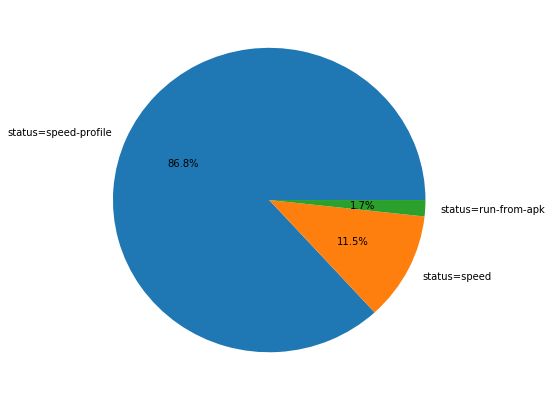

In [34]:
dexopt_lines = lp.log_sections['SERVICE package']
status_lines = grep(dexopt_lines,['status='], 1, show=False)

dexopt_state = dict()
for line in status_lines:
    if 'compilation_filter' in line:
        splited_line = line.split(',')
        status = splited_line[-1]
        dexopt_state[status] = dexopt_state.get(status, 0) + 1
    else:
        splited_line = line.split('[')
        if len(splited_line) > 0 and 'status' in splited_line[1]:         
            status = splited_line[1][:-2]
            dexopt_state[status] = dexopt_state.get(status, 0) + 1

#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
print("total {} packages".format(len(status_lines)))
plt.figure(figsize=(7, 7))
plt.pie(dexopt_state.values(), labels = dexopt_state.keys(), autopct='%1.1f%%') 
plt.show() 

* DESCRIPTION

Fota 후 background dex optimization 동작 전이라, 대부분의 앱들이 [verify] 상태입니다.<br>
이 경우 method read시 마다 apk를 직접 access 후 verification, JIT 과정을 거치기에 느려질 수 있습니다<br>
그러나 유휴 시간(잠자기 전에 충전기를 연결해 놓고 아침까지 단말 방치해 놓으면)이 지나면 Android 시스템이 애플리케이션을 다시 컴파일합니다.<br>
일반적으로 2 ~ 3 일이 소요됩니다.

----------------------------------------------------------------------------------

A few apps had changed to the speed-profile or the speed status during [two weeks]  after SW update, but more than [80%] was still in the verify status. <br>
[Gallery, chrome and facebook], which were used frequently by user, were still in the verify status.<br>

Android devices use a profile-based compilation system.<br>
This means, after SW update, the previous compilation for every single application is cleared.<br>
So, applications might be slightly slower than before for a while after SW update.<br>
Also, because of the initial loads right after the SW update, there was performance restriction to control overheat temporarily. <br>
[But after idle time(based on user's behavier, just leave the device with charger when you go to sleep), Android system will be compiling the application again. <br>
It will usually take two or three days.]


* kr.co.avad.diagnostictool app is used in A/S center.
* com.rsupport.rs.activity.rsupport.aas2 is remote service app.
* com.lguplus.mobile.smartcounsel is U+ customer service app.
* com.samsung.android.lool is device care app.
* com.samsung.android.sidegesturepad is one hand operation app.


In [35]:
lines = ssrm.file_lines
tmp = grep(lines,['kr.co.avad.diagnostictool', 'com.rsupport.rs.activity.rsupport.aas2', 'com.lguplus.mobile.smartcounsel', 'com.samsung.android.lool', 'com.samsung.android.sidegesturepad'], 1)

--- Nothing ---


In [36]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: skipped'], 1)

--- Nothing ---


* Bad apps

: The PUBG game(com.tencent.ig) app have performance problem with LSI Ramen chip.

 4: name='Window{f7a5252 u0 com.autoclicker.clicker}', displayId=0, paused=false, hasFocus=false, hasWallpaper=false, visible=true, canReceiveKeys=false, flags=0x00000518, type=0x000007f6, samsungFlags=0x00000000, layer=121205, frame=[360,640][440,720], scale=1.000000, touchableRegion=[360,640][440,720], pTouchableRegion=<empty>, inputFeatures=0x00000000, ownerPid=2763, ownerUid=10837, dispatchingTimeout=5000.000ms

: The reddit app have a sluggish problm when scrolling in the app.

: Alibaba app(com.alibaba.aliexpresshd') could remove a file of mediaprovider.

In [37]:
lines = ssrm.file_lines
com_lines = grep(lines,['com.cashwalk.cashwalk', 'com.tencent.ig', 'com.reddit.frontpage', 'com.alibaba.aliexpresshd'], 1, show=True)

--- Nothing ---


In [38]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['com.autoclicker.clicker'], 1)

--- Nothing ---


* Check apps

In [39]:
lines = ssrm.file_lines
pkg_lines = grep(lines, ['PKG'], 1, show=False)
tmp = grep(pkg_lines, ['com.samsung.android.lool'], 2, show=True)

--- Nothing ---


* Youtube known issue.<br>
b/155941392 [Youtube] Frequent GC operation and it causes sluggish on device

In [40]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['ImageManager: cannot preload image. Invalid dimensions given'], 1)

--- Nothing ---


--- Nothing ---
--- Nothing ---


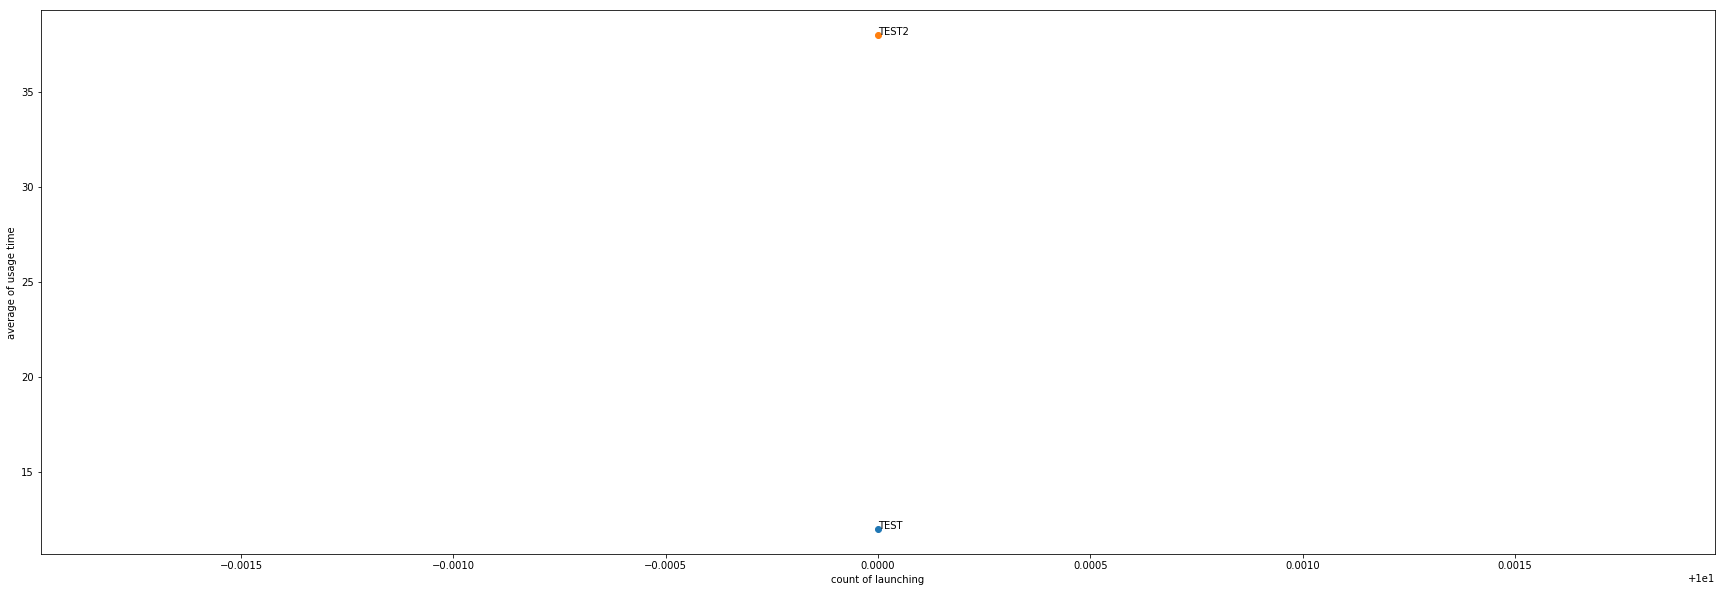

count of launching  mean of usage time  median of usage time  \
TEST                   10                  12                    28   
TEST2                  10                  38                     4   

            status  
TEST   Not matched  
TEST2  Not matched

In [41]:
lines = ssrm.file_lines
package_lines = grep(lines,['PKG', 'LCD'], 1, show=False)

packages_number = dict()
packages_runing_time = dict()

pre_time = 0

for package_line in package_lines:
    time = GetTime(package_line, 'SSRM')
    #print(time)
    if pre_time > 0:
        packages_number[pre_package][0] += 1
        if time > pre_time:
            packages_runing_time[pre_package].append((time - pre_time) / 1000)
        else:
            packages_runing_time[pre_package].append(0)
        
    if 'PKG' in package_line and 'OVHT_TYPE' not in package_line:
        package = package_line[26:]
        if ' ' in package:
            package = package.split(' ')[0]
        if not package in packages_number:
            packages_number[package] = [0]
            packages_runing_time[package] = list()
            
        pre_package = package
        pre_time = time


plt.figure(figsize=(30,10))

dexopt_lines = lp.log_sections['SERVICE package']
status_lines = grep(dexopt_lines,['status='], -2, show=False)

max_number_of_columns = 0
for package in packages_number:
    if packages_number[package][0] != 0:
        avg_launching = np.sum(packages_runing_time[package]) / packages_number[package][0]
    else:
        avg_launching = 0
    plt.text(packages_number[package][0], avg_launching, package)
    plt.scatter(packages_number[package][0], avg_launching)
    packages_number[package].append(avg_launching)

    if len(packages_runing_time[package]) > 0:
        median_launching = packages_runing_time[package][packages_number[package][0] / 2]
    else:
        median_launching = 0
    packages_number[package].append(median_launching)
    package_status = grep(status_lines,[package], 3, show=False)
    
    flag = False
    for line in package_status:
        if 'status=' in line:
            splited = line.split(' ')
            packages_number[package].append(splited[1])
            flag = True
            break
    if flag is False:
        packages_number[package].append('Not matched')
plt.xlabel('count of launching')
plt.ylabel('average of usage time')
#plt.xlim(0, 100)
plt.show()
    
df = pd.DataFrame.from_dict(packages_number, orient='index', columns=['count of launching', 'mean of usage time', 'median of usage time', 'status'])
df = df.sort_values(by=['count of launching'], ascending=False)
display(df.head(50))

* Explain of auto_disabler<br>
앱 자동 초절전 기능은 32일 이상 사용하지 않은 앱에 대하여, 앱이 bg 에 있을 때 disable 시키는 기능으로, 15일을 주기로 "초절전 후보 앱 (=32일 미사용 앱)"을 사용자에게 보여주고 disable 시킵니다.

In [42]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['auto_disabler'], 1)

10-22 21:35:28.029  1000  1507  2132 D PackageManager: setEnabledSetting : userId = 0 packageName = radioplayer.radioactiva1015.app cmp = null newState = 1 callingPackage = auto_disabler


# <span style="color:blue">[MEMORY]</span> 

In [43]:
meminfo_lines = lp.log_sections['SERVICE HIGH meminfo']
searchers = [': Native', ': System', ': Persistent', ': Persistent Service', ': Foreground', ': Visible', ': Perceptible', ': Perceptible Low', ': A Services', ': Previous', ': B Services', ': Picked', ': Seedbed', ': Cached']
High_meminfo = list()

for searcher in searchers:
    for meminfo_line in meminfo_lines:
        if searcher in meminfo_line:
            High_meminfo.append(meminfo_line)
            break
display(High_meminfo)

['    359,452K: Native\n',
 '    253,940K: System\n',
 '    643,040K: Persistent\n',
 '    171,548K: Persistent Service\n',
 '    269,132K: Foreground\n',
 '    450,252K: Visible\n',
 '    273,916K: Perceptible\n',
 '    110,656K: Previous\n',
 '    509,816K: B Services\n',
 '    265,720K: Picked\n',
 '  1,252,972K: Cached\n']

* If swap size of an item is large, there is a possiblity to have a memory leak problem.
* If count of cached items is under 3 or missing, there is a possiblity to have a higher memory pressure problem.

In [44]:
lines = lp.log_sections['SERVICE HIGH meminfo']
Total_PSS = grep(lines,['Total PSS by process'], 5)
print('          :')
tmp = grep(lines,[': Picked'], 5)
print('          :')
tmp = grep(lines,[': Cached'], 10)
print('          :')
tmp = grep(lines,[': Perceptible'], 5)
print('          :')
tmp = grep(lines,[': Persistent'], 5)

Total PSS by process:
223,709K: system (pid 1507)                                            (   47,943K in swap)
158,161K: com.android.systemui (pid 2165)                              (   66,555K in swap)
143,136K: com.instagram.android (pid 9618 / activities)                (   75,994K in swap)
111,770K: com.samsung.android.voc (pid 29588 / activities)             (   31,878K in swap)
          :
265,720K: Picked
137,644K: com.instagram.android (pid 9618 / activities)
72,568K: com.whatsapp (pid 18085)
55,508K: com.samsung.cmh:CMH (pid 4681)
1,252,972K: Cached
210,029K: Picked                                                       (  113,066K in swap)
143,136K: com.instagram.android (pid 9618 / activities)                (   75,994K in swap)
40,112K: com.whatsapp (pid 18085)                                     (   22,714K in swap)
26,781K: com.samsung.cmh:CMH (pid 4681)                               (   14,358K in swap)
369,380K: Cached                                                  

* Example

** MEMINFO in pid 22996 [cheehoon.ha.particulateforecaster] **<br>
                   Pss      Pss   Shared  Private   Shared  Private  SwapPss      Rss     Heap     Heap     Heap<br>
                 Total    Clean    Dirty    Dirty    Clean    Clean    Dirty    Total     Size    Alloc     Free<br>
                ------   ------   ------   ------   ------   ------   ------   ------   ------   ------   ------<br>
  Native Heap    29394        0      548    29392       52        0    96613    29992   171188   101061    66689<br>
  Dalvik Heap    15436        0      392    15432       92        0    20491    15916    45844    37652     8192<br>
 Dalvik Other     9230        0     2960     7892      212        0      500    11064<br>
        Stack     1304        0       12     1304        0        0     3164     1316<br>
       Ashmem        0        0        0        0       16        0        0       16<br>
    Other dev       60        0      312       48       60       12        0      432<br>
     .so mmap      423        0      848      108    17060        0      196    18016<br>
    .jar mmap      476      124        0        0    18968      124        8    19092<br>
    .apk mmap     6248     3180        0       12    18872     3180      240    22064<br>
    .ttf mmap        0        0        0        0        4        0        0        4<br>
    .dex mmap     4020     3384        0        0     2700     3384       96     6084<br>
    .oat mmap      169        0        8        0     9492        0        0     9500<br>
    .art mmap     1970       16    14208     1756     3744       16      708    19724<br>
   Other mmap      272        0        4       32     1080       20        8     1136<br>
    GL mtrack   224525        0        0   224525        0        0        0   224525                           <span style="color:red">=> Over usage of graphic memory</span> <br>
      Unknown     1040        0      104     1040       60        0      754     1204<br>
        TOTAL   417345     6704    19396   281541    72412     6736   122778   380085   217032   138713    74881<br> 

In [45]:
high_meminfo = lp.log_sections['SERVICE HIGH meminfo']
lines = grep(high_meminfo,['MEMINFO in'], 80, show=False)
count = 0
OverMemUsages = grep(Total_PSS,['[5-9][0-9][0-9],'], 1, show=False)
OverMemUsageProcesses = list()

for line in OverMemUsages:
    splited_line = line.split(' ')
    if len(splited_line) > 1 :
        OverMemUsageProcesses.append('[' + splited_line[1] + ']')
print(OverMemUsageProcesses)

for line in lines:
    if 'MEMINFO in' in line:
        for OverMemUsageProcess in OverMemUsageProcesses:
            if OverMemUsageProcess in line:
                print('\n===================================================================================================================\n')
                count = 80
    if count > 0 :
        print(line)
        count -= 1

--- Nothing ---
[]


 App Summary<br>
                       Pss(KB)                        Rss(KB)<br>
                        ------                         ------<br>
           Java Heap:   257652                         276248<br>
         Native Heap:    58024                          58556<br>
                Code:     4908                          71016<br>
               Stack:      984                            992<br>
            Graphics:    51836                          51836<br>
       Private Other:     7772<br>
              System:  1625935<br>
             Unknown:                                    8804<br>
           TOTAL PSS:  2007111            TOTAL RSS:   467452       TOTAL SWAP PSS:  1619250<br>
 Objects<br>
               Views:    62516         ViewRootImpl:        0                     <span style="color:red">=> Over usage of views</span><br>
         AppContexts:      598           Activities:      195<br>
              Assets:       18        AssetManagers:        0<br>
       Local Binders:     1029        Proxy Binders:      258<br>
       Parcel memory:    35514         Parcel count:    16702<br>
    Death Recipients:        2      OpenSSL Sockets:        0<br>
            WebViews:        0 <br>

In [46]:
high_meminfo = lp.log_sections['SERVICE HIGH meminfo']
lines = grep(high_meminfo,['MEMINFO in'], 80, show=False)

MEMINFO = list()
for line in lines:
    if 'MEMINFO in' in line:
        del MEMINFO[:]
        MEMINFO = list()
        MEMINFO.append(line)
    
    if 'Views:' in line and 'ViewRootImpl:' in line:
        MEMINFO.append(line)
        number_of_view = re.sub(' +', ' ', line)
        number_of_view = number_of_view.split(' ')
        
        if int(number_of_view[1]) > 10000:
            display(MEMINFO)

------ MEMORY INFO (/proc/meminfo) ------
MemTotal:        2882972 kB
MemFree:           79296 kB
MemAvailable:     785080 kB
Buffers:            1904 kB
Cached:           772620 kB
SwapCached:        23820 kB
Active:           897008 kB
Inactive:         867964 kB
Active(anon):     509068 kB
Inactive(anon):   506244 kB
Active(file):     387940 kB
Inactive(file):   361720 kB
Unevictable:        2164 kB
Mlocked:            2164 kB
SwapTotal:       1572860 kB
SwapFree:         500620 kB
Dirty:               676 kB
Writeback:             0 kB
AnonPages:        983456 kB
Mapped:           527708 kB
Shmem:             23316 kB
Slab:             294576 kB     // Slab memory leak, 10%
SReclaimable:      80208 kB
SUnreclaim:       214368 kB
KernelStack:       62032 kB
PageTables:        73908 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     3014344 kB
Committed_AS:   62694120 kB
VmallocTotal:   263061440 kB
VmallocUsed:           0 kB
Vmal

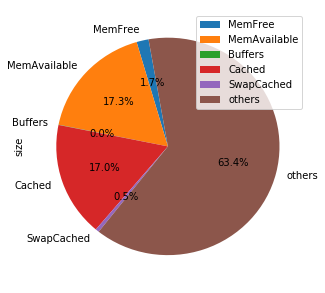

In [47]:
memory_infors = lp.log_sections['MEMORY INFO'][:38]
MemTotal = 0
Slab = 0

for memory_infor in memory_infors:
    if 'MemTotal:' in memory_infor:
        splited = memory_infor.split(' ')
        MemTotal = int(splited[-2])

    if 'SwapFree:' in memory_infor:
        splited = memory_infor.split(' ')
        if int(splited[-2]) < 7000:
            print('{}     // SwapFree is low'.format(memory_infor[:-1]))
            continue
                
    if 'Slab:' in memory_infor:
        splited = memory_infor.split(' ')
        Slab = int(splited[-2])
        if Slab > 200000:
            print('{}     // Slab memory leak, {}%'.format(memory_infor[:-1], (Slab * 100 / MemTotal)))
            continue        

    print(memory_infor[:-1])

data = list()
sum = 0

for i in range(2,7):
    splited = lp.log_sections['MEMORY INFO'][i].split(':')
    size = int(splited[1].split('kB')[0])
    data.append([splited[0], size])
    sum += size

splited = lp.log_sections['MEMORY INFO'][1].split(':')
total = int(splited[1].split('kB')[0])
data.append(['others', total])

df = pd.DataFrame(data, columns=['id', 'size'])
df = df.set_index('id')

df.plot.pie(y='size',figsize=(5, 5), autopct='%1.1f%%', startangle=100)

plt.show()

09-02 15:40:31.760  lmkd   694   694 I killinfo: [8639,10397,985,850,93072,3,256564,883228,1073936,53420,2804,80732,6900,512000,512000,0,0,4194300,145860,1358660,1380248,417224,576228,97<br>

* minfree : 256564 <br>
* availablemem : 883228 <br>
* cachemem : 1073936 <br>
* buffer : 53420 <br>
* shared mem : 6900 <br>

In [48]:
lines = lp.log_sections['EVENT LOG']
killinfos = grep(lines,['killinfo'], 1)

--- Nothing ---


In [49]:
lines = lp.log_sections['EVENT LOG']
am_app_dieds = grep(lines,['am_proc_died'], 1)

10-22 21:05:34.711  1000  1507  1564 I am_proc_died: [0,12188,com.samsung.android.app.galaxyfinder:appservice,0,0,10,116,726]
10-22 21:05:38.628  1000  1507  3743 I am_proc_died: [0,12328,com.samsung.android.app.galaxyfinder:appservice,0,0,10,65,741]
10-22 21:05:39.699  1000  1507  3790 I am_proc_died: [0,12375,com.samsung.android.app.galaxyfinder:appservice,0,0,10,80,735]
10-22 21:05:49.313  1000  1507  2225 I am_proc_died: [0,10529,com.android.vending:instant_app_installer,0,999,19,88,737]
10-22 21:05:53.014  1000  1507  2190 I am_proc_died: [0,10648,com.google.android.apps.turbo,0,999,19,82,737]
10-22 21:05:53.024  1000  1507  2190 I am_proc_died: [0,10254,com.google.process.gservices,0,999,19,84,737]
10-22 21:05:53.048  1000  1507  5021 I am_proc_died: [0,9861,com.samsung.android.scloud,0,999,19,85,737]
10-22 21:06:24.072  1000  1507  4482 I am_proc_died: [0,10804,com.samsung.android.sm.policy,0,999,19,91,740]
10-22 21:06:24.104  1000  1507  5021 I am_proc_died: [0,10774,com.androi

10-22 21:05:34.711  1000  1507  1564 I am_proc_died: [0,12188,com.samsung.android.app.galaxyfinder:appservice,0,0,10,116,726]
10-22 21:05:38.628  1000  1507  3743 I am_proc_died: [0,12328,com.samsung.android.app.galaxyfinder:appservice,0,0,10,65,741]
10-22 21:05:39.699  1000  1507  3790 I am_proc_died: [0,12375,com.samsung.android.app.galaxyfinder:appservice,0,0,10,80,735]


Text(0.5,1,'OOM ADJ(AM_PROC_DIED)')

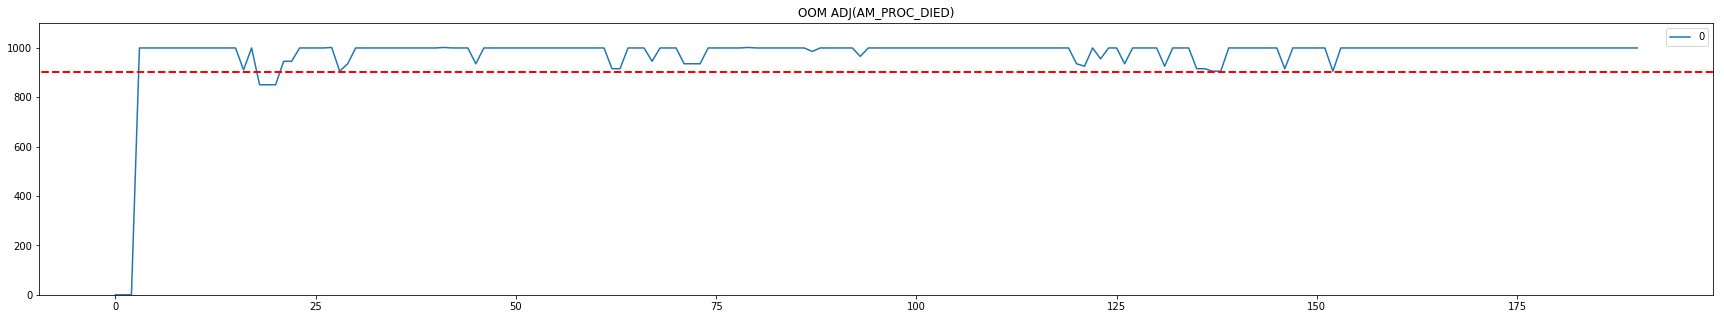

In [50]:
am_app_dieds_mem = list()
oom_adj = 0

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    pre_oom_adj = oom_adj
    oom_adj = int(splited[4])
    if oom_adj == 0 :
        oom_adj = pre_oom_adj
    am_app_dieds_mem.append(oom_adj)
    if oom_adj < 200 :
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0, 1100))
ax.axhline(y=900, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('OOM ADJ(AM_PROC_DIED)')

* Description

Some applications ( TikTok , Google Photos, Amazon Shopping ) were installed in sdcard in the user's device.<br>
When user entered those apps, It could be delayed.<br>
Please move those apps to the internal sdcard.<br>

/dev/block/dm-7                  9600    83   9517    1% /mnt/asec/com.zhiliaoapp.musically-w19U2VUWNRRfS9yi<br>
/dev/block/dm-8                  4448    23   4425    1% /mnt/asec/com.google.android.apps.photos-u7BcCB7ySRx2Bd4O<br>
/dev/block/dm-10                 5232    35   5197    1% /mnt/asec/com.amazon.mShop.android.shopping-Hys1Miat8tY5nhTH<br>

If the problem will happen again, after treating those apps.<br>
A dumpstate collected by Samsung Members application has a limited buffer size.<br>
So, it may not include the issue that you mentioned.<br>
Please report the issue right after it happens and elaborate on it.<br>
For better analysis, we need the name of application that is related to the issue and the time when it happens.

10-22 21:05:38.628  1000  1507  3743 I am_proc_died: [0,12328,com.samsung.android.app.galaxyfinder:appservice,0,0,10,65,741]
10-22 21:05:39.699  1000  1507  3790 I am_proc_died: [0,12375,com.samsung.android.app.galaxyfinder:appservice,0,0,10,80,735]
10-22 21:05:49.313  1000  1507  2225 I am_proc_died: [0,10529,com.android.vending:instant_app_installer,0,999,19,88,737]
10-22 21:05:53.014  1000  1507  2190 I am_proc_died: [0,10648,com.google.android.apps.turbo,0,999,19,82,737]
10-22 21:05:53.024  1000  1507  2190 I am_proc_died: [0,10254,com.google.process.gservices,0,999,19,84,737]
10-22 21:05:53.048  1000  1507  5021 I am_proc_died: [0,9861,com.samsung.android.scloud,0,999,19,85,737]
10-22 21:06:24.072  1000  1507  4482 I am_proc_died: [0,10804,com.samsung.android.sm.policy,0,999,19,91,740]
10-22 21:06:24.104  1000  1507  5021 I am_proc_died: [0,10774,com.android.systemui:edgelighting,0,999,19,92,740]
10-22 21:07:14.059  1000  1507  3757 I am_proc_died: [0,9446,com.osp.app.signin,0,999

Text(0.5,1,'FREE MEMORY(AM_PROC_DIED)')

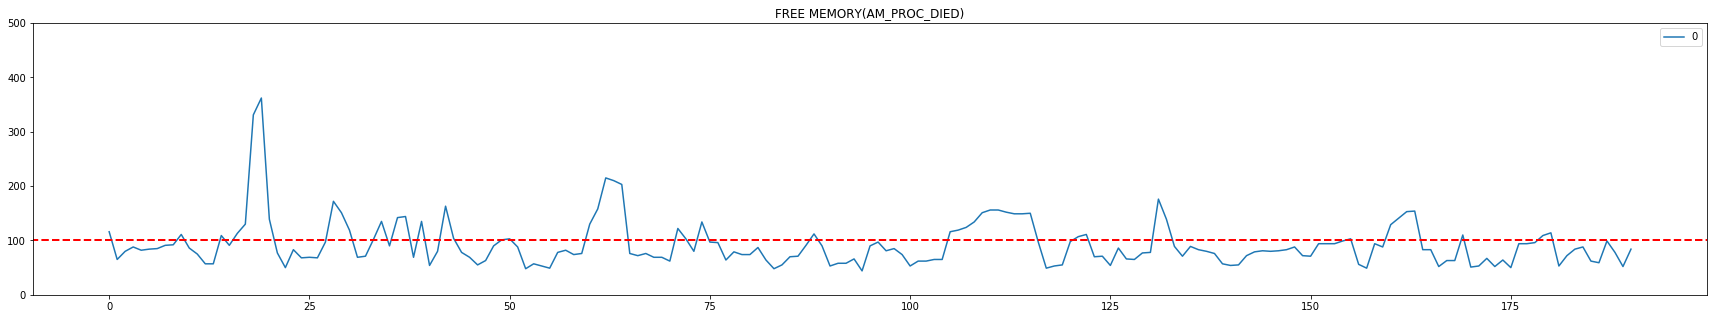

In [51]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-2]))
    if int(splited[-2]) < 100:
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5), ylim=(0,500))
ax.axhline(y=100, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FREE MEMORY(AM_PROC_DIED)')

10-22 21:05:34.711  1000  1507  1564 I am_proc_died: [0,12188,com.samsung.android.app.galaxyfinder:appservice,0,0,10,116,726]
10-22 21:05:38.628  1000  1507  3743 I am_proc_died: [0,12328,com.samsung.android.app.galaxyfinder:appservice,0,0,10,65,741]
10-22 21:05:39.699  1000  1507  3790 I am_proc_died: [0,12375,com.samsung.android.app.galaxyfinder:appservice,0,0,10,80,735]
10-22 21:05:49.313  1000  1507  2225 I am_proc_died: [0,10529,com.android.vending:instant_app_installer,0,999,19,88,737]
10-22 21:05:53.014  1000  1507  2190 I am_proc_died: [0,10648,com.google.android.apps.turbo,0,999,19,82,737]
10-22 21:05:53.024  1000  1507  2190 I am_proc_died: [0,10254,com.google.process.gservices,0,999,19,84,737]
10-22 21:05:53.048  1000  1507  5021 I am_proc_died: [0,9861,com.samsung.android.scloud,0,999,19,85,737]
10-22 21:06:24.072  1000  1507  4482 I am_proc_died: [0,10804,com.samsung.android.sm.policy,0,999,19,91,740]
10-22 21:06:24.104  1000  1507  5021 I am_proc_died: [0,10774,com.androi

Text(0.5,1,'FILE CACHE MEMORY(AM_PROC_DIED)')

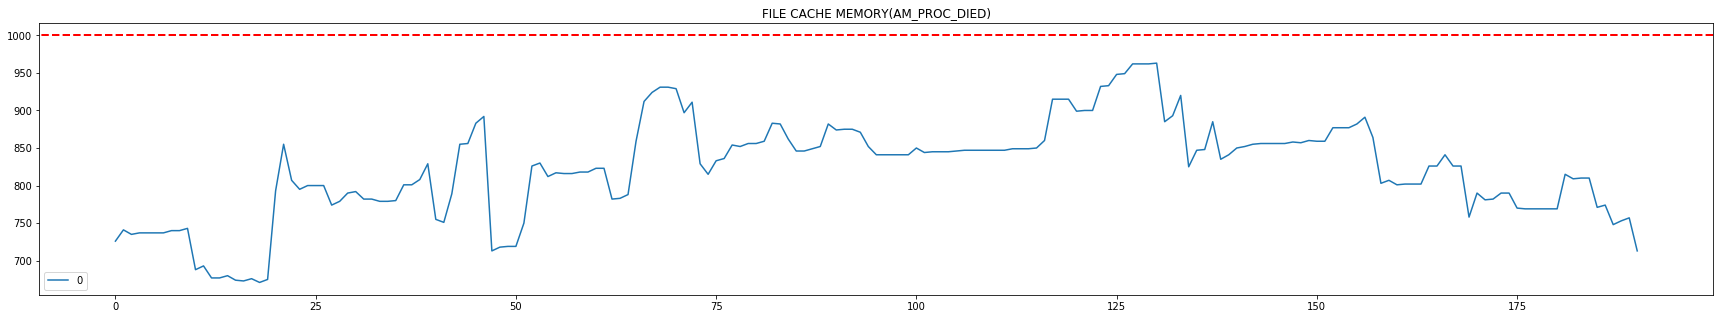

In [52]:
am_app_dieds_mem = list()

for am_app_died in am_app_dieds:
    splited = am_app_died.split(',')
    am_app_dieds_mem.append(int(splited[-1][:-1]))
    if int(int(splited[-1][:-1])) < 1000:
        print(am_app_died)
#print(am_app_dieds_mem)
df = pd.DataFrame(am_app_dieds_mem)
ax = df.plot(figsize=(30,5))
ax.axhline(y=1000, xmin=-1, xmax=1, color='r', linestyle='--', lw=2)
ax.set_title('FILE CACHE MEMORY(AM_PROC_DIED)')

In [53]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['WaitForGcToComplete blocked', 'Waiting for a blocking GC Alloc'], 1)

10-22 21:12:41.743 10336 30283  8258 I stagram.androi: WaitForGcToComplete blocked ProfileSaver on HeapTrim for 541.326ms
10-22 21:13:22.278 10238 17344 17363 I com.whatsapp: WaitForGcToComplete blocked ProfileSaver on RunEmptyCheckpoint for 382.479ms
10-22 21:14:38.862 10336  9618 17628 I stagram.androi: WaitForGcToComplete blocked ProfileSaver on ClassLinker for 197.372ms
10-22 21:14:38.892 10336  9618 17622 I stagram.androi: WaitForGcToComplete blocked RunEmptyCheckpoint on ProfileSaver for 30.344ms
10-22 21:15:30.136 10238 18085 18104 I com.whatsapp: WaitForGcToComplete blocked ProfileSaver on RunEmptyCheckpoint for 75.734ms
10-22 21:16:27.310 10173 18433 18454 I ding:backgroun: WaitForGcToComplete blocked ProfileSaver on AddRemoveAppImageSpace for 95.007ms
10-22 21:16:27.362 10173 18433 18446 I ding:backgroun: WaitForGcToComplete blocked RunEmptyCheckpoint on ProfileSaver for 45.468ms
10-22 21:21:03.561  5023 20932 20951 I tworkdiagnosti: WaitForGcToComplete blocked ProfileSaver o

In [54]:
lines = lp.log_sections['EVENT LOG']
am_app_pss_lines = grep(lines,['am_pss', 'am_on_top_resumed_gained_called'], 1, show=False)

for am_app_pss_line in am_app_pss_lines:
    if 'am_pss' in am_app_pss_line:
        am_app_pss_line_splited = am_app_pss_line.split(',')
        if len(am_app_pss_line_splited) > 7:
            pss = am_app_pss_line_splited[-7]
            pss_MB = int(pss) / 1024 / 1024
            if (pss_MB > 50) :
                print(am_app_pss_line + "\t\t\t\t\t// PSS : " + str(pss_MB) + " MB  by " + am_app_pss_line_splited[2])
    else:
        print(am_app_pss_line)

10-22 21:05:31.213  1000  1507  1629 I am_pss  : [9937,10189,com.facebook.orca,84694016,39055360,42513408,98230272,1,19,14]					// PSS : 80 MB  by com.facebook.orca
10-22 21:05:31.292  1000  1507  1629 I am_pss  : [6936,10237,com.samsung.android.app.cocktailbarservice,67650560,10539008,55315456,61943808,1,8,11]					// PSS : 64 MB  by com.samsung.android.app.cocktailbarservice
10-22 21:05:31.375  1000  1507  1629 I am_pss  : [2439,1000,com.sec.imsservice,57457664,38719488,17135616,88272896,1,0,11]					// PSS : 54 MB  by com.sec.imsservice
10-22 21:05:31.429  1000  1507  1629 I am_pss  : [2165,10057,com.android.systemui,144807936,68837376,70441984,135122944,1,0,18]					// PSS : 138 MB  by com.android.systemui
10-22 21:05:31.477  1000  1507  1629 I am_pss  : [1507,1000,system,246864896,173117440,66260992,257015808,1,0,27]					// PSS : 235 MB  by system
10-22 21:05:52.999  1000  1507  1629 I am_pss  : [11594,10114,com.facebook.katana,108061696,102473728,382976,171544576,0,3,19]					// PSS 

In [55]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Couldn\'t load memtrack module', 'failed to get memory consumption'], 1)

10-22 21:18:21.932 10336  9618 17658 E memtrack: Couldn't load memtrack module


* If heap free size is 0%, it doubts a memory leak problem.

In [56]:
lines = lp.log_sections['VM TRACES JUST NOW']
heap_lines = grep(lines,['Cmd line:', 'Heap:', 'Total GC', 'Total blocking GC'], 1, show=False)

printable = list()
flag_print = False
for heap_line in heap_lines:
    if 'Cmd line:' in heap_line:
        if flag_print:
            display(printable)
            flag_print = False
        del printable[:]
    printable.append(heap_line)
    if 'Total GC count' in heap_line and re.search('[1-9][0-9][0-9][0-9][0-9]', heap_line):
        flag_print = True
    if 'Heap:' in heap_line and re.search(' [0-9]%', heap_line):
        flag_print = True

['Cmd line: com.google.android.gms.persistent',
 'Heap: 8% free, 45MB/49MB; 972439 objects',
 'Total GC count: 744',
 'Total GC time: 262.922s',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

['Cmd line: system_server',
 'Heap: 3% free, 87MB/91MB; 1591478 objects',
 'Total GC count: 7783',
 'Total GC time: 4512.567s',
 'Total blocking GC count: 94',
 'Total blocking GC time: 120.798s']

['Cmd line: com.samsung.android.voc',
 'Heap: 1% free, 33MB/33MB; 524927 objects',
 'Total GC count: 5',
 'Total GC time: 943.175ms',
 'Total blocking GC count: 0',
 'Total blocking GC time: 0']

In [57]:
lines = lp.log_sections['LOG STATISTICS']
tmp = grep(lines,['ring buffer is'], 1)

main: ring buffer is 5 MiB (4 MiB consumed), max entry is 5120 B, max payload is 4068 B
radio: ring buffer is 512 KiB (509 KiB consumed), max entry is 5120 B, max payload is 4068 B
events: ring buffer is 256 KiB (254 KiB consumed), max entry is 5120 B, max payload is 4068 B
system: ring buffer is 2 MiB (1 MiB consumed), max entry is 5120 B, max payload is 4068 B
crash: ring buffer is 256 KiB (64 KiB consumed), max entry is 5120 B, max payload is 4068 B
stats: ring buffer is 64 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
security: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B
kernel: ring buffer is 256 KiB (0 B consumed), max entry is 5120 B, max payload is 4068 B


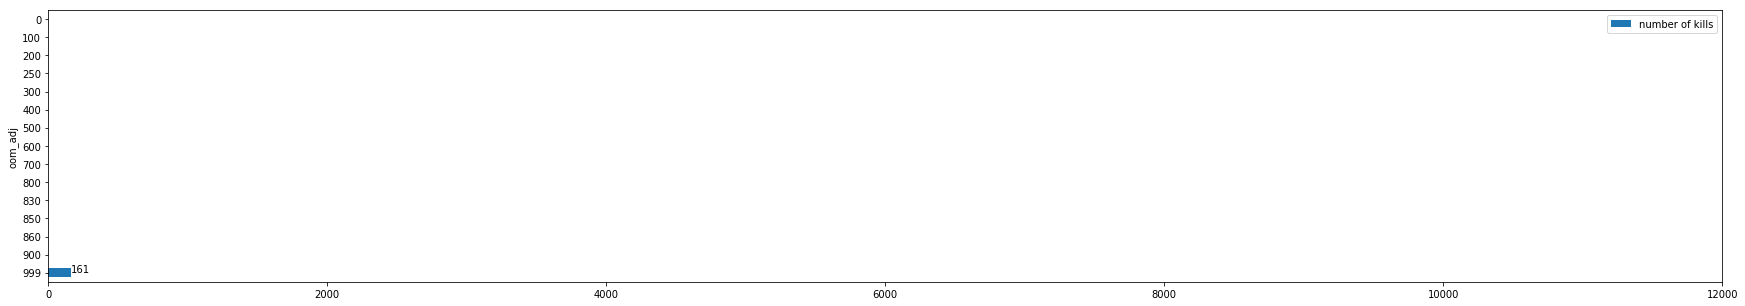

In [58]:
lines = lp.log_sections['ACTIVITY MANAGER LMK KILLS']
oom_adj_lines = grep(lines,['oom_adj'], 1, show=False)

if len(oom_adj_lines) > 0:
    lmk_kills = dict()
    lmk_kills['oom_adj'] = list()
    lmk_kills['number of kills'] = list()

    for oom_adj_line in oom_adj_lines:
        splited = oom_adj_line.split(' ')
        lmk_kills['oom_adj'].append(int(splited[-2][:-1]))
        lmk_kills['number of kills'].append(int(splited[-1]))

    df = pd.DataFrame.from_dict(lmk_kills)
    df.set_index('oom_adj', inplace=True)
    #df.sort_index(ascending=False)

    ax = df.plot(kind='barh', figsize=(30,5), xlim=(0,12000))
    for index, value in enumerate(df['number of kills']):
        if value > 0 and value < 12000:
            ax.text(value, index, str(value))
    plt.show()

* HeapTaskDaemon

<6>[51056.032367] [4:pool-42-thread-: 2960] heaviest_task_rss:.mobile.pguidea(28116) size:375680KB, totalram_pages:6480004KB

In [59]:
lines = lp.log_sections['SEC LOG']
lines += lp.log_sections['KERNEL LOG']

tmp = grep(lines,['heaviest_task_rss'], 1, show=True)

--- Nothing ---


* heimdall

12-23 09:05:07.849  1000   875   925 I heimdall: recv_memcg_event:1254, receiving 661 node 1 level 4 for com.skt.skaf.l001mtm091 total 1 memcg_usage 4303790080

In [60]:
lines = lp.log_sections['SYSTEM LOG']
memcg_usage_lines = grep(lines,['memcg_usage'], 1, show=False)
for line in memcg_usage_lines:
    splited = line.split('memcg_usage')
    memsize = int(splited[1])
    print('{}         // {}GB'.format(line, memsize / 1024.0 / 1024.0 / 1024.0))

--- Nothing ---


* lmk kill reasons
    enum kill_reasons {
        NONE = -1, /* To denote no kill condition */
        PRESSURE_AFTER_KILL = 0,
        NOT_RESPONDING,
        LOW_SWAP_AND_THRASHING,
        LOW_MEM_AND_SWAP,
        LOW_MEM_AND_THRASHING,
        DIRECT_RECL_AND_THRASHING,
        LOW_MEM_AND_SWAP_UTIL,
        PRESSURE_AFTER_KILL_DRKILL,
        EMERGENCY_KILL,
        EMERGENCY_KILL_LOWCACHE,
        KILL_REASON_COUNT
    };


* OutOfMemoryError

In [61]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['OutOfMemoryError'], 1, show=True)

--- Nothing ---


# <span style="color:blue">[PROCSTATS]</span>

* displayed format

PSS min 346MB - PSS avg 1.3GB - PSS max 2.9GB / RSS min 342MB - RSS avg 1.3GB - RSS max 2.9GB / USS min 479MB - USS avg 1.3GB - USS max 3.0GB 

In [62]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('GB', line)
        if len(memory) > 0:
            flag = True

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '      (Cached): 100% (1.4GB-1.4GB-1.4GB/453MB-1.0GB-1.3GB/1.5GB-1.2GB-1.5GB over 3)\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '      (Cached): 100% (1.3GB-1.4GB-1.4GB/81MB-128MB-176MB/229MB-209MB-268MB over 6)\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-81MB-83MB/144MB-142MB-144MB over 2\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '      (Cached): 56% (1.4GB-1.4GB-1.4GB/79MB-81MB-83MB/144MB-142MB-144MB over 2)\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-735MB-1.4GB/144MB-865MB-1.6GB over 13\n',
 '           SOn/Norm/       Top: 434MB-460MB-491MB/426MB-451MB-481MB/610MB-638MB-669MB over 3\n',
 '                     (Cch Act): 1.1GB-1.2GB-1.4GB/81MB-600MB-1.1GB/268MB-756MB-1.3GB over 4\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.moblin.totowiner / u0a457 (8 entries):\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-735MB-1.4GB/144MB-865MB-1.6GB over 13\n',
 '                    (Cch Emty): 30MB-30MB-30MB/28MB-28MB-28MB/135MB-135MB-135MB over 1\n',
 '           SOn/Norm/       Top: 434MB-454MB-491MB/426MB-445MB-481MB/612MB-631MB-669MB over 4\n',
 '                    (Last Act): 401MB-402MB-402MB/392MB-392MB-393MB/577MB-577MB-577MB over 2\n',
 '                     (Cch Act): 1.1GB-1.2GB-1.4GB/81MB-600MB-1.1GB/268MB-756MB-1.3GB over 4\n',
 '                    (Cch Emty): 28MB-29MB-30MB/26MB-27MB-28MB/134MB-134MB-134MB over 7\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.facebook.katana / u0a178 (12 entries):\n',
 '          SOff/Norm/(Cch Emty): 184MB-186MB-189MB/176MB-179MB-182MB/312MB-314MB-316MB over 2\n',
 '           SOn/Norm/       Top: 391MB-564MB-704MB/379MB-533MB-663MB/758MB-779MB-0.91GB over 20\n',
 '                    Bnd TopFgs: 195MB-196MB-197MB/190MB-191MB-192MB/325MB-324MB-325MB over 2\n',
 '                       Service: 493MB-621MB-850MB/458MB-584MB-809MB/758MB-861MB-1.1GB over 4\n',
 '                     (Cch Act): 582MB-582MB-582MB/544MB-544MB-544MB/825MB-825MB-825MB over 1\n',
 '                    (Cch Emty): 130MB-169MB-226MB/124MB-163MB-219MB/252MB-294MB-356MB over 47\n',
 '        Cur time +11m39s182ms: 136MB-138MB-141MB/130MB-133MB-135MB/260MB-265MB-274MB over 6\n']

['  * com.facebook.katana / u0a178 / v310616706:\n',
 '         TOTAL: 17% (195MB-544MB-850MB/190MB-515MB-809MB/325MB-756MB-1.1GB over 26)\n',
 '           Top: 16% (391MB-564MB-704MB/379MB-533MB-663MB/758MB-779MB-0.91GB over 20)\n',
 '    Bnd TopFgs: 0.54% (195MB-196MB-197MB/190MB-191MB-192MB/325MB-324MB-325MB over 2)\n',
 '       Service: 0.66% (493MB-621MB-850MB/458MB-584MB-809MB/758MB-861MB-1.1GB over 4)\n',
 '      (Cached): 47% (130MB-178MB-582MB/124MB-171MB-544MB/252MB-305MB-825MB over 50)\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '         TOTAL: 0.73% (434MB-454MB-491MB/426MB-445MB-481MB/612MB-631MB-669MB over 4)\n',
 '           Top: 0.73% (434MB-454MB-491MB/426MB-445MB-481MB/612MB-631MB-669MB over 4)\n',
 '    (Last Act): 0.68% (401MB-402MB-402MB/392MB-392MB-393MB/577MB-577MB-577MB over 2)\n',
 '      (Cached): 46% (28MB-0.92GB-1.4GB/26MB-487MB-1.4GB/134MB-613MB-1.6GB over 25)\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-81MB-83MB/144MB-142MB-144MB over 2\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '      (Cached): 56% (1.4GB-1.4GB-1.4GB/79MB-81MB-83MB/144MB-142MB-144MB over 2)\n']

In [63]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('[7-9][0-9][0-9]MB', line)
        if len(memory) > 0:
            flag = True

['  * system / 1000 / v31:\n',
 '         TOTAL: 100% (408MB-475MB-646MB/338MB-402MB-561MB/492MB-554MB-745MB over 5)\n',
 '    Persistent: 100% (408MB-475MB-646MB/338MB-402MB-561MB/492MB-554MB-745MB over 5)\n']

['  * android / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m5s619ms (running): 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n',
 '          SOff/Norm/   Service: 24MB-36MB-48MB/9.7MB-27MB-44MB/122MB-122MB-122MB over 2\n',
 '           SOn/Norm/   Service: 24MB-25MB-26MB/4.6MB-6.6MB-9.7MB/122MB-124MB-127MB over 3\n',
 '        Cur time +1h30m5s213ms (running): 23MB-28MB-48MB/4.6MB-12MB-44MB/134MB-128MB-134MB over 10\n']

['  * com.android.providers.settings / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m4s860ms (running): 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n',
 '          <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '          <- com.samsung.android.app.ledbackcover/u0a59 (com.samsung.android.app.ledbackcover):\n',
 '          <- com.sec.android.easyMover.Agent/u0a137 (com.sec.android.easyMover.Agent):\n',
 '          <- com.sec.android.easyMover/u0a232 (com.sec.android.easyMover):\n',
 '        <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '        <- com.samsung.android.app.ledbackcover/u0a59 (com.samsung.android.app.ledbackcover):\n',
 '        <- com.sec.android.easyMover.Agen

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-81MB-83MB/144MB-142MB-144MB over 2\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.android.server.telecom / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m4s859ms (running): 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.dsi.ant.server / 1000 / v30000:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h25m25s864ms (running): 324MB-428MB-646MB/258MB-357MB-561MB/624MB-520MB-750MB over 54\n']

['  * com.samsung.android.honeyboard / u0a274 / v542006300:\n',
 '          SOff/Norm/    Imp Bg: 244MB-249MB-254MB/159MB-168MB-178MB/250MB-262MB-274MB over 2\n',
 '           SOn/Norm/Bnd TopFgs: 277MB-435MB-592MB/208MB-340MB-471MB/705MB-513MB-705MB over 2\n',
 '                        Imp Bg: 252MB-252MB-252MB/181MB-181MB-181MB/276MB-276MB-276MB over 1\n',
 '        Cur time +1d3h26m11s386ms (running): 143MB-217MB-592MB/28MB-134MB-471MB/317MB-254MB-705MB over 74\n']

['  * com.android.networkstack.tethering.inprocess / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h26m58s787ms (running): 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.android.wallpaperbackup / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +17h8m6s78ms (running): 374MB-451MB-646MB/302MB-378MB-561MB/448MB-537MB-750MB over 33\n']

['  * com.android.location.fused / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h26m59s41ms (running): 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * system / 1000 (2 entries):\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m5s619ms (running): 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.samsung.android.honeyboard / u0a274 / v542006300:\n',
 '         TOTAL: 100% (244MB-324MB-592MB/159MB-239MB-471MB/250MB-365MB-705MB over 5)\n',
 '    Bnd TopFgs: 25% (277MB-435MB-592MB/208MB-340MB-471MB/705MB-513MB-705MB over 2)\n',
 '        Imp Bg: 75% (244MB-250MB-254MB/159MB-173MB-181MB/250MB-267MB-276MB over 3)\n']

['  * android / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +1d3h27m6s434ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n',
 '          SOff/Norm/(Cch Emty): 66MB-66MB-66MB/41MB-41MB-41MB/228MB-228MB-228MB over 1\n',
 '           SOn/Norm/(Cch Emty): 55MB-59MB-66MB/38MB-40MB-41MB/225MB-227MB-228MB over 3\n',
 '          SOff/Norm/   Service: 10MB-26MB-48MB/1.3MB-14MB-44MB/122MB-124MB-137MB over 20\n',
 '           SOn/Norm/   Service: 10MB-25MB-29MB/4.6MB-9.3MB-9.8MB/122MB-133MB-138MB over 40\n',
 '        Cur time +1h30m6s28ms: 23MB-28MB-48MB/4.6MB-12MB-44MB/134MB-128MB-134MB over 10\n']

['  * com.android.providers.settings / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +1d3h27m5s675ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n',
 '          <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '          <- com.samsung.android.app.ledbackcover/u0a59 (com.samsung.android.app.ledbackcover):\n',
 '          <- com.sec.android.easyMover.Agent/u0a137 (com.sec.android.easyMover.Agent):\n',
 '          <- com.sec.android.easyMover/u0a232 (com.sec.android.easyMover):\n',
 '        <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '        <- com.samsung.android.app.ledbackcover/u0a59 (com.samsung.android.app.ledbackcover):\n',
 '        <- com.sec.android.easyMover.Agent/u0a137 

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-735MB-1.4GB/144MB-865MB-1.6GB over 13\n',
 '           SOn/Norm/       Top: 434MB-460MB-491MB/426MB-451MB-481MB/610MB-638MB-669MB over 3\n',
 '                     (Cch Act): 1.1GB-1.2GB-1.4GB/81MB-600MB-1.1GB/268MB-756MB-1.3GB over 4\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.android.server.telecom / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +1d3h27m5s674ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.dsi.ant.server / 1000 / v30000:\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +1d3h25m26s679ms: 324MB-428MB-646MB/258MB-357MB-561MB/624MB-520MB-750MB over 54\n']

['  * com.samsung.android.honeyboard / u0a274 / v542006300:\n',
 '          SOff/Norm/Bnd TopFgs: 259MB-263MB-265MB/179MB-191MB-207MB/267MB-300MB-324MB over 3\n',
 '                        Imp Bg: 218MB-235MB-254MB/105MB-142MB-178MB/250MB-260MB-290MB over 14\n',
 '           SOn/Norm/       Top: 258MB-259MB-260MB/195MB-197MB-198MB/338MB-340MB-342MB over 2\n',
 '                    Bnd TopFgs: 258MB-376MB-592MB/197MB-292MB-471MB/705MB-455MB-705MB over 3\n',
 '                        Imp Bg: 217MB-235MB-252MB/149MB-165MB-185MB/276MB-289MB-326MB over 13\n',
 '        Cur time +1d3h26m12s201ms: 143MB-217MB-592MB/28MB-134MB-471MB/317MB-254MB-705MB over 74\n']

['  * com.android.networkstack.tethering.inprocess / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +1d3h26m59s602ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.android.wallpaperbackup / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +17h8m6s893ms: 374MB-451MB-646MB/302MB-378MB-561MB/448MB-537MB-750MB over 33\n']

['  * com.android.location.fused / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +1d3h26m59s856ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * system / 1000 (3 entries):\n',
 '          SOff/Norm/Persistent: 385MB-450MB-646MB/314MB-378MB-561MB/503MB-535MB-745MB over 15\n',
 '           SOn/Norm/Persistent: 374MB-444MB-528MB/302MB-367MB-430MB/531MB-538MB-653MB over 8\n',
 '        Cur time +1d3h27m6s434ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.moblin.totowiner / u0a457 (8 entries):\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-735MB-1.4GB/144MB-865MB-1.6GB over 13\n',
 '                    (Cch Emty): 30MB-30MB-30MB/28MB-28MB-28MB/135MB-135MB-135MB over 1\n',
 '           SOn/Norm/       Top: 434MB-454MB-491MB/426MB-445MB-481MB/612MB-631MB-669MB over 4\n',
 '                    (Last Act): 401MB-402MB-402MB/392MB-392MB-393MB/577MB-577MB-577MB over 2\n',
 '                     (Cch Act): 1.1GB-1.2GB-1.4GB/81MB-600MB-1.1GB/268MB-756MB-1.3GB over 4\n',
 '                    (Cch Emty): 28MB-29MB-30MB/26MB-27MB-28MB/134MB-134MB-134MB over 7\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.facebook.katana / u0a178 (12 entries):\n',
 '          SOff/Norm/(Cch Emty): 184MB-186MB-189MB/176MB-179MB-182MB/312MB-314MB-316MB over 2\n',
 '           SOn/Norm/       Top: 391MB-564MB-704MB/379MB-533MB-663MB/758MB-779MB-0.91GB over 20\n',
 '                    Bnd TopFgs: 195MB-196MB-197MB/190MB-191MB-192MB/325MB-324MB-325MB over 2\n',
 '                       Service: 493MB-621MB-850MB/458MB-584MB-809MB/758MB-861MB-1.1GB over 4\n',
 '                     (Cch Act): 582MB-582MB-582MB/544MB-544MB-544MB/825MB-825MB-825MB over 1\n',
 '                    (Cch Emty): 130MB-169MB-226MB/124MB-163MB-219MB/252MB-294MB-356MB over 47\n',
 '        Cur time +11m39s182ms: 136MB-138MB-141MB/130MB-133MB-135MB/260MB-265MB-274MB over 6\n']

['  * system / 1000 / v31:\n',
 '         TOTAL: 100% (374MB-448MB-646MB/302MB-374MB-561MB/503MB-536MB-745MB over 23)\n',
 '    Persistent: 100% (374MB-448MB-646MB/302MB-374MB-561MB/503MB-536MB-745MB over 23)\n']

['  * com.samsung.android.honeyboard / u0a274 / v542006300:\n',
 '         TOTAL: 100% (217MB-251MB-592MB/105MB-171MB-471MB/250MB-295MB-705MB over 35)\n',
 '           Top: 0.07% (258MB-259MB-260MB/195MB-197MB-198MB/338MB-340MB-342MB over 2)\n',
 '    Bnd TopFgs: 16% (258MB-319MB-592MB/179MB-242MB-471MB/267MB-377MB-705MB over 6)\n',
 '        Imp Bg: 84% (217MB-235MB-254MB/105MB-153MB-185MB/250MB-274MB-326MB over 27)\n']

['  * com.facebook.katana / u0a178 / v310616706:\n',
 '         TOTAL: 17% (195MB-544MB-850MB/190MB-515MB-809MB/325MB-756MB-1.1GB over 26)\n',
 '           Top: 16% (391MB-564MB-704MB/379MB-533MB-663MB/758MB-779MB-0.91GB over 20)\n',
 '    Bnd TopFgs: 0.54% (195MB-196MB-197MB/190MB-191MB-192MB/325MB-324MB-325MB over 2)\n',
 '       Service: 0.66% (493MB-621MB-850MB/458MB-584MB-809MB/758MB-861MB-1.1GB over 4)\n',
 '      (Cached): 47% (130MB-178MB-582MB/124MB-171MB-544MB/252MB-305MB-825MB over 50)\n']

['  * android / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m7s526ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n',
 '          SOff/Norm/   Service: 24MB-36MB-48MB/9.7MB-27MB-44MB/122MB-122MB-122MB over 2\n',
 '           SOn/Norm/   Service: 24MB-25MB-26MB/4.6MB-6.6MB-9.7MB/122MB-124MB-127MB over 3\n',
 '        Cur time +1h30m7s120ms: 23MB-28MB-48MB/4.6MB-12MB-44MB/134MB-128MB-134MB over 10\n']

['  * com.android.providers.settings / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m6s767ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n',
 '          <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '          <- com.samsung.android.app.ledbackcover/u0a59 (com.samsung.android.app.ledbackcover):\n',
 '          <- com.sec.android.easyMover.Agent/u0a137 (com.sec.android.easyMover.Agent):\n',
 '          <- com.sec.android.easyMover/u0a232 (com.sec.android.easyMover):\n',
 '        <- com.samsung.android.localeoverlaymanager/1000 (com.samsung.android.localeoverlaymanager):\n',
 '        <- com.samsung.android.app.ledbackcover/u0a59 (com.samsung.android.app.ledbackcover):\n',
 '        <- com.sec.android.easyMover.Agent/u0a137 (

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '          SOff/Norm/ (Cch Act): 1.4GB-1.4GB-1.4GB/79MB-81MB-83MB/144MB-142MB-144MB over 2\n',
 '        Cur time +4h22m49s519ms: 434MB-1.2GB-1.4GB/79MB-666MB-1.4GB/610MB-809MB-1.6GB over 20\n']

['  * com.android.server.telecom / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m6s766ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.dsi.ant.server / 1000 / v30000:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h25m27s771ms: 324MB-428MB-646MB/258MB-357MB-561MB/624MB-520MB-750MB over 54\n']

['  * com.samsung.android.honeyboard / u0a274 / v542006300:\n',
 '          SOff/Norm/    Imp Bg: 244MB-249MB-254MB/159MB-168MB-178MB/250MB-262MB-274MB over 2\n',
 '           SOn/Norm/Bnd TopFgs: 277MB-435MB-592MB/208MB-340MB-471MB/705MB-513MB-705MB over 2\n',
 '                        Imp Bg: 252MB-252MB-252MB/181MB-181MB-181MB/276MB-276MB-276MB over 1\n',
 '        Cur time +1d3h26m13s293ms: 143MB-217MB-592MB/28MB-134MB-471MB/317MB-254MB-705MB over 74\n']

['  * com.android.networkstack.tethering.inprocess / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m0s694ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.android.wallpaperbackup / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +17h8m7s985ms: 374MB-451MB-646MB/302MB-378MB-561MB/448MB-537MB-750MB over 33\n']

['  * com.android.location.fused / 1000 / v31:\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m0s948ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * system / 1000 (2 entries):\n',
 '          SOff/Norm/Persistent: 429MB-436MB-443MB/361MB-370MB-378MB/503MB-511MB-518MB over 2\n',
 '           SOn/Norm/Persistent: 444MB-447MB-449MB/368MB-370MB-371MB/531MB-529MB-531MB over 2\n',
 '        Cur time +1d3h27m7s526ms: 324MB-429MB-646MB/258MB-359MB-561MB/592MB-528MB-889MB over 56\n']

['  * com.samsung.android.honeyboard / u0a274 / v542006300:\n',
 '         TOTAL: 100% (244MB-324MB-592MB/159MB-239MB-471MB/250MB-365MB-705MB over 5)\n',
 '    Bnd TopFgs: 25% (277MB-435MB-592MB/208MB-340MB-471MB/705MB-513MB-705MB over 2)\n',
 '        Imp Bg: 75% (244MB-250MB-254MB/159MB-173MB-181MB/250MB-267MB-276MB over 3)\n']

In [64]:
lines = lp.log_sections['SERVICE procstats']
cur_lines = list()
flag = False
#display(lines)
for line in lines:
    if '*' in line:
        if flag:
            display(cur_lines)
            flag = False
        del cur_lines[:]
        cur_lines = list()
        cur_lines.append(line)
    elif 'over' in line:
        #numbers = re.findall('\d+', line)
        cur_lines.append(line)
        memory = re.findall('[0-9].[0-9][0-9]GB', line)
        if len(memory) > 0:
            flag = True

['  * com.facebook.katana / u0a178 (12 entries):\n',
 '          SOff/Norm/(Cch Emty): 184MB-186MB-189MB/176MB-179MB-182MB/312MB-314MB-316MB over 2\n',
 '           SOn/Norm/       Top: 391MB-564MB-704MB/379MB-533MB-663MB/758MB-779MB-0.91GB over 20\n',
 '                    Bnd TopFgs: 195MB-196MB-197MB/190MB-191MB-192MB/325MB-324MB-325MB over 2\n',
 '                       Service: 493MB-621MB-850MB/458MB-584MB-809MB/758MB-861MB-1.1GB over 4\n',
 '                     (Cch Act): 582MB-582MB-582MB/544MB-544MB-544MB/825MB-825MB-825MB over 1\n',
 '                    (Cch Emty): 130MB-169MB-226MB/124MB-163MB-219MB/252MB-294MB-356MB over 47\n',
 '        Cur time +11m39s182ms: 136MB-138MB-141MB/130MB-133MB-135MB/260MB-265MB-274MB over 6\n']

['  * com.facebook.katana / u0a178 / v310616706:\n',
 '         TOTAL: 17% (195MB-544MB-850MB/190MB-515MB-809MB/325MB-756MB-1.1GB over 26)\n',
 '           Top: 16% (391MB-564MB-704MB/379MB-533MB-663MB/758MB-779MB-0.91GB over 20)\n',
 '    Bnd TopFgs: 0.54% (195MB-196MB-197MB/190MB-191MB-192MB/325MB-324MB-325MB over 2)\n',
 '       Service: 0.66% (493MB-621MB-850MB/458MB-584MB-809MB/758MB-861MB-1.1GB over 4)\n',
 '      (Cached): 47% (130MB-178MB-582MB/124MB-171MB-544MB/252MB-305MB-825MB over 50)\n']

['  * com.moblin.totowiner / u0a457 / v2850:\n',
 '         TOTAL: 0.73% (434MB-454MB-491MB/426MB-445MB-481MB/612MB-631MB-669MB over 4)\n',
 '           Top: 0.73% (434MB-454MB-491MB/426MB-445MB-481MB/612MB-631MB-669MB over 4)\n',
 '    (Last Act): 0.68% (401MB-402MB-402MB/392MB-392MB-393MB/577MB-577MB-577MB over 2)\n',
 '      (Cached): 46% (28MB-0.92GB-1.4GB/26MB-487MB-1.4GB/134MB-613MB-1.6GB over 25)\n']

# <span style="color:blue">[APRESET]</span> 

* The behaviour of user, likes a term of reboot should be checked.
* MP : Force Reset
* KP : Kernel Panic
* DP : Kernel Watchdog
* PP : Sudden power off
* PF_SR (PLATFORM_SILENT_RESET) : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.  
* silent.sec : Automation Restart(Normal Operation)
* PF_EX (PLATFORM_EXCEPTION)
* PF_NT (PLATFORM_NATIVE_CRASH)
* PF_SF : Crash of surfaceflinger
* FOTA : multicmd
* RP : Normal reset

In [65]:
lines = lp.log_sections['AP RESET INFO']
tmp = grep(lines,['AP RESET INFO'])

------ AP RESET INFO EXTEND (/data/system/users/service/data/eRR.p: 2022-02-12 15:49:10) ------
LOGM�   �   



2019-01-02 16:21:34 |    ON    | RP    | N975FXXU1ASGO / OFFSRC: - / ONSRC: JIGONB / RSTSTAT: SWRESET
2019-01-01 00:00:23 | SHUTDOWN |       | REASON: [FactoryTest] powreset 0
2019-01-23 08:43:02 |    ON    | NP    | N975FXXU1ASGO / OFFSRC: PWRHOLD / ONSRC: PWRON / RSTSTAT: PINRESET RSVD30
2019-08-29 19:10:22 |  REBOOT  |       | REASON: recovery
2019-08-29 19:19:25 |    ON    | RP    | N975FXXU1ASH5 / OFFSRC: - / ONSRC: PWRON / RSTSTAT: SWRESET
2019-09-01 19:08:31 |  REBOOT  |       | REASON: recovery
2019-09-01 19:09:34 |    ON    | RP    | N975FXXU1ASH5 / OFFSRC: - / ONSRC: PWRON / RSTSTAT: SWRESET
2019-09-07 17:30:14 |  REBOOT  |       | REASON: recovery
2019-09-07 17:38:03 |    ON    | RP    | N975FXXU1ASHE / OFFSRC: - / ONSRC: PWRON / RSTSTAT: SWRESET
2019-09-26 13:48:28 | SHUTDOWN |       | REASON: userrequested
2019-09-26 14:47:43 |    ON    | NP    | N975FXXU1ASHE / 

# <span style="color:blue">[CRASH]</span> 

* In the case of fatal exception, data_app_crash should be confirmed togather.
* In the case of data_app_anr, app launch should be confirmed togather. 
* Crashlytics Exception could not effect to the performance.
* NPE by silent reset : Force sending signal to reboot the device. In this case, the dropbox should include system_server_crash log, but this is not effect to the performance.

In [66]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['FATAL EXCEPTION', 'Fatal signal', 'WAITED_HALF', 'SIGABRT'], 10)

02-13 14:24:46.848 10192 17083 17083 E AndroidRuntime: FATAL EXCEPTION: main
02-13 14:24:46.848 10192 17083 17083 E AndroidRuntime: Process: com.tuner168.ble_light, PID: 17083
02-13 14:24:46.848 10192 17083 17083 E AndroidRuntime: java.lang.RuntimeException: Unable to resume activity {com.tuner168.ble_light/com.tuner168.ble_light.MainActivity}: java.lang.SecurityException: Permission Denial: starting Intent { act=android.bluetooth.adapter.action.REQUEST_ENABLE cmp=com.android.settings/.bluetooth.RequestPermissionActivity } from ProcessRecord{4617184 17083:com.tuner168.ble_light/u0a192} (pid=17083, uid=10192) requires android.permission.BLUETOOTH_CONNECT
02-13 14:24:46.848 10192 17083 17083 E AndroidRuntime: 	at android.app.ActivityThread.performResumeActivity(ActivityThread.java:5223)
02-13 14:24:46.848 10192 17083 17083 E AndroidRuntime: 	at android.app.ActivityThread.handleResumeActivity(ActivityThread.java:5262)
02-13 14:24:46.848 10192 17083 17083 E AndroidRuntime: 	at android.app.

In [67]:
lines = lp.log_sections['SERVICE dropbox']
dropbox_lines = grep(lines, ['system_app_anr', 'system_app_crash', 'data_app_crash', 'data_app_anr', 'system_app_native_crash', 'data_app_native_crash', 'system_server_watchdog'], 2, show=False)
prefix = ""

for dropbox_line in dropbox_lines :
    if 'system_' in dropbox_line :
        prefix = ""
    elif 'data_' in dropbox_line :
        prefix = "            "

    if 'Process' in dropbox_line :
        splited = dropbox_line.split(' ')
        print('{}  {}'.format(prefix, dropbox_line))
        print('{}    => {} : {}\n'.format(prefix, dropbox_reason[2], splited[1][:-5]))
    else:
        print('{}{}'.format(prefix, dropbox_line))
        dropbox_reason = dropbox_line.split(' ')

--- Nothing ---


In [68]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Sending signal'], 1)

02-14 17:07:54.287 10039 29973 29973 I Process : Sending signal. PID: 29973 SIG: 9
02-14 17:11:08.034 10039 31054 31054 I Process : Sending signal. PID: 31054 SIG: 9
02-14 17:18:50.664 10039 31402 31402 I Process : Sending signal. PID: 31402 SIG: 9
02-14 17:36:51.566 10039   683   683 I Process : Sending signal. PID: 683 SIG: 9
02-14 17:45:56.919 10039  2559  2559 I Process : Sending signal. PID: 2559 SIG: 9
02-14 17:45:59.547 10039  2901  2901 I Process : Sending signal. PID: 2901 SIG: 9
02-14 18:24:37.013 10039  4481  4481 I Process : Sending signal. PID: 4481 SIG: 9
02-14 18:25:09.858 10039  4904  4904 I Process : Sending signal. PID: 4904 SIG: 9
02-14 18:25:13.444 10039  5060  5060 I Process : Sending signal. PID: 5060 SIG: 9
02-14 18:33:55.982 10039  8993  8993 I Process : Sending signal. PID: 8993 SIG: 9
02-14 18:34:03.145 10039  8921  8921 I Process : Sending signal. PID: 8921 SIG: 9
02-14 18:34:05.570 10039 10067 10067 I Process : Sending signal. PID: 10067 SIG: 9
02-14 18:34:4

In [69]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['ANR in'], 25)

--- Nothing ---


In [70]:
lines = lp.log_sections['EVENT LOG']
tmp = grep(lines,['am_anr'], 1)

--- Nothing ---


In [71]:
lines = lp.log_sections['KERNEL LOG']
lines += lp.log_sections['LAST KMSG']
tmp = grep(lines,['SIGABRT'], 1)

--- Nothing ---


# <span style="color:blue">[FILESYSTEM]</span> 


* Check whether sdcard is inserted or not.
* Check the available space of media.<br>
   It should be remained over 5% at least to avoid sluggish problem.<br>
   If available strogae is 1~2%, the device would have critical problem.

In [72]:
lines = lp.log_sections['FILESYSTEMS & FREE SPACE']
filesystem_lines = grep(lines,['FILESYSTEMS & FREE SPACE'])

------ FILESYSTEMS & FREE SPACE (df) ------
Filesystem       1K-blocks      Used Available Use% Mounted on
/dev/root          6151376   5765352    386024  94% /
tmpfs              5615700      1724   5613976   1% /dev
tmpfs              5615700         0   5615700   0% /mnt
/dev/block/dm-1     912536    876984     35552  97% /product
/dev/block/dm-2    1259748   1113516    146232  89% /vendor
tmpfs              5620916         8   5620908   1% /apex
/dev/block/sda28    596544     25676    570868   5% /cache
tmpfs              5620916         0   5620916   0% /mnt/sde
/dev/block/sda32 240248812 120048272 120069468  50% /data
/dev/block/sda21     12008       188     11820   2% /keydata
/dev/block/sda20     12008       204     11804   2% /keyrefuge
/dev/block/sda7      16040      6120      9920  39% /efs
/dev/block/sda31     46280        20     46260   1% /spu
/dev/block/sda29     46280        24     46256   1% /omr
/dev/fuse        240248812 120048272 120069468  50% /storage/emulated
---

* Check external sdcard

In [73]:
Storage_logs = grep(filesystem_lines, ['/storage/', '/mnt/asec/'], 1, show=False)
if len(filesystem_lines) > 1:
    print(filesystem_lines[0])
    print(filesystem_lines[1])
for Storage_log in Storage_logs:
    Measured_storage_log = re.sub(' +', ' ', Storage_log)
    Measured_storage_log = Measured_storage_log.split(' ')
    if len(Measured_storage_log) > 2:
        print("{}    // Available size of storage {} GB".format(Storage_log, (float(Measured_storage_log[1]) - float(Measured_storage_log[2])) / 1024.0 / 1024.0))

------ FILESYSTEMS & FREE SPACE (df) ------
Filesystem       1K-blocks      Used Available Use% Mounted on
/dev/fuse        240248812 120048272 120069468  50% /storage/emulated    // Available size of storage 114.632167816 GB


* DESCRIPTION

Some applications ( TikTok , Google Photos, Amazon Shopping ) were installed in sdcard in the user's device.<br>
When user entered those apps, It could be delayed.<br>
Please move those apps to the internal sdcard.<br>

/dev/block/dm-7                  9600    83   9517    1% /mnt/asec/com.zhiliaoapp.musically-w19U2VUWNRRfS9yi<br>
/dev/block/dm-8                  4448    23   4425    1% /mnt/asec/com.google.android.apps.photos-u7BcCB7ySRx2Bd4O<br>
/dev/block/dm-10                 5232    35   5197    1% /mnt/asec/com.amazon.mShop.android.shopping-Hys1Miat8tY5nhTH<br>

If the problem will happen again, after treating those apps.<br>
A dumpstate collected by Samsung Members application has a limited buffer size.<br>
So, it may not include the issue that you mentioned.<br>
Please report the issue right after it happens and elaborate on it.<br>
For better analysis, we need the name of application that is related to the issue and the time when it happens.<br>

------------------------------------------------------------------------------------------------------------------------<br>

Both internal and external stroage were almost full, 97%, 100%, respectively.<br>
Because of the low available space in the storage, unpredictable delay could happen when accessing storage.<br>
Also, after SW update, each application should be newly optimized via background compliation for better performance, which need storage space to store optimized application code files.<br>
However, due to the low available space, the background optimization was blocked.<br>

For background optimization, please make enough free space on your internal storage, at least 10% of the whole space. That is about 12GB.<br>
If so, the device will optimatize your applications while leaving your device screen-off on charging.<br>
And, for stable storage performance, please make at least 5% free space, about 10GB on your external storage (SDCard).

------------------------------------------------------------------------------------------------------------------------<br>

Stroage free space was under 1GB. It's very small.<br>
Storage internal operation - like as garbage collection - might be occurred if free space is not enough.<br>
And user I/O execution might be delayed caused by storage internal operation.<br>
 
Slow application enterance, or execution might be caused by small disk free space.<br>
Maintaining of enough disk free space is important to prevent slow performance.<br>

To get more disk(internal) free space:<br>
 . move media files which is not used frequently to cloud, or external disk.<br>
 . remove unused application, or service.<br>
 . clear old app data, or cache.<br>
   especially chat history data of chat application might be large.<br>

Disk factory reset is recoomanded if it is possible.<br>
Getting enough disk free space could improve your device performance.<br>
If performance still be low after getting enough disk free space, report again please.<br>
It might be caused by the other problem.<br>

Plus, a dumpstate collected by Samsung Members application has a limited buffer size.<br>
So, it may not include the issue that you mentioned.<br>
Please report the issue right after it happens and elaborate on it. <br>
For better analysis, we need the name of application that is related to the issue and the time when it happens. <br>




* If mmcqd process is found many times, it is possible that filesystem made a problem.

In [74]:
lines = ssrm.file_lines
TOP_lines = grep(lines,['TOP'], 1, show=False)
TOP_lines = grep(TOP_lines,['mmc'], 1)

--- Nothing ---


* SD card insert/remove

[119612.122688] [    kworker/3:2, 14008] mmc0: new ultra high speed SDR104 SDXC card at address 59b4<br>
[119612.132593] [    kworker/3:2, 14008] mmcblk0: mmc0:59b4 USDU1 59.8 GiB

In [75]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['card at address'], 1)

--- Nothing ---


In [76]:
lines = lp.log_sections['STORAGE BUFFER']
tmp = grep(lines,['insertion detected'], 1)

--- Nothing ---


* SD card error

<3>[855725.987054]  [6:   kworker/6:1H:  337] mmc0: Card stuck in wrong state! mmcblk0 card_busy_detect status: 0xf00<br>
<3>[855729.375238]  [6:   kworker/6:1H:  337] Buffer I/O error on dev mmcblk0p1, logical block 3848, lost async page write<br>
<3>[50825.096294]  [0:   kworker/0:2H:11790] mmcblk0: recovery failed!

In [77]:
lines = lp.log_sections['KERNEL LOG']
lines += lp.log_sections['LAST KMSG']
tmp = grep(lines,['card_busy_detect', 'Buffer I/O error', 'Card stuck in wrong state', 'recovery failed', 'mmc_rescan'], 1)

--- Nothing ---


<3>[49449.507693] I[7:      swapper/7:    0] mmc0: mmc_blk_cmdq_complete_rq: txfr error: -110<br>
<3>[49449.507710] I[7:      swapper/7:    0] [CQ] mmc0: clear pending tag : 1<br>
<3>[49449.507754] I[7:    ksoftirqd/7:   52] mmc0: mmc_blk_cmdq_complete_rq: txfr error: -110<br>
<3>[49449.507839] I[0:      swapper/0:    0] mmc0: err: 0 CQIS: 00000001 Ignore Interrupt In Recovery<br>
<3>[49450.504503]  [7:    kworker/7:2:18342] [CQ] mmc0: SW RESET: 0<br>
<3>[49450.504730]  [7:    kworker/7:2:18342] mmc0: No response from card !!! err:-110<br>
<3>[49450.504752]  [7:    kworker/7:2:18342] [CQ] mmc0:----- REQUEUE: tag 1 sector 3642312, nr 8, retries 2<br>
<3>[49450.504776]  [7:    kworker/7:2:18342] [CQ] mmc0:----- Finish request: tag 0, sector 3642296, nr 8, retries 3<br>
<3>[49450.504905]  [7:    kworker/7:2:18342] [CQ] mmc0: Enable after SW RESET<br>
<3>[49450.505084] I[0:      swapper/0:    0] mmc0: err: -110 CQIS: 0x00000000 CQTERRI (0x0000802c)<br>
<3>[49450.505116] I[0:      swapper/0:    0] mmc0: cmdq_irq: CMD err tag: 0

* Normal logs while sd card is initializing.

<6>[ 1690.719895]  [1:    kworker/1:0:15490] dwmmc_exynos 13d00000.dwmmc2: Tuning Abnormal_result 0x0000ffff.<br>
<3>[ 1690.722874] I[0:      swapper/0:    0] dwmmc_exynos 13d00000.dwmmc2: data error, status 0x00000088 2<br>
<6>[ 1690.722962]  [1:    kworker/1:0:15490] mmc_host mmc0: Tuning error: cmd.error:0, data.error:-84 CLKSEL = 0x03030003, EN_SHIFT = 0x00000000<br>
<3>[ 1690.723146] I[0:      swapper/0:    0] dwmmc_exynos 13d00000.dwmmc2: data error, status 0x00002000 2<br>
<6>[ 1690.723224]  [1:    kworker/1:0:15490] mmc_host mmc0: Tuning error: cmd.error:0, data.error:-84 CLKSEL = 0x03030043, EN_SHIFT = 0x00000000<br>
<6>[ 1690.724881]  [1:    kworker/1:0:15490] dwmmc_exynos 13d00000.dwmmc2: divratio: 3 map: 0x 0000ff3f<br>
<6>[ 1690.724900]  [1:    kworker/1:0:15490] dwmmc_exynos 13d00000.dwmmc2: sample_good: 0xff3f best_sample: 0x01<br>
<6>[ 1690.725004]  [1:    kworker/1:0:15490] dwmmc_exynos 13d00000.dwmmc2: CLKSEL = 0x03030001, EN_SHIFT = 0x00000000

In [78]:
lines = lp.log_sections['KERNEL LOG']
lines += lp.log_sections['LAST KMSG']
mmc_lines = grep(lines,['mmc'], 1)
tmp = grep(mmc_lines,['error', 'err'], 1)

<6>[98661.255963]  [1:HwBinder:796_13:32073] mfc_mmcache_enable:173: [MMCACHE] enabled
<6>[98661.260630]  [1:HwBinder:796_13:32073] mfc_mmcache_disable:187: [MMCACHE] disabled
--- Nothing ---


* history of MMC blk0 error

If the count is under 100, it could be happenning during lcd on/off.

In [79]:
lines = lp.log_sections['MMC blk0 error']
display(lines)
lines = lp.log_sections['MMC blk1 error']
display(lines)

[]

[]

09-02 18:58:51.879  root   590 19806 E vold    : exfat -> Filesystem check failed (unknown exit code 8)<br>
09-02 18:58:51.879  root   590 19806 E vold    : public:179,1 failed filesystem check

In [80]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Filesystem check failed', 'failed filesystem check'], 1)

--- Nothing ---


In [81]:
lines = lp.log_sections['STORAGED IO INFO']
#display(lines)
read_write = list()
for line in lines:
    splited_line = line.replace('\n', '').split(' ')
    if len(splited_line) > 0 and '.' in splited_line[0]:
        read_write.append(splited_line)
        #print(splited_line)
#tmp = grep(lines,['Filesystem check failed', 'failed filesystem check'], 1)
print(lines[1].replace('\n', '').split(' '))
io_df = pd.DataFrame(read_write, columns=lines[1].replace('\n', '').split(' '))
io_df = io_df.set_index('name/uid')
io_df = io_df.astype(int)

['name/uid', 'fg_rchar', 'fg_wchar', 'fg_rbytes', 'fg_wbytes', 'bg_rchar', 'bg_wchar', 'bg_rbytes', 'bg_wbytes', 'fg_fsync', 'bg_fsync']


In [82]:
io_df.sort_values(by=['fg_rchar'], ascending=False).head()

fg_rchar    fg_wchar     fg_rbytes  \
name/uid                                                                    
shared:android.uid.system           40954271885  7292286843   31084134400   
com.google.android.apps.photos      39293845396  1374848015    2711252992   
com.android.providers.media.module  34239123575  5744358796  114836836352   
com.whatsapp                        29063955133   192717119    2241781760   
com.samsung.android.app.notes        6596198353   153082689     698478592   

                                      fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                                    
shared:android.uid.system           10121187328             0           0   
com.google.android.apps.photos       1203216384  209890564089  3292735541   
com.android.providers.media.module    898326528             0           0   
com.whatsapp                          234717184  108739410199  1328113928   
com.samsung.android.app.notes         187830272     426420539    28388348   

                                       bg_rbytes   bg_wbytes  fg_fsync  \
name/uid                                                                 
shared:android.uid.system                      0           0    120871   
com.google.android.apps.photos       15981772800  3344158720       374   
com.android.providers.media.module             0           0      8627   
com.whatsapp                        107905150976  1466880000      6654   
com.samsung.android.app.notes          464134144    45785088       939   

                                    bg_fsync  
name/uid                                      
shared:android.uid.system                  0  
com.google.android.apps.photos          3632  
com.android.providers.media.module         0  
com.whatsapp                           19347  
com.samsung.android.app.notes            511

In [83]:
io_df.sort_values(by=['fg_wchar'], ascending=False).head()

fg_rchar    fg_wchar     fg_rbytes  \
name/uid                                                                    
shared:android.uid.system           40954271885  7292286843   31084134400   
com.android.providers.media.module  34239123575  5744358796  114836836352   
com.sec.android.app.sbrowser         2497076583  2720892798    1049026560   
com.facebook.katana                  1202990240  2132199558     740409344   
com.google.android.apps.photos      39293845396  1374848015    2711252992   

                                      fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                                    
shared:android.uid.system           10121187328             0           0   
com.android.providers.media.module    898326528             0           0   
com.sec.android.app.sbrowser         3308269568     301102259   630251030   
com.facebook.katana                  2304466944    1029280400   345289168   
com.google.android.apps.photos       1203216384  209890564089  3292735541   

                                      bg_rbytes   bg_wbytes  fg_fsync  \
name/uid                                                                
shared:android.uid.system                     0           0    120871   
com.android.providers.media.module            0           0      8627   
com.sec.android.app.sbrowser          757002240   409743360     42789   
com.facebook.katana                  1996267520   457347072      2264   
com.google.android.apps.photos      15981772800  3344158720       374   

                                    bg_fsync  
name/uid                                      
shared:android.uid.system                  0  
com.android.providers.media.module         0  
com.sec.android.app.sbrowser            3615  
com.facebook.katana                     1479  
com.google.android.apps.photos          3632

In [84]:
io_df.sort_values(by=['fg_rbytes'], ascending=False).head()

fg_rchar    fg_wchar     fg_rbytes  \
name/uid                                                                    
com.android.providers.media.module  34239123575  5744358796  114836836352   
shared:android.uid.system           40954271885  7292286843   31084134400   
com.google.android.apps.photos      39293845396  1374848015    2711252992   
com.whatsapp                        29063955133   192717119    2241781760   
shared:android.uid.systemui           570763961   196611198    1343827968   

                                      fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                                    
com.android.providers.media.module    898326528             0           0   
shared:android.uid.system           10121187328             0           0   
com.google.android.apps.photos       1203216384  209890564089  3292735541   
com.whatsapp                          234717184  108739410199  1328113928   
shared:android.uid.systemui            91623424     147976959    79700593   

                                       bg_rbytes   bg_wbytes  fg_fsync  \
name/uid                                                                 
com.android.providers.media.module             0           0      8627   
shared:android.uid.system                      0           0    120871   
com.google.android.apps.photos       15981772800  3344158720       374   
com.whatsapp                        107905150976  1466880000      6654   
shared:android.uid.systemui            482074624    15966208       263   

                                    bg_fsync  
name/uid                                      
com.android.providers.media.module         0  
shared:android.uid.system                  0  
com.google.android.apps.photos          3632  
com.whatsapp                           19347  
shared:android.uid.systemui              169

In [85]:
io_df.sort_values(by=['fg_wbytes'], ascending=False).head()

fg_rchar    fg_wchar     fg_rbytes  \
name/uid                                                                    
shared:android.uid.system           40954271885  7292286843   31084134400   
com.sec.android.app.sbrowser         2497076583  2720892798    1049026560   
com.facebook.katana                  1202990240  2132199558     740409344   
com.google.android.apps.photos      39293845396  1374848015    2711252992   
com.android.providers.media.module  34239123575  5744358796  114836836352   

                                      fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                                    
shared:android.uid.system           10121187328             0           0   
com.sec.android.app.sbrowser         3308269568     301102259   630251030   
com.facebook.katana                  2304466944    1029280400   345289168   
com.google.android.apps.photos       1203216384  209890564089  3292735541   
com.android.providers.media.module    898326528             0           0   

                                      bg_rbytes   bg_wbytes  fg_fsync  \
name/uid                                                                
shared:android.uid.system                     0           0    120871   
com.sec.android.app.sbrowser          757002240   409743360     42789   
com.facebook.katana                  1996267520   457347072      2264   
com.google.android.apps.photos      15981772800  3344158720       374   
com.android.providers.media.module            0           0      8627   

                                    bg_fsync  
name/uid                                      
shared:android.uid.system                  0  
com.sec.android.app.sbrowser            3615  
com.facebook.katana                     1479  
com.google.android.apps.photos          3632  
com.android.providers.media.module         0

In [86]:
io_df.sort_values(by=['bg_rchar'], ascending=False).head()

fg_rchar    fg_wchar   fg_rbytes  \
name/uid                                                              
com.google.android.apps.photos  39293845396  1374848015  2711252992   
shared:android.uid.cmhservice            18         496           0   
com.whatsapp                    29063955133   192717119  2241781760   
shared:android.uid.smds                  18         437           0   
shared:android.media               51598762      446648    35708928   

                                 fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                               
com.google.android.apps.photos  1203216384  209890564089  3292735541   
shared:android.uid.cmhservice            0  122695448615   247574098   
com.whatsapp                     234717184  108739410199  1328113928   
shared:android.uid.smds                  0   23006313460  2746705749   
shared:android.media                483328   15741722794   236269328   

                                   bg_rbytes   bg_wbytes  fg_fsync  bg_fsync  
name/uid                                                                      
com.google.android.apps.photos   15981772800  3344158720       374      3632  
shared:android.uid.cmhservice      757161984   209072128         0       626  
com.whatsapp                    107905150976  1466880000      6654     19347  
shared:android.uid.smds           1071726592   163356672         0       233  
shared:android.media               520306688   177315840         5       386

In [87]:
io_df.sort_values(by=['bg_wchar'], ascending=False).head()

fg_rchar    fg_wchar   fg_rbytes  \
name/uid                                                              
com.android.vending               428853084   325739161   364453888   
com.google.android.apps.photos  39293845396  1374848015  2711252992   
shared:android.uid.smds                  18         437           0   
com.whatsapp                    29063955133   192717119  2241781760   
shared:com.google.uid.shared        6051397     4208146    46493696   

                                 fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                               
com.android.vending              189321216    7289911242  6097541311   
com.google.android.apps.photos  1203216384  209890564089  3292735541   
shared:android.uid.smds                  0   23006313460  2746705749   
com.whatsapp                     234717184  108739410199  1328113928   
shared:com.google.uid.shared      10203136   10791705244  1216681961   

                                   bg_rbytes   bg_wbytes  fg_fsync  bg_fsync  
name/uid                                                                      
com.android.vending               3044233216  3659997184      1802     58177  
com.google.android.apps.photos   15981772800  3344158720       374      3632  
shared:android.uid.smds           1071726592   163356672         0       233  
com.whatsapp                    107905150976  1466880000      6654     19347  
shared:com.google.uid.shared      4270346240  2747822080        50     29841

In [88]:
io_df.sort_values(by=['bg_rbytes'], ascending=False).head()

fg_rchar    fg_wchar   fg_rbytes  \
name/uid                                                               
com.whatsapp                     29063955133   192717119  2241781760   
com.google.android.apps.photos   39293845396  1374848015  2711252992   
shared:com.google.uid.shared         6051397     4208146    46493696   
shared:android.uid.samsungcloud      2381180      136463    48697344   
com.android.vending                428853084   325739161   364453888   

                                  fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                                
com.whatsapp                      234717184  108739410199  1328113928   
com.google.android.apps.photos   1203216384  209890564089  3292735541   
shared:com.google.uid.shared       10203136   10791705244  1216681961   
shared:android.uid.samsungcloud      196608    4961060594    12621097   
com.android.vending               189321216    7289911242  6097541311   

                                    bg_rbytes   bg_wbytes  fg_fsync  bg_fsync  
name/uid                                                                       
com.whatsapp                     107905150976  1466880000      6654     19347  
com.google.android.apps.photos    15981772800  3344158720       374      3632  
shared:com.google.uid.shared       4270346240  2747822080        50     29841  
shared:android.uid.samsungcloud    4161335296    34160640         7       349  
com.android.vending                3044233216  3659997184      1802     58177

In [89]:
io_df.sort_values(by=['bg_wbytes'], ascending=False).head()

fg_rchar    fg_wchar   fg_rbytes  \
name/uid                                                              
com.android.vending               428853084   325739161   364453888   
com.google.android.apps.photos  39293845396  1374848015  2711252992   
shared:com.google.uid.shared        6051397     4208146    46493696   
com.whatsapp                    29063955133   192717119  2241781760   
shared:android.uid.honeyboard        167684      536304     1687552   

                                 fg_wbytes      bg_rchar    bg_wchar  \
name/uid                                                               
com.android.vending              189321216    7289911242  6097541311   
com.google.android.apps.photos  1203216384  209890564089  3292735541   
shared:com.google.uid.shared      10203136   10791705244  1216681961   
com.whatsapp                     234717184  108739410199  1328113928   
shared:android.uid.honeyboard       569344     366843184   564080663   

                                   bg_rbytes   bg_wbytes  fg_fsync  bg_fsync  
name/uid                                                                      
com.android.vending               3044233216  3659997184      1802     58177  
com.google.android.apps.photos   15981772800  3344158720       374      3632  
shared:com.google.uid.shared      4270346240  2747822080        50     29841  
com.whatsapp                    107905150976  1466880000      6654     19347  
shared:android.uid.honeyboard      844726272   837664768         3      2718

In [90]:
lines = lp.log_sections['SYSTEM LOG']
olog_lines = grep(lines,['MEDIA_SCANNER_SCAN_FILE'], 1)

--- Nothing ---


In [91]:
lines = lp.log_sections['KERNEL LOG']
FEC_lines = grep(lines,['verity-fec'], 1)

--- Nothing ---


In [92]:
lines = lp.log_sections['UFS ERR SUM']
display(lines)
lines = lp.log_sections['UFS FATAL CNT']
display(lines)
lines = lp.log_sections['UFS OP CNT']
display(lines)
lines = lp.log_sections['UFS QUERY CNT']
display(lines)
lines = lp.log_sections['UFS UIC CMD CNT']
display(lines)
lines = lp.log_sections['UFS UIC ERR CNT']
display(lines)

['------ UFS ERR SUM (/sys/class/scsi_host/host0/SEC_UFS_err_sum) ------\n',
 '"OPERR":"0","UICCMD":"0","UICERR":"0","FATALERR":"0","UTPERR":"0","QUERYERR":"0"\n',
 '\n']

['------ UFS FATAL CNT (/sys/class/scsi_host/host0/SEC_UFS_fatal_cnt) ------\n',
 '"DFE":"0","CFE":"0","SBFE":"0","CEFE":"0","LLE":"0"\n',
 '\n']

['------ UFS OP CNT (/sys/class/scsi_host/host0/SEC_UFS_op_cnt) ------\n',
 '"HWRESET":"0","LINKFAIL":"0","H8ENTERFAIL":"0","H8EXITFAIL":"0"\n',
 '\n']

['------ UFS QUERY CNT (/sys/class/scsi_host/host0/SEC_UFS_query_cnt) ------\n',
 '"NOPERR":"0","R_DESC":"0","W_DESC":"0","R_ATTR":"0","W_ATTR":"0","R_FLAG":"0","S_FLAG":"0","C_FLAG":"0","T_FLAG":"0"\n',
 '\n']

['------ UFS UIC CMD CNT (/sys/class/scsi_host/host0/SEC_UFS_uic_cmd_cnt) ------\n',
 '"TESTMODE":"0","DME_GET":"0","DME_SET":"0","DME_PGET":"0","DME_PSET":"0","PWRON":"0","PWROFF":"0","DME_EN":"0","DME_RST":"0","EPRST":"0","LINKSTARTUP":"0","H8ENTER":"0","H8EXIT":"0"\n',
 '\n']

['------ UFS UIC ERR CNT (/sys/class/scsi_host/host0/SEC_UFS_uic_err_cnt) ------\n',
 '"PAERR":"0","DLPAINITERROR":"0","DLNAC":"0","DLTCREPLAY":"0","NLERR":"0","TLERR":"0","DMEERR":"0"\n',
 '\n']

###### Fsync by IO

In [93]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['Time required to fsync'], 1)

--- Nothing ---


In [94]:
lines = lp.log_sections['EVENT LOG']
Long_monitor_lines = grep(lines,['commit_sys_config_file'], 1)

02-14 17:06:43.902  1000   926   981 I commit_sys_config_file: [notification-policy,97324342]
02-14 17:07:00.201  1000   926   981 I commit_sys_config_file: [jobs,10]
02-14 17:07:00.679  1000   926 18812 I commit_sys_config_file: [appops,97328222]
02-14 17:07:12.162  1000   926   981 I commit_sys_config_file: [jobs,15]
02-14 17:07:39.385  1000   926   981 I commit_sys_config_file: [jobs,9]
02-14 17:07:47.240  1000   926   996 I commit_sys_config_file: [procstats,31]
02-14 17:07:52.863  1000   926   981 I commit_sys_config_file: [notification-policy,97393304]
02-14 17:08:02.842  1000   926  1040 I commit_sys_config_file: [package-user-0,26]
02-14 17:08:17.001  1000   926   996 I commit_sys_config_file: [sync-status,97304250]
02-14 17:10:52.958  1000   926   981 I commit_sys_config_file: [notification-policy,97573398]
02-14 17:12:14.645  1000   926  1040 I commit_sys_config_file: [package-user-0,35]
02-14 17:17:22.123  1000   926   981 I commit_sys_config_file: [jobs,49]
02-14 17:18:50.4

In [95]:
lines = lp.log_sections['EVENT LOG']
am_app_transitions = grep(lines,['am_app_transition'], 1)

02-14 17:06:43.899  1000   926   979 I am_app_transition: [com.whatsapp,com.whatsapp.Conversation,SPLASH_SCREEN,225,217,-1,584,WARM,verify]
02-14 17:07:58.077  1000   926   979 I am_app_transition: [com.samsung.android.app.spage,com.samsung.android.app.spage.ui.MainActivity,WINDOWS_DRAWN,521,-1,-1,521,WARM,verify]
02-14 17:10:41.923  1000   926   979 I am_app_transition: [com.whatsapp,com.whatsapp.HomeActivity,SPLASH_SCREEN,59,53,-1,379,WARM,verify]
02-14 18:25:16.147  1000   926   979 I am_app_transition: [com.google.android.apps.messaging,com.google.android.apps.messaging.conversation.screen.ConversationActivity,SPLASH_SCREEN,844,79,-1,1221,WARM,verify]
02-14 18:25:23.964  1000   926   979 I am_app_transition: [com.sec.android.app.launcher,com.sec.android.app.launcher.activities.LauncherActivity,WINDOWS_DRAWN,109,-1,-1,94,HOT,speed-profile]
02-14 18:25:30.086  1000   926   979 I am_app_transition: [com.sec.android.app.sbrowser,com.sec.android.app.sbrowser.SBrowserMainActivity,SPLASH_

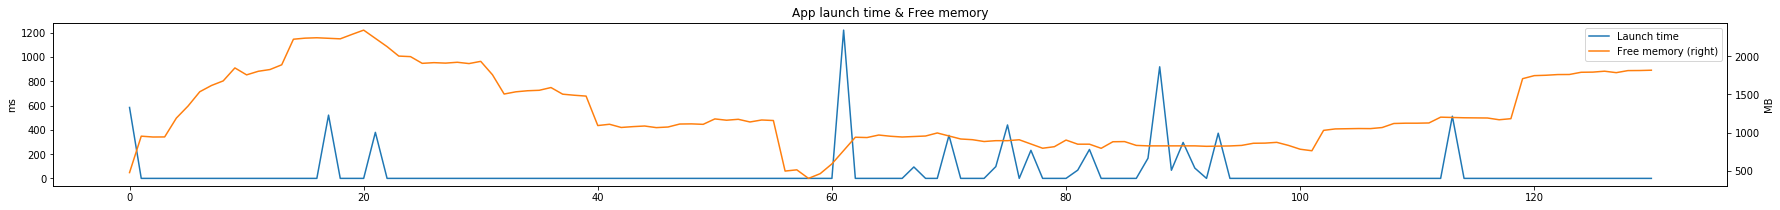

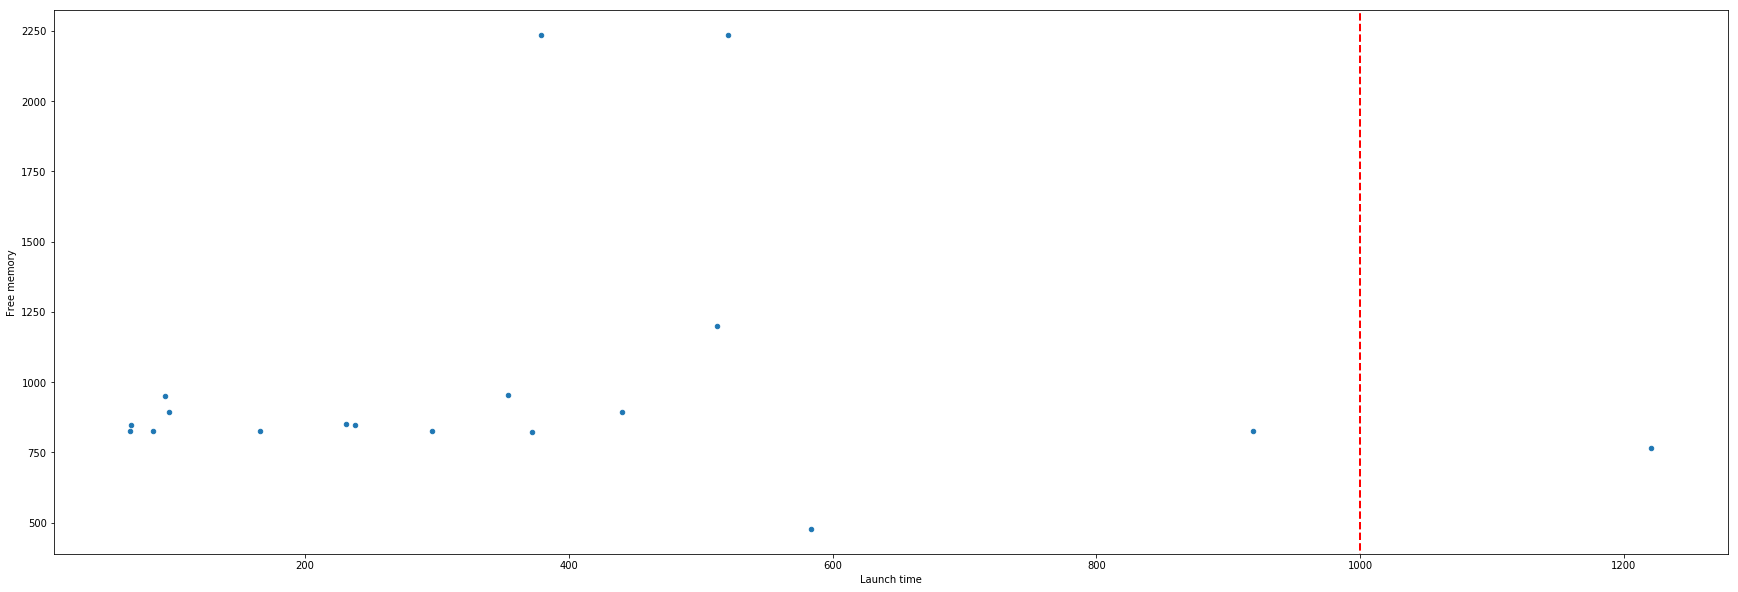

In [96]:
lines = lp.log_sections['EVENT LOG']
am_app_transition_dieds = grep(lines,['am_app_transition', 'am_proc_died'], 1, show=False)
app_launch_mem = list()
app_launch_mem_scatter = list()
app_launches = list()

free_memory = 0
for line in am_app_transition_dieds:
    app_launch_time = 0
    if 'am_app_transition' in line:
        app_launch_time = (int)(line.split(',')[-3])
        app_launches.append(app_launch_time)

    if 'am_proc_died' in line:
        previous_free_memory = free_memory
        free_memory = (int)(line.split(',')[-2])
        avg_free_memory = (previous_free_memory + free_memory) / 2
        
        for app_launch in app_launches:
            app_launch_mem.append([app_launch, avg_free_memory])
            app_launch_mem_scatter.append([app_launch, avg_free_memory])

        del app_launches[:]
        app_launches = list()

        app_launch_mem.append([0, free_memory])
df = pd.DataFrame(app_launch_mem, columns = ['Launch time', 'Free memory'])

#df.index = df['time']
ax = df['Launch time'].plot(figsize=(30,5), legend=True)
ax.set_title('App launch time & Free memory')
ax.set_ylabel('ms')

ax = df['Free memory'].plot(secondary_y=True, figsize=(30,3), legend=True)
ax.set_ylabel('MB')

if len(app_launch_mem_scatter) > 0:
    df = pd.DataFrame(app_launch_mem_scatter, columns = ['Launch time', 'Free memory'])
    ax = df.plot.scatter('Launch time', 'Free memory', figsize=(30,10))
    ax.axvline(x=1000, ymin=-1, ymax=1, color='r', linestyle='--', lw=2)

In [97]:
lines = lp.log_sections['ACTIVITY MANAGER MARs']
OLAF_lines = grep(lines,['\[OLAF', '\[ABI\]'], 1, show=False)
OLAF_lines = [x.replace('/', '-') for x in OLAF_lines]
#display(OLAF_lines)

ABI_dict = dict()

current_OLAF_lines = 0
total_OLAF_lines = len(OLAF_lines)

for am_app_transition in am_app_transitions:
    am_app_transition_log_Time = GetTime2(am_app_transition)
    #print(network_log_with_date)
    if current_OLAF_lines < total_OLAF_lines - 1:
        for i in range(current_OLAF_lines, total_OLAF_lines):
            OLAF_line = OLAF_lines[i]
            OLAF_Time = GetTime2(OLAF_line, 'SSRM')
            #print("===========  {}  {}".format(FreecessController_Time, pkg_Time))
            
            if '[ABI]' in OLAF_line :
                splited = OLAF_line.split('[')
                splited = splited[-1].split(' ')
                if len(splited) > 1:
                    ABI_dict[splited[1]] = OLAF_line
            
            if (OLAF_Time < am_app_transition_log_Time):
                print("{}".format(OLAF_line))
                
                if '[UFA]' in OLAF_line :
                    splited = OLAF_line.split(']')
                    ABIs = splited[-2].split(' ')
                    for ABI in ABIs:
                        if ABI in ABI_dict:
                            print("   ===>  {}".format(ABI_dict[ABI]))
            else:
                break
        current_OLAF_lines = i

    print(" {}".format(am_app_transition))

[02-13 20:08:37.883] [OLAF 10085 [02-13 20:08:37.843]] [[OLAF]  10014 10015 10017 10068 10073 10079 10097 10099 10114 10118 10129 10130 10131 10147 10155 10160 10177 10178 10195 10210 10226 10236 10259 10263 10338 10349 10350 10363 10364 10374 10388 ]
[02-13 20:08:37.983] [UFA] [OLAF:Force  10014 10015 10017 10068 10073 10079 10097 10099 10114 10118 10129 10130 10131 10147 10155 10160 10177 10178 10195 10210 10226 10236 10259 10263 10338 10349 10350 10363 10364 10374 10388]
[02-13 20:09:58.923] [OLAF 10085 [02-13 20:09:58.849]] [[OLAF]  10014 10015 10017 10068 10073 10079 10097 10099 10114 10118 10130 10131 10134 10155 10177 10195 10210 10226 10259 10263 10338 10349 10363 10364 10374 10388 ]
[02-13 20:09:59.149] [UFA] [OLAF:Force  10014 10015 10017 10068 10073 10079 10097 10099 10114 10118 10130 10131 10134 10155 10177 10195 10210 10226 10259 10263 10338 10349 10363 10364 10374 10388]
[02-13 20:11:29.842] [OLAF 10236 [02-13 20:11:29.741]] [[OLAF]  10014 10015 10017 10068 10073 10079 10

In [98]:
for am_app_transition in am_app_transitions:
    #for item in am_app_transition.split(','):
    items = am_app_transition.split(',')
    if '.voc' in am_app_transition:
        print('VOC  >>> ' + am_app_transition)
        
    if int(items[-3]) > 1000:
        print('TIME >>> ' + am_app_transition)
        
    if items[-2] == 'COLD':
        print('COLD >>> ' + am_app_transition)

TIME >>> 02-14 18:25:16.147  1000   926   979 I am_app_transition: [com.google.android.apps.messaging,com.google.android.apps.messaging.conversation.screen.ConversationActivity,SPLASH_SCREEN,844,79,-1,1221,WARM,verify]
COLD >>> 02-14 18:33:49.965  1000   926   979 I am_app_transition: [com.samsung.android.app.galaxyfinder,com.samsung.android.app.galaxyfinder.GalaxyFinderActivity,WINDOWS_DRAWN,373,-1,82,372,COLD,speed-profile]
VOC  >>> 02-14 18:34:40.726  1000   926   979 I am_app_transition: [com.samsung.android.voc,com.samsung.android.voc.initialize.datainitialize.InitializeActivity,WINDOWS_DRAWN,525,-1,-1,512,WARM,verify]


In [99]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,[' Displayed '], 1)

02-14 17:05:21.326  1000   926   979 I ActivityTaskManager: Displayed com.fusionmedia.investing/.ui.activities.SplashActivity: +593ms
02-14 17:05:27.135  1000   926   979 I ActivityTaskManager: Displayed com.fusionmedia.investing/com.google.android.gms.ads.AdActivity: +148ms
02-14 17:05:30.133  1000   926   979 I ActivityTaskManager: Displayed com.fusionmedia.investing/.ui.activities.LiveActivity: +347ms
02-14 17:06:43.988  1000   926   979 I ActivityTaskManager: Displayed com.whatsapp/.Conversation: +584ms
02-14 17:07:37.500  1000   926   979 I ActivityTaskManager: Displayed com.whatsapp/.HomeActivity: +230ms
02-14 17:07:39.224  1000   926   979 I ActivityTaskManager: Displayed com.whatsapp/.Conversation: +171ms
02-14 17:07:58.086  1000   926   979 I ActivityTaskManager: Displayed com.samsung.android.app.spage/.ui.MainActivity: +521ms
02-14 17:10:41.929  1000   926   979 I ActivityTaskManager: Displayed com.whatsapp/.HomeActivity: +379ms
02-14 17:10:44.530  1000   926   979 I Activity

In [100]:
lines = lp.log_sections['OLOG']
applaunch_lines = grep(lines,['APPLAUNCH', 'LCDV'], 1)

--- Nothing ---


In [101]:
applaunch_times = dict()
#applaunch_times.append(list())
#applaunch_times.append(list())
for applaunch_line in applaunch_lines:
    if '[C]' not in applaunch_line and '[S]' not in applaunch_line and '[E]' not in applaunch_line:
        print(applaunch_line)
        applaunch_splited = applaunch_line.split('[')
        if len(applaunch_splited) > 4:
            applaunch_splited = applaunch_splited[4]
            if ']' in applaunch_splited:
                app_name = applaunch_splited.split(']')[0]
                applaunch_splited = applaunch_splited.split(']')[1].split(',')
                if len(applaunch_splited) > 6:
                    app_launchtime = int(applaunch_splited[6])

                    if app_name not in applaunch_times:
                        applaunch_times[app_name] = [0, '']
                    #applaunch_times[app_name].append(app_launchtime)
                    if (applaunch_times[app_name][0] < app_launchtime):
                        applaunch_times[app_name][0] = app_launchtime
                        applaunch_times[app_name][1] = applaunch_line[1:20]
                    #applaunch_times[0].append(applaunch_splited[4].split(']')[0])
                    #applaunch_times[1].append(int(applaunch_splited[4].split(']')[1].split(',')[6]))

In [102]:
pd.DataFrame(applaunch_times).T

Empty DataFrame
Columns: []
Index: []

# <span style="color:blue">[KEYBOARD]</span> 
* Open and close keybboard

In [103]:
keyboard_lines = lp.log_sections['SYSTEM LOG']
tmp = grep(keyboard_lines,['HoneyBoardService onWindow'], 1)

02-14 17:04:08.367 10274  4016  4016 I HBD     : HoneyBoardService onWindowShown
02-14 17:04:10.671 10274  4016  4016 I HBD     : HoneyBoardService onWindowHidden
02-14 17:04:26.258 10274  4016  4016 I HBD     : HoneyBoardService onWindowShown
02-14 17:04:32.426 10274  4016  4016 I HBD     : HoneyBoardService onWindowHidden
02-14 17:04:50.416 10274  4016  4016 I HBD     : HoneyBoardService onWindowShown
02-14 17:04:52.871 10274  4016  4016 I HBD     : HoneyBoardService onWindowHidden
02-14 17:04:56.828 10274  4016  4016 I HBD     : HoneyBoardService onWindowShown
02-14 17:04:57.902 10274  4016  4016 I HBD     : HoneyBoardService onWindowHidden
02-14 17:06:51.978 10274  4016  4016 I HBD     : HoneyBoardService onWindowShown
02-14 17:07:36.856 10274  4016  4016 I HBD     : HoneyBoardService onWindowHidden
02-14 18:25:31.986 10274  4016  4016 I HBD     : HoneyBoardService onWindowShown
02-14 18:25:49.669 10274  4016  4016 I HBD     : HoneyBoardService onWindowHidden
02-14 18:27:03.817 102

In [104]:
tmp = grep(keyboard_lines,['SHOW_SOFT_INPUT', 'HIDE_SOFT_INPUT'], 1)

02-14 16:45:27.481  1000   926  3586 I InputMethodManagerService: Calling com.android.internal.view.IInputMethod$Stub$Proxy@66dae2.showSoftInput(android.os.Binder@a0ea3c, 1, android.os.ResultReceiver@24a33c5) for reason: SHOW_SOFT_INPUT
02-14 16:45:32.707  1000   926  3624 I InputMethodManagerService: Calling com.android.internal.view.IInputMethod$Stub$Proxy@66dae2.showSoftInput(android.os.Binder@553c4f6, 1, android.os.ResultReceiver@6f200f7) for reason: SHOW_SOFT_INPUT
02-14 16:45:48.091  1000   926  1388 I InputMethodManagerService: Calling com.android.internal.view.IInputMethod$Stub$Proxy@66dae2.showSoftInput(android.os.Binder@94997a4, 1, android.os.ResultReceiver@d61b90d) for reason: SHOW_SOFT_INPUT
02-14 16:45:49.786  1000   926  1831 I InputMethodManagerService: Calling com.android.internal.view.IInputMethod$Stub$Proxy@66dae2.showSoftInput(android.os.Binder@2e29fbe, 1, android.os.ResultReceiver@21e181f) for reason: SHOW_SOFT_INPUT
02-14 16:45:50.460  1000   926  3624 I InputMetho

In [105]:
tmp = grep(keyboard_lines,['showSoftInput', 'notifyKeyboardClosed'], 1)

02-14 16:45:27.481  1000   926  3586 I InputMethodManagerService: Calling com.android.internal.view.IInputMethod$Stub$Proxy@66dae2.showSoftInput(android.os.Binder@a0ea3c, 1, android.os.ResultReceiver@24a33c5) for reason: SHOW_SOFT_INPUT
02-14 16:45:27.481  1000   926  3586 D InputMethodManagerService: bindCurrentInputMethodServiceLocked: caller=com.android.server.inputmethod.InputMethodManagerService.showCurrentInputLocked:3729 com.android.server.inputmethod.InputMethodManagerService.showSoftInput:3624 com.android.internal.view.IInputMethodManager$Stub.onTransact:448 com.android.server.inputmethod.InputMethodManagerService.onTransact:2132 android.os.Binder.execTransactInternal:1215 android.os.Binder.execTransact:1179 <bottom of call stack> <bottom of call stack> <bottom of call stack> <bottom of call stack>
02-14 16:45:32.705  1000   926  3624 I InputMethodManagerService: Calling com.android.internal.view.IInputMethod$Stub$Proxy@66dae2.showSoftInput(android.os.Binder@6182d91, 1, null) 

* You know what keyboard was used from this.

In [106]:
lines = lp.log_sections['DUMP OF SERVICE input_method']
tmp = grep(lines,['mCurMethodId'], 1)

mCurMethodId=com.samsung.android.honeyboard/.service.HoneyBoardService


* Honeyboard issue with this logs.<br>
[KeyboardContainer] OnLayoutChangeListener: do not send BoardScrap cause by layout is not changed

In [107]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['do not send BoardScrap cause by layout is not changed'], 1)

--- Nothing ---


In [108]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['App Policy disabled'], 1)

--- Nothing ---


In [109]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['setNetworkState error currentNetworkCapabilities is null '], 1)

--- Nothing ---


* Second and third raw data is for latency.

10-31 11:10:13.663 10167  6085  6085 I HBD     : a [PF_KL] OTE  1 284 286 2163021<br>
10-31 11:10:13.664 10167  6085  6085 I HBD     : a [PF_KL] OTE  0 277 278 1022031<br>
10-31 11:10:13.667 10167  6085  6085 I HBD     : a [PF_KL] OTE  1 204 207 2167344<br>
10-31 11:10:13.668 10167  6085  6085 I HBD     : a [PF_KL] OTE  0 181 182 880782<br>
10-31 11:10:13.670 10167  6085  6085 I HBD     : a [PF_KL] OTE  1 125 126 1427396<br>
                             :<br>
10-31 11:10:51.554 10167  6085  6085 I HBD     : a [PF_KL] OTE  0 260 261 755573<br>
10-31 11:10:51.556 10167  6085  6085 I HBD     : a [PF_KL] OTE  1 204 206 1254531<br>
10-31 11:10:51.557 10167  6085  6085 I HBD     : a [PF_KL] OTE  0 198 198 654583<br>
10-31 11:10:51.558 10167  6085  6085 I HBD     : a [PF_KL] OTE  1 141 142 1245781<br>

In [110]:
lines = lp.log_sections['SYSTEM LOG']
PF_KL_lines = grep(lines,['PF_KL'], 1, show=False)

for line in PF_KL_lines:
    splited = line.split('PF_KL')
    if len(splited) > 1:
        splited = re.sub(' +', ' ', splited[1])
        splited = splited.split(' ')
        if len(splited) > 5:
            sum = 0
            try:
                sum += int(splited[-4])
                sum += int(splited[-3])
                sum += int(splited[-2])
            except:
                sum = 0
            
            if sum > 100 :
                print(line)

02-14 18:37:01.538 10274  4016  4016 I HBD     : a [PF_KL] OTE  1 123 132 8950115


# <span style="color:blue">[INPUT]</span> 

In [111]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['sec_input', '@Sync'], 1)

<6>[98625.864881]  [0:    kworker/0:0: 8103] sec_ts 4-0048: [sec_input] mode:0202 tc:0 noise:00 ext_n:0 wet:0 wc:0(0) lp:(3c) fod:1 D0B000 fn:0061/0061 ED:0 // v:0228 cal:A2(FF) C68T0222.OUTS.L Cal_flag:Success fail_cnt:0 // sp:0 sip:0 id(0,0) tmp(27)// #17 1
<6>[98625.864976]  [0:    kworker/0:0: 8103] wacom_w90xx 10-0056: [sec_input] wacom_print_info: garage used, ps on, pen in, chg true, ble_mode(0xeb), epen unblocked, cover off, count(0,0,0), mode(2), block_cnt(0), check(0), ver[0x4064] #17
<6>[98628.093215]  [3: irq/436-sec_ts:  218] sec_ts 4-0048: [sec_input] [P] tID:0.20974 z:63 major:26 minor:10 loc:C.C tc:1 type:0 noise:(0,00), nlvl:4, maxS:72, hid:0
<6>[98628.417387]  [1: irq/436-sec_ts:  218] sec_ts 4-0048: [sec_input] [R] tID:0 loc:C.C dd:-237,-510 mp:-66,-321 mc:38 tc:0 p:0 noise:(0,00) nlvl:5, maxS:114, hid:0
<6>[98628.892575]  [2: irq/436-sec_ts:  218] sec_ts 4-0048: [sec_input] [P] tID:0.20975 z:63 major:20 minor:12 loc:C.C tc:1 type:0 noise:(0,00), nlvl:3, maxS:89, hid

<6>[98628.093215]  [3: irq/436-sec_ts:  218] sec_ts 4-0048: [sec_input] [P] tID:0.20974 z:63 major:26 minor:10 loc:C.C tc:1 type:0 noise:(0,00), nlvl:4, maxS:72, hid:0
<6>[98628.417387]  [1: irq/436-sec_ts:  218] sec_ts 4-0048: [sec_input] [R] tID:0 loc:C.C dd:-237,-510 mp:-66,-321 mc:38 tc:0 p:0 noise:(0,00) nlvl:5, maxS:114, hid:0
<6>[98639.948647]  [3: irq/436-sec_ts:  218] sec_ts 4-0048: [sec_input] [P] tID:1.20984 z:44 major:11 minor:11 loc:C.C tc:2 type:0 noise:(0,00), nlvl:3, maxS:109, hid:0
<6>[98640.631393]  [3: irq/436-sec_ts:  218] sec_ts 4-0048: [sec_input] [R] tID:1 loc:C.C dd:-492,1485 mp:-159,583 mc:81 tc:0 p:0 noise:(0,00) nlvl:5, maxS:116, hid:1
----------------------> <6>[98655.640806]  [3:tspStateManager: 8592] [sec_input] sec_cmd_store: push cmd: set_grip_data,1,24,10,32,2432
----------------------> <6>[98655.640825]  [3:tspStateManager: 8592] [sec_input] sec_cmd_store_function: cmd = set_grip_data param = 1 24 10 32 2432
----------------------> <6>[98655.640844]  [

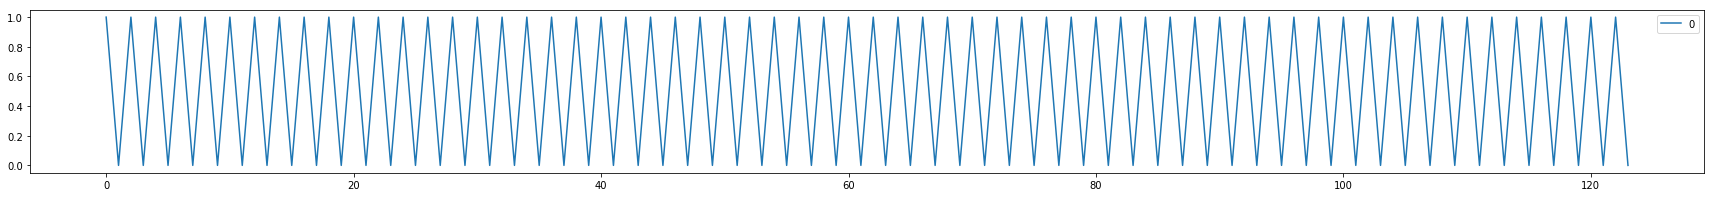

tID : 1,     Count of press : 1,  Count of release : 1


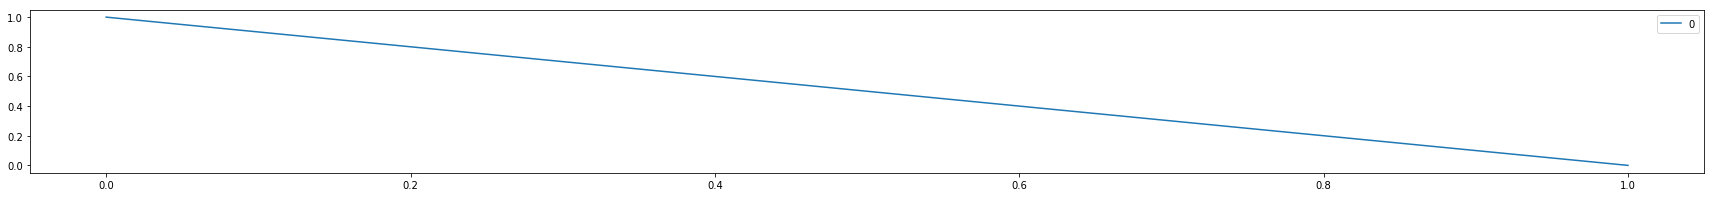

In [112]:
tID_list = dict()
tID_cur = dict()
tID_press = dict()
tID_release = dict()

for sec_input_line in sec_input_lines:
    if 'tID:' in sec_input_line:
        #print(sec_input_line)
        splited_sec_input = sec_input_line.split('tID:')[1]
        numbers = re.findall('\d+', splited_sec_input)
        tID = int(numbers[0])
        
        #display(tID)
        if tID not in tID_list:
            tID_list[tID] = list()
        if tID not in tID_cur:
            tID_cur[tID] = 0
        if tID not in tID_press:
            tID_press[tID] = 0
        if tID not in tID_release:
            tID_release[tID] = 0          

        if '[P]' in sec_input_line:
            tID_cur[tID] += 1
            tID_press[tID] += 1
        elif '[R]' in sec_input_line:
            tID_cur[tID] -= 1
            tID_release[tID] += 1

        if tID_cur[tID] not in tID_list[tID]:
            print(sec_input_line)

        tID_list[tID].append(tID_cur[tID])
    if 'set_grip' in sec_input_line:
        print("----------------------> " + sec_input_line)
print('\n\n')
for key in tID_list.keys():
    print('tID : {},     Count of press : {},  Count of release : {}'.format(key, tID_press[key], tID_release[key]))
    pd.DataFrame(tID_list[key]).plot(figsize=(30,3))
    plt.show()

* The count of noise in sec_input log should be kept with zero.

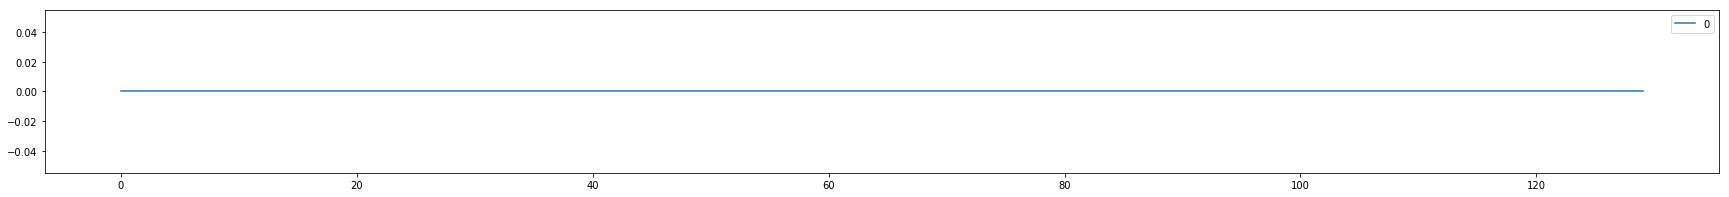

In [113]:
sec_input_noise = list()

for sec_input_line in sec_input_lines:
    #print(sec_input_line)
    if 'noise:(' in sec_input_line:
        #print(sec_input_line.split('noise:(')[1])
        number_of_noise = int(sec_input_line.split('noise:(')[1].split(',')[0])
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
    elif 'noise:' in sec_input_line:
        #print(sec_input_line.split('noise:')[1])
        try:
            number_of_noise = int(sec_input_line.split('noise:')[1].split(',')[0])
        except:
            try:
                number_of_noise = int(sec_input_line.split('noise:')[1].split(' ')[0])
            except:
                try:
                    number_of_noise = int(sec_input_line.split('noise:')[1].split('/')[0])
                except:
                    print("parsing error : {}".format(sec_input_line))
        sec_input_noise.append(number_of_noise)
        if number_of_noise > 0:
            print(sec_input_line)
if len(sec_input_noise):
    df = pd.DataFrame(sec_input_noise)
    df.plot(figsize=(30,3))
else:
    print('---No data---')

In [114]:
lines = lp.log_sections['KERNEL LOG']
sec_input_lines = grep(lines,['NOISE MODE', '@Sync'], 1, show=False)

for sec_input_line in sec_input_lines:
    if '@Sync' in sec_input_line:
        print("sync ----------- " + sec_input_line)
    else:
        print(sec_input_line)

sync ----------- <6>[98638.216614]  [6:       watchdog:  990] !@Sync: 3286 heap: 114 / 132 [2022-02-14 18:33:32.932] sdogWay: softdog FD: 1259
sync ----------- <6>[98668.220167]  [7:       watchdog:  990] !@Sync: 3287 heap: 114 / 134 [2022-02-14 18:34:02.935] sdogWay: softdog FD: 1256
sync ----------- <6>[98698.227994]  [4:       watchdog:  990] !@Sync: 3288 heap: 115 / 134 [2022-02-14 18:34:32.943] sdogWay: softdog FD: 1305
sync ----------- <6>[98728.236272]  [4:       watchdog:  990] !@Sync: 3289 heap: 119 / 134 [2022-02-14 18:35:02.951] sdogWay: softdog FD: 1290


* This logs are shown when processing input events normally after a problem happened.

In [115]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Conflicting pointer actions'], 1)

--- Nothing ---


* Volume up : InputReader: Input event: ... code=114
* Volume dn : InputReader: Input event: ... code=115
* Power key : InputReader: Input event: ... code=116 
* Touch key is same with normal touch.
<br>
* Those log makes a problem.<br>
4347099790 - 01-19 07:31:39.790  1000  1197  2071 I InputDispatcher: Delivering touch to (5379): action: 0x1, f=0x20000000, d=0, '79427d5', t=1 +(-357,-2333)<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2371 D InputDispatcher: Inject motion (2575): action=0x0, time=1050741000000, f=0x20000000, d=0<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2071 I InputDispatcher: Delivering touch to (5379): action: 0x0, f=0x20000000, d=0, '79427d5', t=1 +(-357,-2333)<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2371 D InputDispatcher: Inject motion (2575): action=0x1, time=1050742000000, f=0x20000000, d=0<br>
4347099792 - 01-19 07:31:39.792  1000  1197  2071 I InputDispatcher: Delivering touch to (5379): action: 0x1, f=0x20000000, d=0, '79427d5', t=1 +(-357,-2333)<br>
4347099794 - 01-19 07:31:39.794  1000  1197  2371 D InputDispatcher: Inject motion (2575): action=0x0, time=1050741000000, f=0x20000000, d=0<br>


In [116]:
def printandinit():
    if checklog['kernel'] is False:
        print('>>>>> KERNEL LOG is missing!!! <<<<<')

    if checklog['reader'] is False:
        print('>>>>> InputReader LOG is missing!!! <<<<<')

    if checklog['dispatcher'] is False:
        print('>>>>> InputDispatcher LOG is missing!!! <<<<<')

    checklog['kernel'] = False
    checklog['reader'] = False
    checklog['dispatcher'] = False

lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader'], 1, show=False)

lines = lp.log_sections['KERNEL LOG']
kernel_sec_inputs = grep(lines,['sec_input', '@Sync'], 1, show=False)

idx_reader_dispatcher = 0
idx_sec_input = 0

checklog = dict()
checklog['kernel'] = False
checklog['reader'] = False
checklog['dispatcher'] = False

sync_time = None
sync_kernel_log = None
AdditionalInfor = list()

while True:
    if idx_sec_input >= len(kernel_sec_inputs):
        break
    
    if idx_reader_dispatcher >= len(Reader_Dispatchers):
        break

    reader_dispatcher = Reader_Dispatchers[idx_reader_dispatcher]
    kernel_sec_input = kernel_sec_inputs[idx_sec_input]
    
    if '@Sync' in kernel_sec_input:
        androidtime = GetTime(kernel_sec_input)
        kerneltime = GetKernelTime(kernel_sec_input)

        if androidtime >= 0 and kerneltime >= 0:
            GAP_OF_TIME = androidtime - kerneltime
            sync_time = '[ SYNC {} = {} - {} ]'.format(GAP_OF_TIME, androidtime, kerneltime)
            sync_kernel_log = kernel_sec_input
        
        idx_sec_input += 1
        if idx_sec_input >= len(kernel_sec_inputs):
            break
        kernel_sec_input = kernel_sec_inputs[idx_sec_input]
            
    
    reader_dispatcher_time = GetTime(reader_dispatcher)
    #print("DEBUG android T {}, reader T{}, {}".format(androidtime, reader_dispatcher_time, reader_dispatcher))
    if '[P]' in kernel_sec_input or '[R]' in kernel_sec_input or ' 114,' in kernel_sec_input or ' 115,' in kernel_sec_input or ' 116,' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    elif 'Finger' in kernel_sec_input or 'gpio_keys_gpio_report_event' in kernel_sec_input:
        kernel_sec_input_time = GetKernelTime(kernel_sec_input) + GAP_OF_TIME
    else:
        if 'set_grip' in kernel_sec_input:
            AdditionalInfor.append(kernel_sec_input)
        idx_sec_input += 1
        continue
    
    if reader_dispatcher_time < kernel_sec_input_time:
        if 'InputReader' in reader_dispatcher:
            checklog['reader'] = True
            if checklog['kernel'] is False:
                if 'Btn_touch' in reader_dispatcher or 'Input event' in reader_dispatcher:
                    printandinit()
                    print("")
        if 'InputDispatcher' in reader_dispatcher:
            checklog['dispatcher'] = True
        print("{} - {}".format(reader_dispatcher_time, reader_dispatcher))
        idx_reader_dispatcher += 1
    else:
        
        if len(AdditionalInfor) > 0:
            print('\n[ Grip zone ]')
            while len(AdditionalInfor) > 0:
                print(AdditionalInfor.pop())

        printandinit()

        if sync_time is not None:
            print("")
            print(sync_time)
            print(sync_kernel_log)
            sync_time = None

        print("")
        if ' 114,' in kernel_sec_input:
            print("[[[ VOL UP KEY ]]]")
        elif ' 115,' in kernel_sec_input:
            print("[[[ VOL DN KEY ]]]")
        elif ' 116,' in kernel_sec_input:
            print("[[[ POWER KEY ]]]")
        print("{} - {}".format(kernel_sec_input_time, kernel_sec_input))
        idx_sec_input += 1
        checklog['kernel'] = True

>>>>> KERNEL LOG is missing!!! <<<<<
>>>>> InputDispatcher LOG is missing!!! <<<<<

3776635945 - 02-14 17:03:55.945  1000   926  1137 D InputReader: Btn_touch(7): value=1 when=97170.128821
3776635946 - 02-14 17:03:55.946  1000   926  1137 I InputReader: Touch event's action is 0x0 (id=6, t=0) [pCnt=1, s=0.20635 ] when=97170.128821
3776635948 - 02-14 17:03:55.948  1000   926  1136 W InputDispatcher: partially obscured by 7719d45 net.wz
3776635948 - 02-14 17:03:55.948  1000   926  1136 I InputDispatcher: Delivering touch to (1358): action: 0x4, f=0x0, d=0, '24809ae', t=1
3776635948 - 02-14 17:03:55.948  1000   926  1136 I InputDispatcher: Delivering touch to (4007): action: 0x0, f=0x2, d=0, '38f11bd', t=1 +(0,-1379)
>>>>> KERNEL LOG is missing!!! <<<<<

3776636154 - 02-14 17:03:56.154  1000   926  1137 D InputReader: Btn_touch(7): value=0 when=97170.336908
3776636154 - 02-14 17:03:56.154  1000   926  1137 I InputReader: Touch event's action is 0x1 (id=6, t=0) [pCnt=1, s=] when=97170.3369

In [117]:
lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader', 'HoneyBoardService onWindow'], 1, show=False)

focused_window = ""
missing_event = False
previous_line = ""

for line in Reader_Dispatchers:
    if 'HoneyBoardService onWindow' in line:
        print("===========================================")

    if 'InputReader' in line:
        if 'InputDispatcher' in previous_line:
            if missing_event is True and len(focused_window) > 0:
                print('>>>>> Input event to {} is missing!!! <<<<<'.format(focused_window))
            print("")
        missing_event = True

    if 'Delivering touch to' in line or 'Delivering key to' in line:
        splited_lines = line.split(' ')
        previous = ""
        for item in splited_lines:
            if 'to' == previous:
                if focused_window == item:
                    missing_event = False
                
            previous = item

    if 'Focus entered window' in line:
        splited_lines = line.split(' ')
        previous = ""
        for item in splited_lines:
            if 'window' == previous:
                focused_window = item
                
            previous = item
        missing_event = False

    if 'Focus left window' in line:
        missing_event = False

    previous_line = line
    print(line)

02-14 17:03:55.945  1000   926  1137 D InputReader: Btn_touch(7): value=1 when=97170.128821
02-14 17:03:55.946  1000   926  1137 I InputReader: Touch event's action is 0x0 (id=6, t=0) [pCnt=1, s=0.20635 ] when=97170.128821
02-14 17:03:55.948  1000   926  1136 W InputDispatcher: partially obscured by 7719d45 net.wz
02-14 17:03:55.948  1000   926  1136 I InputDispatcher: Delivering touch to (1358): action: 0x4, f=0x0, d=0, '24809ae', t=1
02-14 17:03:55.948  1000   926  1136 I InputDispatcher: Delivering touch to (4007): action: 0x0, f=0x2, d=0, '38f11bd', t=1 +(0,-1379)

02-14 17:03:56.154  1000   926  1137 D InputReader: Btn_touch(7): value=0 when=97170.336908
02-14 17:03:56.154  1000   926  1137 I InputReader: Touch event's action is 0x1 (id=6, t=0) [pCnt=1, s=] when=97170.336908
02-14 17:03:56.155  1000   926  1136 I InputDispatcher: Delivering touch to (4007): action: 0x1, f=0x2, d=0, '38f11bd', t=1 +(0,-1379)

02-14 17:04:01.633  1000   926  1137 D InputReader: Btn_touch(7): value=1

In [118]:
lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['InputDispatcher', 'InputReader'], 1, show=True)

02-14 17:03:55.945  1000   926  1137 D InputReader: Btn_touch(7): value=1 when=97170.128821
02-14 17:03:55.946  1000   926  1137 I InputReader: Touch event's action is 0x0 (id=6, t=0) [pCnt=1, s=0.20635 ] when=97170.128821
02-14 17:03:55.948  1000   926  1136 W InputDispatcher: partially obscured by 7719d45 net.wz
02-14 17:03:55.948  1000   926  1136 I InputDispatcher: Delivering touch to (1358): action: 0x4, f=0x0, d=0, '24809ae', t=1
02-14 17:03:55.948  1000   926  1136 I InputDispatcher: Delivering touch to (4007): action: 0x0, f=0x2, d=0, '38f11bd', t=1 +(0,-1379)
02-14 17:03:56.154  1000   926  1137 D InputReader: Btn_touch(7): value=0 when=97170.336908
02-14 17:03:56.154  1000   926  1137 I InputReader: Touch event's action is 0x1 (id=6, t=0) [pCnt=1, s=] when=97170.336908
02-14 17:03:56.155  1000   926  1136 I InputDispatcher: Delivering touch to (4007): action: 0x1, f=0x2, d=0, '38f11bd', t=1 +(0,-1379)
02-14 17:04:01.633  1000   926  1137 D InputReader: Btn_touch(7): value=1 w

In [119]:
spent_lines = grep(Reader_Dispatchers,['spent'], 1, show=True)

--- Nothing ---


* If InputReader lose a focus, this logs are printed.

In [120]:
no_focus_lines = grep(Reader_Dispatchers,['Still no focused window'], 1, show=True)

--- Nothing ---


In [121]:
Reader_Dispatchers = grep(lines,['Touch event\'s action is'], 1, show=False)
for line in Reader_Dispatchers:
    if 'Btn_touch' in line:
        print('')
    print(line)

02-14 17:03:55.946  1000   926  1137 I InputReader: Touch event's action is 0x0 (id=6, t=0) [pCnt=1, s=0.20635 ] when=97170.128821
02-14 17:03:56.154  1000   926  1137 I InputReader: Touch event's action is 0x1 (id=6, t=0) [pCnt=1, s=] when=97170.336908
02-14 17:04:01.634  1000   926  1137 I InputReader: Touch event's action is 0x0 (id=6, t=0) [pCnt=1, s=0.20636 ] when=97175.815302
02-14 17:04:01.700  1000   926  1137 I InputReader: Touch event's action is 0x1 (id=6, t=0) [pCnt=1, s=] when=97175.881870
02-14 17:04:02.969  1000   926  1137 I InputReader: Touch event's action is 0x0 (id=6, t=0) [pCnt=1, s=0.20637 ] when=97177.149555
02-14 17:04:03.032  1000   926  1137 I InputReader: Touch event's action is 0x1 (id=6, t=0) [pCnt=1, s=] when=97177.215738
02-14 17:04:06.388  1000   926  1137 I InputReader: Touch event's action is 0x0 (id=6, t=0) [pCnt=1, s=0.20638 ] when=97180.568336
02-14 17:04:06.435  1000   926  1137 I InputReader: Touch event's action is 0x1 (id=6, t=0) [pCnt=1, s=] wh

In [122]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['INPUTD\] TYPE'], 1)

--- Nothing ---


* Touch HW error<br>
ex) An error occured at Rx36<br>
[    5.247112] sec_ts 2-0048 : Rx34 |  307 319 320 322 327 327 328 333 334 332 329 327 326 323 321 319 324<br>
[    5.247129] sec_ts 2-0048 : Rx35 |  313 325 327 329 333 333 335 340 342 340 337 335 333 331 329 325 330<br>
[    5.247146] sec_ts 2-0048 : Rx36 |   -1   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0<br>
[    5.247163] sec_ts 2-0048 : Rx37 |  207 254 256 258 261 261 262 268 226 268 264 262 261 259 257 255 228<br>
<br>
* Kind of types<br>
  sec_ts_read_frame: type 3 -> This raw data during press and is low priority.<br>
  sec_ts_read_frame: type 5 or 29 -> Those are status of touch and are high priority.<br> 
  <br>
[    2.688054] sec_ts 8-0048 : sec_ts_run_rawdata_all: start (noise:0, wet:0)##<br>
[    2.736044] sec_ts 8-0048 : sec_ts_read_frame: type 3<br>
[    2.829200] sec_ts 8-0048 : sec_ts_print_frame<br>

In [123]:
tsp_raw_data_properties = {
    'sec_ts'    : ['Rx00',   'Rx[0-9][0-9]',                  'sec_ts_read_frame',  '|', 'Rx', 'Tx'],
    'slsi_ts'   : ['Rx00',   'Rx[0-9][0-9]',                  'slsi_ts_read_frame', '|', 'Rx', 'Tx'],
    'stm_ts'    : ['Tx00',   'Tx[0-9][0-9]',                  'stm_ts_print_frame', '|', 'Tx', 'Rx'],
    'himax_tp'  : ['TX 1',   'TX[0-9][0-9]|TX [0-9]',         'get_',               'TX', 'Tx', 'Rx'],
    'm??_ts'    : ['\[ 0\]', ': \[ [0-9]\]|: \[[0-9][0-9]\]', '==== ',              ']', 'Rx', 'Tx'],
}

In [124]:
for key, value in tsp_raw_data_properties.items():
    KW_tsp_log = key
    KW_start_index = value[0]
    KW_indexes = value[1]
    KW_tsp_type = value[2]
    KW_separator = value[3]
    KW_label_index = value[4]
    KW_label_column = value[5]
    
    lines = lp.log_sections['KERNEL LOG']
    sec_input_lines = grep(lines,[KW_tsp_log], 1, show=False)
    lines = lp.log_sections['TSP RAW DATA']
    sec_input_lines += grep(lines,[KW_tsp_log], 1, show=False)

    #display(sec_input_lines)
    tsp_types = list()
    x = list()
    x_ = list()
    for sec_input_line in sec_input_lines:
        if re.search(KW_start_index, sec_input_line):
            if len(x_) > 0:
                x.append(x_)
                x_ = list()
                print("")

        if KW_tsp_type in sec_input_line:
            print("")
            print(sec_input_line)
            tsp_types.append(sec_input_line)

        if re.search(KW_indexes, sec_input_line):
            print(sec_input_line)
            splited = sec_input_line.split(KW_separator)
            if len(splited) > 0:
                splited_items = splited[-1].split(' ')
                for splited_item in splited_items:
                    if len(splited_item) > 0:
                        try:
                            if len(splited_item) > 5:
                                x_.append(int(splited_item[:-5]))
                                x_.append(int(splited_item[-5:]))
                            else:
                                x_.append(int(splited_item))
                        except:
                            print('--- Raw data was cracked ---')
    x.append(x_)

    if len(x) > 1 :
        break
        
if len(sec_input_lines) is 0:
    print('--- There is nothing of TSP RAW DATA ---')

--- Nothing ---
--- Nothing ---
--- Nothing ---
--- Nothing ---

[    3.247011] sec_ts 4-0048 : sec_ts_read_frame: type 3
[    3.350057] sec_ts 4-0048 : Rx00 |   56  60  52  40  45  43  43  44  46  48  43  45  40  38  40  42  44  42
[    3.350072] sec_ts 4-0048 : Rx01 |   53  51  43  28  33  33  29  29  30  32  30  32  30  30  30  34  36  36
[    3.350088] sec_ts 4-0048 : Rx02 |   50  45  37  20  22  18  18  16  18  18  18  16  18  18  22  26  32  33
[    3.350104] sec_ts 4-0048 : Rx03 |   44  41  27  12  12  10   6   6   6   8   6   8   8  13  17  17  28  30
[    3.350119] sec_ts 4-0048 : Rx04 |   43  38  26   8   7   1   1  -1   1   1   0   5   5   5  12  15  24  30
[    3.350134] sec_ts 4-0048 : Rx05 |   42  36  22   3   2  -3  -2  -7  -3  -7  -3  -2  -2   0   5  13  22  28
[    3.350163] sec_ts 4-0048 : Rx06 |   45  33  23  -1   1  -3  -6  -9  -7  -5  -8  -4  -6  -2   2   8  19  29
[    3.350180] sec_ts 4-0048 : Rx07 |   40  32  20   0   0  -5  -7 -12 -14 -14 -16 -10  -9  -5  -1   

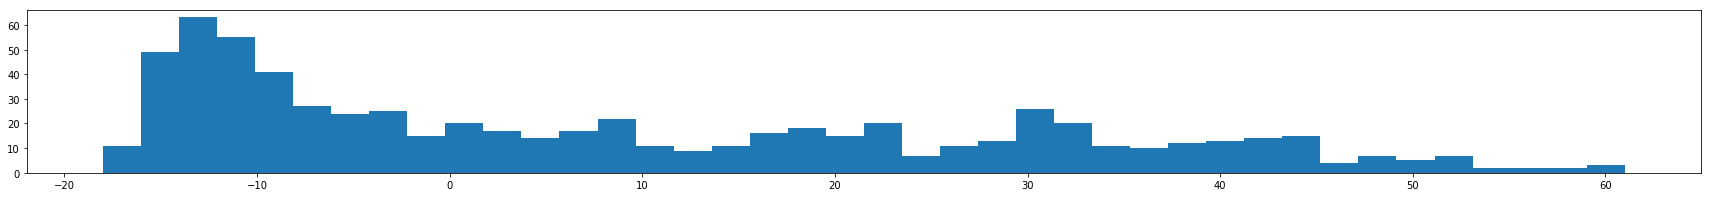

mean : 8.51900584795,  standard deviation : 20.9330858504


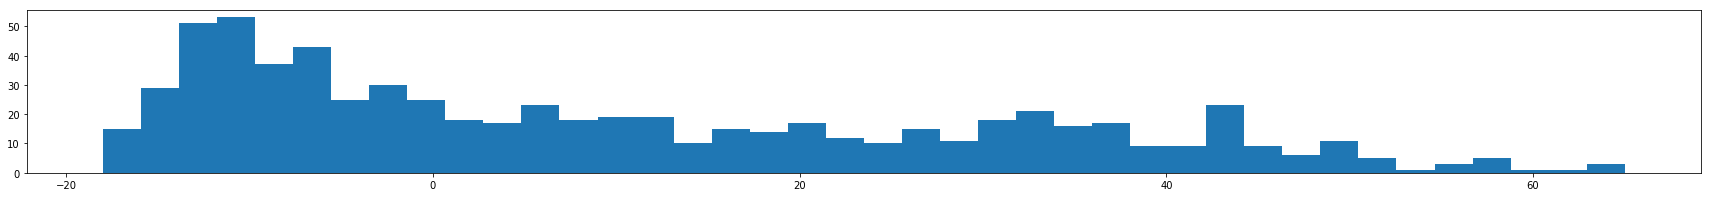

mean : 9.90643274854,  standard deviation : 20.7553280588


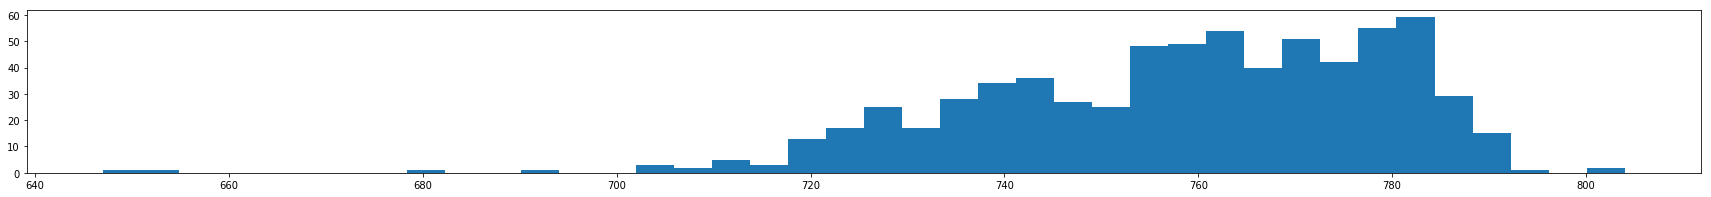

mean : 758.390350877,  standard deviation : 21.1029492796


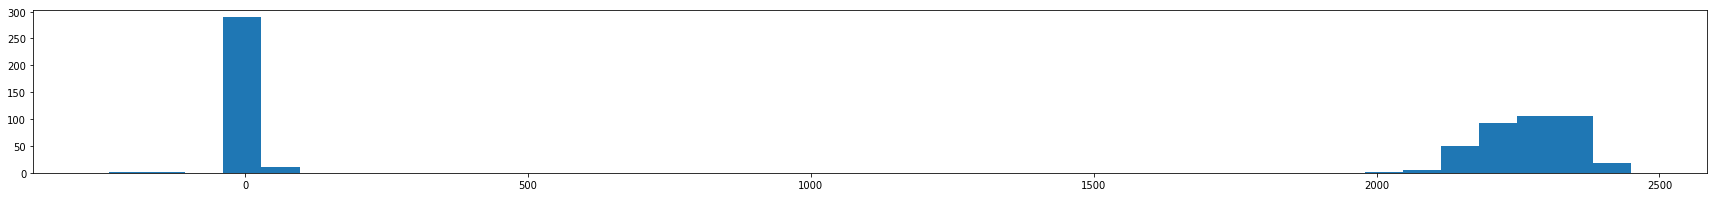

mean : 1256.60818713,  standard deviation : 1129.90822157


In [125]:
for x_ in x:
    plt.figure(figsize=(30, 3))
    plt.hist(x_, bins = 40)
    plt.show()

    arr = np.array(x_)
    print("mean : {},  standard deviation : {}".format(arr.mean(), arr.std()))

In [126]:
x = list()
x_ = list()
tsp_types_idx = 0
for sec_input_line in sec_input_lines:
    if re.search(KW_start_index, sec_input_line):
        if len(x) > 0:
            df = pd.DataFrame(x, columns=[KW_label_column + str(i) for i in range(0,len(x[0]))], index = [KW_label_index + str(i) for i in range(0,len(x))])
            x = list()
            print("")
            try:
                print(tsp_types[tsp_types_idx])
            except:
                print("Out of range")
            tsp_types_idx += 1
            display(df.style.background_gradient(cmap='coolwarm'))

    if re.search(KW_indexes, sec_input_line):
        #print(sec_input_line)
        splited = sec_input_line.split(KW_separator)
        if len(splited) > 0:
            splited_items = splited[-1].split(' ')
            for splited_item in splited_items:
                if len(splited_item) > 0:
                    try:
                        if len(splited_item) > 5:
                            x_.append(int(splited_item[:-5]))
                            x_.append(int(splited_item[-5:]))
                        else:
                            x_.append(int(splited_item))
                    except:
                        print('--- Raw data was cracked ---')
            x.append(x_)
            x_ = list()
if len(x) > 0:
    df = pd.DataFrame(x, columns=['TX' + str(i) for i in range(0,len(x[0]))], index = ['RX' + str(i) for i in range(0,len(x))])
    x = list()
    print("")
    try:
        print(tsp_types[tsp_types_idx])
    except:
        print("Out of range")
    tsp_types_idx += 1
    display(df.style.background_gradient(cmap='coolwarm'))


[    3.247011] sec_ts 4-0048 : sec_ts_read_frame: type 3



[    3.375012] sec_ts 4-0048 : sec_ts_read_frame: type 5



[    3.502969] sec_ts 4-0048 : sec_ts_read_frame: type 29



[    4.218938] sec_ts 4-0048 : sec_ts_read_frame: type 19


* There could be a few problems with PALM_TOUCH event. It would make some touch event ignored or delay.

In [127]:
lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['PALM_TOUCH'], 1, show=True)

02-14 17:06:43.715  1000   926   926 I PalmMotion: [PALM] SURFACE_MOTION_ENGINE: 1 SURFACE_PALM_TOUCH: 1 PALM_TOUCH_TO_SLEEP: 0
02-14 18:25:15.895  1000   926   926 I PalmMotion: [PALM] SURFACE_MOTION_ENGINE: 1 SURFACE_PALM_TOUCH: 1 PALM_TOUCH_TO_SLEEP: 0


In [128]:
lines = lp.log_sections['SYSTEM LOG']
Reader_Dispatchers = grep(lines,['Untrusted touch'], 5, show=True)

02-14 18:25:17.497  1000   926  1136 W InputDispatcher: Untrusted touch due to occlusion by net.wzmn.mivzakon/10238 (obscuring opacity = 1.00, maximum allowed = 0.80)
02-14 18:25:17.497  1000   926  1136 D InputDispatcher: Stack of obscuring windows during untrusted touch (709, 916):
02-14 18:25:17.497  1000   926  1136 D InputDispatcher:     * type=2038, package=net.wzmn.mivzakon/10238, id=20761, mode=USE_OPACITY, alpha=1.00, frame=[0,85][1080,2154], touchableRegion=[0,85][1080,2154], window={893df1d net.wzmn.mivzakon}, flags={NOT_FOCUSABLE | NOT_TOUCHABLE | ALT_FOCUSABLE_IM | SHOW_WHEN_LOCKED | HARDWARE_ACCELERATED}, inputFeatures={0x0}, hasToken=true, applicationInfo.name=, applicationInfo.token=<null>
02-14 18:25:17.497  1000   926  1136 D InputDispatcher:     * [TOUCHED] type=FIRST_APPLICATION_WINDOW, package=com.google.android.apps.messaging/10085, id=33838, mode=BLOCK_UNTRUSTED, alpha=1.00, frame=[0,0][1080,2280], touchableRegion=[0,0][1080,2280], window={a6bd853 com.google.andr

In [129]:
kernel_lines = lp.log_sections['SEC LOG']
kernel_lines += lp.log_sections['KERNEL LOG']

suspend_lines = grep(kernel_lines, ['PM: suspend entry', 'seconds\) done', 'Restarting tasks ...', ' PM: suspend exit'], 1, show=False)

suspend_list = list()
delay_time = 0.0
flag = False
for suspend_line in suspend_lines:
    if 'entry' in suspend_line:
        del suspend_list[:]
        suspend_list = list()

    if 'elapsed' in suspend_line:
        
        splited = suspend_line.split('(')
        splited = splited[1].split(' ')
        try:
            delay_time = (float)(splited[1])
        except:
            delay_time = 0

    suspend_list.append(suspend_line)
    
    if 'exit' in suspend_line:
        if delay_time >= 1:
            display(suspend_list)
            delay_time = 0
            flag = True

if flag is False:
    display('--- Nothing ---')
    
del kernel_lines[:]

--- Nothing ---


'--- Nothing ---'

# <span style="color:blue">[BLUETOOTH]</span> 

In [130]:
lines = ssrm.file_lines
package_lines = grep(lines,['\[BT\]'], 1)

2022-02-10 14:29:24 [SET] [NA0XOXXMHXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-10 14:29:25 [SET] [NA0XOXXMHXXXXXXWOX / Wifi:"LevyNet",2412MHz] [BT] ON
2022-02-10 14:29:47 [SET] [NA0XOXXMHXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-10 14:29:48 [SET] [NA0XOXXMHXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-10 14:29:58 [SET] [NA0XOXXMHXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-10 14:29:59 [SET] [NA0XOXXMHXXXXXXWOX / Wifi:"LevyNet",2412MHz] [BT] ON
2022-02-10 14:30:07 [SET] [ND0XOXXMHXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-10 14:30:08 [SET] [ND0XOXXMHXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-13 15:43:27 [SET] [ND0XOXXMNXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-13 15:43:27 [SET] [ND0XOXXMNXXXXXXWOX / Wifi:"LevyNet",2412MHz] [BT] ON
2022-02-14 13:33:21 [SET] [ND0XOXXMNXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF
2022-02-14 13:33:22 [SET] [ND0XOXXMNXXXXXXWXX / Wifi:"LevyNet",2412MHz] [BT] OFF


# <span style="color:blue">[BOTTLENECKS]</span> 

* If 'dalvik.vm.lockprof.threshold' property is not exist, lock monitor contention is off.

In [131]:
lines = lp.log_sections['SYSTEM PROPERTIES']
tmp = grep(lines,['dalvik.vm.lockprof.threshold'], 1)

[dalvik.vm.lockprof.threshold]: [500]


In [132]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['BOTTLENECK'], 1)

--- Nothing ---


In [133]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['Long monitor contention with owner'], 1)

02-14 17:12:44.085  1000   926  1021 W system_server: Long monitor contention with owner main (926) at void com.android.server.power.PowerManagerService.acquireWakeLockInternal(android.os.IBinder, int, int, java.lang.String, java.lang.String, android.os.WorkSource, java.lang.String, int, int, boolean)(PowerManagerService.java:2150) waiters=0 in void com.android.server.power.PowerManagerService.handleSandman(int) for 476ms
02-14 17:29:31.188 10363 31806 31903 W ung.android.sc: Long monitor contention with owner pool-11-thread-1 (31902) at void com.samsung.android.scs.ai.search.searcher.util.IndexSearcherManager.setSearcherMap(java.lang.String)(IndexSearcherManager.java:195) waiters=0 in void com.samsung.android.scs.ai.search.searcher.util.IndexSearcherManager.setSearcherMap(java.lang.String) for 459ms
02-14 17:30:28.773  1000   926  3498 W system_server: Long monitor contention with owner jobscheduler.bg (1091) at boolean com.android.server.net.NetworkPolicyManagerService.isUidIdle(int)

In [134]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['Slow delivery took', 'Slow dispatch took'], 1)

02-14 16:44:55.233 u0_a8  1358  1358 W Looper  : Slow dispatch took 10ms main h=com.android.internal.os.HandlerCaller$MyHandler c=null m=10010
02-14 16:44:55.344 u0_a8  1358  1358 W Looper  : Slow dispatch took 26ms main h=android.view.Choreographer$FrameHandler c=android.view.Choreographer$FrameDisplayEventReceiver@69d7ed2 m=0
02-14 16:45:00.028 u0_a8  1358  1358 W Looper  : Slow delivery took 20ms main h=android.view.ViewRootImpl$ViewRootHandler c=android.widget.DateTimeView$ReceiverInfo$$ExternalSyntheticLambda0@1de1567 m=0
02-14 16:45:00.160 u0_a8  1358  1358 W Looper  : Slow dispatch took 52ms main h=android.view.Choreographer$FrameHandler c=android.view.Choreographer$FrameDisplayEventReceiver@69d7ed2 m=0
02-14 16:45:08.987 u0_a8  1358  1358 W Looper  : Slow dispatch took 22ms main h=android.view.Choreographer$FrameHandler c=android.view.Choreographer$FrameDisplayEventReceiver@69d7ed2 m=0
02-14 16:45:08.988 u0_a8  1358  1358 W Looper  : Slow delivery took 35ms main h=android.net.C

In [135]:
tmp = grep(Long_monitor_lines,['[0-9].[0-9][0-9][0-9]s', '[5-9][0-9][0-9]ms', '[0-9][0-9][0-9][0-9]ms'], 1)

02-14 16:47:38.084 u0_a8  1358  1358 W Looper  : Slow dispatch took 535ms main h=android.view.Choreographer$FrameHandler c=android.view.Choreographer$FrameDisplayEventReceiver@69d7ed2 m=0
02-14 16:49:49.494 u0_a8  1358  1358 W Looper  : Slow delivery took 1221ms main h=android.os.Handler c=com.android.systemui.statusbar.notification.logging.NotificationLogger$2@2b329b6 m=0
02-14 16:49:52.643 u0_a8  1358  1358 W Looper  : Slow delivery took 678ms main h=android.os.Handler c=com.android.systemui.statusbar.notification.logging.NotificationLogger$2@2b329b6 m=0
02-14 16:49:55.358 u0_a8  1358  1358 W Looper  : Slow delivery took 745ms main h=android.os.Handler c=com.android.systemui.statusbar.notification.logging.NotificationLogger$2@2b329b6 m=0
02-14 17:06:33.636 u0_a8  1358  1358 W Looper  : Slow delivery took 997778ms main h=android.os.Handler c=com.android.systemui.statusbar.notification.logging.NotificationLogger$2@2b329b6 m=0
02-14 17:06:34.571 u0_a8  1358  1358 W Looper  : Slow dispat

In [136]:
lines = lp.log_sections['EVENT LOG']
tmp = grep(lines,['dvm_lock_sample'], 1)

02-14 17:07:45.463 u0_a8  1358  1945 I dvm_lock_sample: [com.android.systemui,0,ConnectivityThread,8,ConnectivityManager.java,3842,void android.net.ConnectivityManager$CallbackHandler.handleMessage(android.os.Message),-,3853,void android.net.ConnectivityManager$CallbackHandler.handleMessage(android.os.Message),1]
02-14 17:07:47.408 10045  3954  8855 I dvm_lock_sample: [com.google.android.gms,0,lowpool[113],23,:com.google.android.gms@214815044@21.48.15 (190400-414534850),2,void com.google.android.gms.common.apiservice.LifecycleSynchronizer.onBeforeDispatching(),-,5,void com.google.android.gms.common.apiservice.LifecycleSynchronizer.onAfterExecution(),4]
02-14 17:08:19.378  1000   926  1004 I dvm_lock_sample: [system_server,0,batterystats-handler,26,BatteryStatsService.java,1028,void com.android.server.am.BatteryStatsService.lambda$noteStopWakelock$23$BatteryStatsService(int, int, java.lang.String, java.lang.String, int, long, long),BatteryExternalStatsWorker.java,715,void com.android.se

In [137]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['BinderCallMonitor'], 1)

--- Nothing ---


###### Critical issues in OLOG.

In [138]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['MAINLOOPER', 'LOCKCONTENTION', 'LOADAPK', 'INPUTD'], 1)

--- Nothing ---


In [139]:
olog_locks = grep(olog_locks, ['[0-9][0-9][0-9][0-9]ms',], 1)

--- Nothing ---


In [140]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['LOCKCONTENTION',], 1)

--- Nothing ---


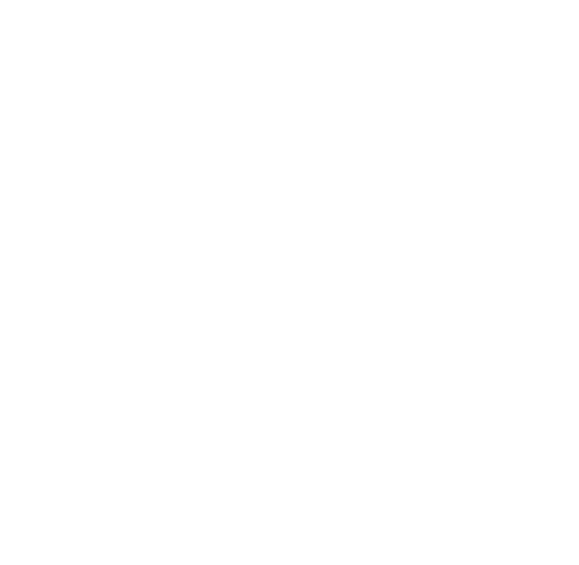

In [141]:
locks_state = dict()
for line in olog_locks:
    if 'LOCKCONTENTION' in line:
        splited_line = line.split('/')
        if len(splited_line) > 2:
            status = splited_line[2]
            locks_state[status] = locks_state.get(status, 0) + 1

#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
plt.figure(figsize=(10, 10))
plt.pie(locks_state.values(), labels = locks_state.keys(), autopct='%1.1f%%') 
plt.show() 

In [142]:
lines = lp.log_sections['OLOG']
mainlooper_lines = grep(lines,['MAINLOOPER'], 1)

--- Nothing ---


Mainlooper handlers in system server


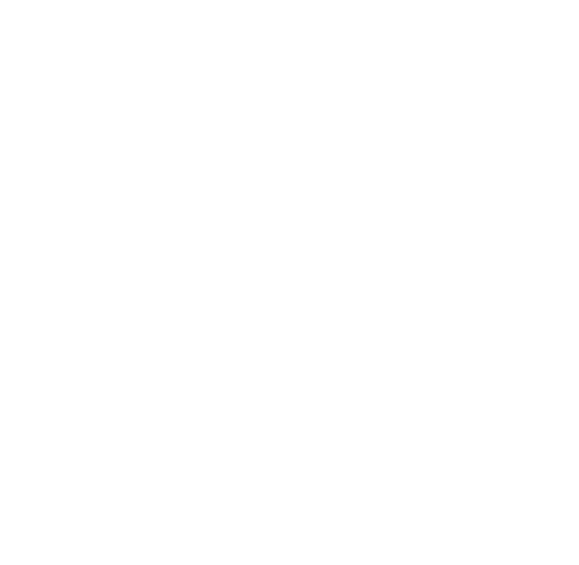

In [143]:
mainlooper_state = dict()
for line in mainlooper_lines:
    if 'MAINLOOPER' in line:
        splited_line = line.split(' ')
        for splited in splited_line :
            #print(splited)
            if splited.startswith('h='):
                mainlooper_state[splited] = mainlooper_state.get(splited, 0) + 1

print('Mainlooper handlers in system server')
#df.plot.pie(y='0', figsize=(5, 5), autopct='%1.1f%%', startangle=100)
plt.figure(figsize=(10, 10))
plt.pie(mainlooper_state.values(), labels = mainlooper_state.keys(), autopct='%1.1f%%') 
plt.show() 

In [144]:
for line in Long_monitor_lines:
    if 'Lambda$LoadedApk' in line:
        print(line)

In [145]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['MUTEX'], 1)

--- Nothing ---


In [146]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['PSI'], 1)

--- Nothing ---


In [147]:
lines = lp.log_sections['OLOG']
tmp = grep(lines,['APPLAUNCH', 'LCDV'], 1)

--- Nothing ---


In [148]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['AVG=[5-9][0-9]'], -90, show=False)

for olog_lock in olog_locks:
    if '/0/null' not in olog_lock and '[DELAY_INFO] LOCKC' not in olog_lock:
        print(olog_lock)

--- Nothing ---


In [149]:
lines = lp.log_sections['SYSTEM LOG']
Long_monitor_lines = grep(lines,['INTENT_ACTION_BOTTLENECK_HINT'], 1)

--- Nothing ---


In [150]:
lines = lp.log_sections['OLOG']
olog_locks = grep(lines, ['INPUTD'], 1)

--- Nothing ---


In [151]:
lines = lp.log_sections['SYSTEM LOG']
olog_locks = grep(lines, ['dex2oat took'], 1)

--- Nothing ---


* refer to P210407-04877



* refer to P210420-02093

04-19 14:40:01.112  1000  1290  2886 D FreecessController: FZ : com.frograms.wplay(11762)<br>
04-19 14:53:28.322  1000  1290  4361 D FreecessController: UFZ : com.frograms.wplay(11762)<br>
04-19 14:53:28.329 10352 11762 11762 I Choreographer: Skipped 48432 frames!  The application may be doing too much work on its main thread.

04-19 14:54:19.212  1000  1290  2886 D FreecessController: FZ : com.frograms.wplay(11762)<br>
04-19 14:59:54.908  1000  1290  3547 D FreecessController: UFZ : com.frograms.wplay(11762)<br>
04-19 14:59:54.911 10352 11762 11762 I Choreographer: Skipped 20141 frames!  The application may be doing too much work on its main thread.

In [152]:
lines = ssrm.file_lines
pkg_lines = grep(lines,['PKG'], 1, show=False)

pkg_lines = pkg_lines[-200:]

lines = lp.log_sections['SYSTEM LOG']
FreecessControllers = grep(lines, ['FreecessController', 'Choreographer: Skipped'], 1, show=False)

current_pkg_lines = 0
total_pkg_lines = len(pkg_lines)

for FreecessController in FreecessControllers:
    FreecessController_Time = GetTime2(FreecessController)
    
    if 'Choreographer' in FreecessController:
        if current_pkg_lines < total_pkg_lines - 1:
            for i in range(current_pkg_lines, total_pkg_lines):
                pkg_line = pkg_lines[i]
                pkg_Time = GetTime2(pkg_line, 'SSRM')
                #print("===========  {}  {}".format(FreecessController_Time, pkg_Time))
                if (pkg_Time < FreecessController_Time):
                    print(pkg_line)
                else:
                    break
            current_pkg_lines = i

        print("     {}".format(FreecessController))

2022-02-14 03:03:00 [PKG] com.sec.android.app.launcher
2022-02-14 03:03:00 [PKG] com.samsung.android.app.notes
2022-02-14 03:03:06 [PKG] com.sec.android.app.launcher
2022-02-14 03:03:07 [PKG] com.moblin.totowiner
2022-02-14 03:03:16 [PKG] com.sec.android.app.launcher
2022-02-14 03:03:16 [PKG] com.samsung.android.app.notes
2022-02-14 03:03:56 [PKG] com.sec.android.app.launcher
2022-02-14 03:03:57 [PKG] com.moblin.totowiner
2022-02-14 03:04:16 [PKG] com.sec.android.app.launcher
2022-02-14 03:04:20 [PKG] com.moblin.totowiner
2022-02-14 03:04:23 [PKG] com.sec.android.app.launcher
2022-02-14 03:04:28 [PKG] com.moblin.totowiner
2022-02-14 03:04:48 [PKG] com.sec.android.app.launcher
2022-02-14 03:04:52 [PKG] com.moblin.totowiner
2022-02-14 03:05:04 [PKG] com.sec.android.app.launcher
2022-02-14 03:05:05 [PKG] com.samsung.android.app.notes
2022-02-14 03:05:08 [PKG] com.sec.android.app.launcher
2022-02-14 03:05:09 [PKG] com.moblin.totowiner
2022-02-14 03:05:30 [PKG] com.sec.android.app.launcher


In [153]:
prelog = list()
pids = list()

for line in FreecessControllers:
    if 'Choreographer' in line:

        splited = line.split(' ')
        del pids[:]
        pids = list()
        
        cnt = 2
        while len(pids) < 3:
            if splited[cnt].isdigit() == True and splited[cnt] != '1000':
                pids.append(splited[cnt])
            elif splited[cnt] == 'I':
                break
            cnt += 1

        for prelog_line in prelog:
            printed = ""
            for pid in pids:
                if pid in prelog_line:
                    printed = pid
                    break
            
            if len(printed) > 0:
                print("{} <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< need to check [{}]".format(prelog_line, printed))
            else:
                print(prelog_line)
        print('\n')
        print(line)
        print(pids)
        print('\n')

        del prelog[:]
        prelog = list()
    else:
        prelog.append(line)
        
for prelog_line in prelog:
    print(prelog_line)

02-14 16:44:55.197  1000   926   997 D FreecessController: UFZ : com.moblin.totowiner(12999)
02-14 16:44:55.199  1000   926  2571 D FreecessController: apply [LRs:false] to uid[10457]
02-14 16:44:55.199  1000   926   997 D FreecessController: UFZ : com.moblin.totowiner(0), reason: broadcast
02-14 16:44:55.199  1000   926  2571 D FreecessController: send pending alarm to packageName:null, uid:10457
02-14 16:44:55.200  1000   926   997 D FreecessController: com.moblin.totowiner(state: Initial -> Freezeable, Reason: broadcast)
02-14 16:44:56.157  1000   926  2570 D FreecessController: UFZ : il.co.globes.android(16650)
02-14 16:44:56.161  1000   926  2571 D FreecessController: apply [LRs:false] to uid[10498]
02-14 16:44:56.161  1000   926  2571 D FreecessController: send pending alarm to packageName:null, uid:10498
02-14 16:44:56.161  1000   926  2570 D FreecessController: UFZ : il.co.globes.android(0), reason: Signal
02-14 16:44:56.161  1000   926  2570 D FreecessController: il.co.globes.

# <span style="color:blue">[GAME]</span> 

##### A list of games for GOS.

In [154]:
lines = lp.log_sections['DUMP OF SERVICE gamemanager']
FreecessController = grep(lines, ['Package Data'], 20)

Package Data:
Game:
UserId    DSS     GTC      GameSDK     PackageName
----------------------------------------------------------------
0         OFF     -4/-2/ 0 -1/-1/true  [com.chess]
0         OFF     -4/-2/ 0 -1/-1/true  [com.kinkajoo.rummikubwalla]
0         OFF     -4/-2/ 0 -1/-1/true  [com.agedstudio.puzzle.sudoku]
0         OFF     -4/-2/ 0 -1/-1/true  [org.lichess.mobileapp]
SecGameFamily:
[com.samsung.android.game.gametools]
[com.sec.android.app.samsungapps]
[com.samsung.android.game.gamehome]
ManagedApp:
[com.sec.android.app.myfiles]
[com.sec.android.app.clockpackage]
[com.sec.android.app.popupcalculator]
[com.android.vending]
--------- 0.325s was the duration of dumpsys gamemanager, ending at: 2022-02-14 18:36:40
-------------------------------------------------------------------------------


##### History of game packages

In [155]:
lines = ssrm.file_lines
game_lines = grep(lines,['DSS :', 'PKG'], 1, show=False)
game_lines = grep(game_lines,['DSS :'], 2)

--- Nothing ---


In [156]:
lines = ssrm.file_lines
game_lines = grep(lines,['DSS :', 'SPA', 'GAMESDK', 'GameThermalCpuControl'], 1)

--- Nothing ---


In [157]:
game_groups = dict()
game_name = "-"

for game_line in game_lines:
    if "DSS" in game_line:
        splited_line = game_line.split(" ")
        game_name = splited_line[3]

    if "GameThermalCpuControl" in game_line:
        if game_name not in game_groups:
            game_groups[game_name] = list()
        game_groups[game_name].append(game_line)

In [158]:
searchers = dict()
searchers['FPS'] = 0
searchers['CF'] = 1
searchers['GF'] = 1
searchers['Lv'] = 0

for game_name in game_groups:
    game_lines = game_groups[game_name]
    fps_cf = DictFromPickedUp(game_lines, searchers)
    
    for i in range(len(fps_cf['CF'])):
        if fps_cf['CF'][i] == -1:
            fps_cf['CF'][i] = CPU_MAX_FREQ / 1000
    

    #display(fps_cf['Lv-'])
    print(game_name)
    if len(game_lines) > 0:
        df = pd.DataFrame(fps_cf)
        #df = df.replace(1, CPU_MAX_FREQ/1000)

        #plt.subplot(211)
        if 'FPS' in df.columns and len(df['FPS']) > 0:
            df['FPS'].plot(figsize=(30,4), legend=True)
            plt.ylim(0, 120)
        if 'CF' in df.columns and len(df['CF']) > 0:
            df['CF'].plot(secondary_y=True, color='red', figsize=(30,4), legend=True)
        #plt.subplot(212)
        if 'FPS' in df.columns and len(df['FPS']) > 0 and 'CF' in df.columns and len(df['CF']) > 0:
            df.plot.scatter('FPS', 'CF', figsize=(30,6))
            plt.xlim(0, 120)
        plt.show()

In [159]:
for game_name in game_groups:
    game_lines = game_groups[game_name]
    fps_cf = DictFromPickedUp(game_lines, searchers)

    #display(game_lines)

    print(game_name)
    if len(game_lines) > 0:
        df = pd.DataFrame(fps_cf)
        #df = df.replace(1, CPU_MAX_FREQ/1000)    
    
        #display(df['FPS'])
        if 'FPS' in df.columns and len(df['FPS']) > 0:
            df['FPS'].plot(figsize=(30,4), legend=True)
            plt.ylim(0, 120)
        if 'GF' in df.columns and len(df['GF']) > 0:
            df['GF'].plot(secondary_y=True, figsize=(30,4), legend=True)
        plt.show()
        if 'FPS' in df.columns and len(df['FPS']) > 0 and 'GF' in df.columns and len(df['GF']) > 0:
            df.plot.scatter('FPS', 'GF', figsize=(30,6))
            plt.xlim(0, 120)
        plt.show()

In [170]:
blur_effect = grep(sf_lines,['_2220'], 1)
blur_effect += grep(sf_lines,['(Blur)'], 1)

--- Nothing ---
03-29 16:52:38.627  1000   960   960 D SurfaceFlinger:      CLIENT | 0xb400007d7e5e9690 | 0000 | RGBA_8888    |    0.0    0.0 1080.0 2400.0 |    0    0 1080 2400 | Bouncer$_1796#0 (Blur)
03-29 16:52:38.650  1000   960   960 D SurfaceFlinger:      CLIENT | 0xb400007d7e5e8dd0 | 0000 | RGBA_8888    |    0.0    0.0 1080.0 2400.0 |    0    0 1080 2400 | Bouncer$_1796#0 (Blur)
03-29 16:52:42.989  1000   960   960 D SurfaceFlinger:      CLIENT | 0xb400007d7e5e5090 | 0000 | RGBA_8888    |    0.0    0.0 1080.0 2400.0 |    0    0 1080 2400 | Bouncer$_1796#0 (Blur)
03-29 16:52:43.006  1000   960   960 D SurfaceFlinger:      CLIENT | 0xb400007d7e5e5090 | 0000 | RGBA_8888    |    0.0    0.0 1080.0 2400.0 |    0    0 1080 2400 | Bouncer$_1796#0 (Blur)
03-29 16:55:08.967  1000   960   960 D SurfaceFlinger:      CLIENT | 0xb400007d7e5eb7d0 | 0000 | RGBA_8888    |    0.0    0.0 1080.0 2400.0 |    0    0 1080 2400 | com.sec.android.app.launcher/com.sec[...]ties.LauncherActivity$_2124#0 (

In [171]:
grep(tmp,['navercafe'], 1)

--- Nothing ---


[]

In [172]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['createSurf', 'Out of memory'], 1)

03-29 16:52:25.275  1003  1257  1276 I BootAnimationLoader: !@BootAnimation : createSurface RGB565
03-29 16:52:25.276  1000   960   988 I SurfaceFlinger: id=1 createSurf (1080x2400),4 flag=0, samsungani565#0
03-29 16:52:29.155  1000   960  1439 I SurfaceFlinger: id=2 createSurf (0x0),-1 flag=80404, Root#0
03-29 16:52:29.155  1000   960  1439 I SurfaceFlinger: id=3 createSurf (0x0),-1 flag=80004, mWindowContainers#0
03-29 16:52:29.155  1000   960  1439 I SurfaceFlinger: id=4 createSurf (0x0),-1 flag=80004, mOverlayContainers#0
03-29 16:52:29.155  1000   960  1439 I SurfaceFlinger: id=5 createSurf (0x0),-1 flag=80004, DisplayArea.Root#0
03-29 16:52:29.156  1000   960  1439 I SurfaceFlinger: id=6 createSurf (0x0),-1 flag=80004, Leaf:0:1#0
03-29 16:52:29.156  1000   960  1439 I SurfaceFlinger: id=7 createSurf (0x0),-1 flag=80004, Leaf:2:2#0
03-29 16:52:29.156  1000   960  1439 I SurfaceFlinger: id=8 createSurf (0x0),-1 flag=80004, DefaultTaskDisplayArea#0
03-29 16:52:29.156  1000   960  14

* If BlackSurface is found in SurfaceFlinger, it could make BLAKC SCREEN problem.

In [173]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['BlackSurface'], 1)

03-29 16:53:25.105  1000  1331  4743 D GameManagerService: setPkgDataWithConfigurationImpl(). configuration: packageName: com.sec.android.app.myfiles, performancePolicyForSsrm: {}, optimalAspectRatio: 1.7777778, dynamicSurfaceScaling: 1.0, category: 10, categoryByUser: 10, fillBlackSurfaceOnMargins: false
03-29 16:53:25.107  1000  1331  4743 D GameManagerService: setPkgDataWithConfigurationImpl(). configuration: packageName: com.sec.android.app.clockpackage, performancePolicyForSsrm: {}, optimalAspectRatio: 1.7777778, dynamicSurfaceScaling: 1.0, category: 10, categoryByUser: 10, fillBlackSurfaceOnMargins: false
03-29 16:53:25.108  1000  1331  4743 D GameManagerService: setPkgDataWithConfigurationImpl(). configuration: packageName: com.samsung.accessory.fridaymgr, performancePolicyForSsrm: {}, optimalAspectRatio: 1.7777778, dynamicSurfaceScaling: 1.0, category: 3, categoryByUser: 3, fillBlackSurfaceOnMargins: false
03-29 16:53:25.109  1000  1331  4743 D GameManagerService: setPkgDataWit

In [174]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['Choreographer: Skipped'], 1)

03-29 16:52:33.426 10062  1796  1796 I Choreographer: Skipped 42 frames!  The application may be doing too much work on its main thread.
03-29 16:52:33.847 10062  1796  1796 I Choreographer: Skipped 50 frames!  The application may be doing too much work on its main thread.
03-29 16:52:34.245 10062  1796  1796 I Choreographer: Skipped 46 frames!  The application may be doing too much work on its main thread.
03-29 16:52:44.967 10062  1796  1796 I Choreographer: Skipped 59 frames!  The application may be doing too much work on its main thread.
03-29 16:52:45.487 10062  1796  1796 I Choreographer: Skipped 62 frames!  The application may be doing too much work on its main thread.
03-29 16:52:53.399 10182  6557  6557 I Choreographer: Skipped 223 frames!  The application may be doing too much work on its main thread.
03-29 16:52:55.175 10182  6557  6557 I Choreographer: Skipped 137 frames!  The application may be doing too much work on its main thread.
03-29 16:52:56.820 10182  6557  6557 I 

refer to PLM P210203-06553

In [175]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['onOverlayChanged'], 1)

--- Nothing ---


* This log means that device have a problem to update screen.

 238286 02-22 09:02:04.617  1000   975   975 W SurfaceFlinger: previousFrameFence is not signaled.<br>
 238287 02-22 09:02:04.634  1000   975   975 W SurfaceFlinger: previousFrameFence is not signaled.<br>
 238319 02-22 09:02:04.667  1000   975   975 W SurfaceFlinger: previousFrameFence is not signaled.<br>
 238320 02-22 09:02:04.684  1000   975   975 W SurfaceFlinger: previousFrameFence is not signaled.<br>
 238323 02-22 09:02:04.717  1000   975   975 W SurfaceFlinger: previousFrameFence is not signaled.<br>

In [176]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['previousFrameFence is not signaled'], 1)

--- Nothing ---


* This log means that device have a problem to update screen.

03-18 11:09:03.885  1000   942   942 I Fence   : waitForever: fence(mali-mali.timeline7-24204) status(0)<br>
03-18 11:09:03.885  1000   942   942 I Fence   : waitForever: sync point: timeline(mali.timeline) drv(mali) status(0) timestamp(0.000000)<br>
03-18 11:09:03.885  1000   942   967 E Fence   : waitForever: Throttling EGL Production: fence 131 didn't signal in 3000 ms<br>
03-18 11:09:03.885  1000   942   967 I Fence   : waitForever: fence(mali-mali.timeline26142-44445) status(0)<br>
03-18 11:09:03.885  1000   942   967 I Fence   : waitForever: sync point: timeline(mali.timeline) drv(mali) status(0) timestamp(0.000000)<br>

In [177]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['waitForever'], 1)

--- Nothing ---


# <span style="color:blue">PANEL</span>

* Check the problem to refer below description.

This is a power control problem in a panel after aod display is on.

<6>[ 1622.988084]  [0:  kworker/u16:2:17630] panel_condition_handler: after aod disp on<br>
<6>[ 1622.988297]  [0:  kworker/u16:2:17630] ========== SHOW PANEL [0Ah:RDDPM] INFO ==========<br>
<6>[ 1622.988304]  [0:  kworker/u16:2:17630] * Reg Value : 0x1d, Result : NG<br>
<6>[ 1622.988309]  [0:  kworker/u16:2:17630] * Bootster Mode : OFF (NG)<br>
<6>[ 1622.988313]  [0:  kworker/u16:2:17630] * Idle Mode     : OFF (GD)<br>
<6>[ 1622.988318]  [0:  kworker/u16:2:17630] * Partial Mode  : OFF<br>
<6>[ 1622.988322]  [0:  kworker/u16:2:17630] * Sleep Mode    : OUT (GD)<br>
<6>[ 1622.988326]  [0:  kworker/u16:2:17630] * Normal Mode   : OK (GD)<br>
<6>[ 1622.988331]  [0:  kworker/u16:2:17630] * Display ON    : ON (GD)<br>
<6>[ 1622.988336]  [0:  kworker/u16:2:17630] =================================================

This is a power problem of panel.

<6>[718790.017374]  [2:composer@2.2-se: 4367] ========== SHOW PANEL [EEh:ERR_FG] INFO ==========<br>
<6>[718790.017388]  [2:composer@2.2-se: 4367] * Reg Value : 0x04, Result : NG<br>
<6>[718790.017392]  [2:composer@2.2-se: 4367] * VLOUT3 Error<br>
<6>[718790.017401]  [2:composer@2.2-se: 4367] ==================================================

In [178]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['SHOW PANEL'], 3)

[155206.953363] [6: HwBinder:755_2:  948] panel-ddi:I:show_rddpm_before_sleep_in: ========== SHOW PANEL [0Ah:RDDPM] INFO (Before SLEEP_IN) ==========
[155206.953367] [6: HwBinder:755_2:  948] panel-ddi:I:show_rddpm_before_sleep_in: * Reg Value : 0x9b, Result : GOOD
[155206.953370] [6: HwBinder:755_2:  948] panel-ddi:I:show_rddpm_before_sleep_in: * Bootster Mode : ON (GD)
[155206.953605] [6: HwBinder:755_2:  948] panel-ddi:I:show_rddsm: ========== SHOW PANEL [0Eh:RDDSM] INFO ==========
[155206.953609] [6: HwBinder:755_2:  948] panel-ddi:I:show_rddsm: * Reg Value : 0x80, Result : GOOD
[155206.953611] [6: HwBinder:755_2:  948] panel-ddi:I:show_rddsm: * TE Mode : ON(GD)
[155206.953903] [6: HwBinder:755_2:  948] panel-ddi:I:show_err: ========== SHOW PANEL [EAh:DSIERR] INFO ==========
[155206.953906] [6: HwBinder:755_2:  948] panel-ddi:I:show_err: * Reg Value : 0x0000, Result : GOOD
[155206.953909] [6: HwBinder:755_2:  948] panel-ddi:I:show_err: ==============================================

* This is <span style="color:red">display team's problem</span> because the lods are shown when panel is dead. 

<3>[18222.622723]  [1:crtc_commit:136:  489] [drm:sde_kms_wait_for_commit_done:1235] [sde error]wait for commit done returned -110<br>
<3>[18222.625373]  [6:crtc_commit:136:  489] [drm:sde_crtc_atomic_begin:3773] [sde error]border fill only commit after ctlstart timeout<br>
<3>[18223.599487]  [1:crtc_commit:136:  489] [drm:_sde_connector_report_panel_dead:1959] [sde error]esd check failed report PANEL_DEAD conn_id: 28 enc_id: 27<br>
<3>[18223.599505]  [1:crtc_commit:136:  489] [drm:sde_encoder_phys_cmd_prepare_for_kickoff:1444] [sde error]failed wait_for_idle: -110

* This is normal log when fingerprint is working.

<3>[230651.506261]  [1:crtc_commit:138:  502] [drm:sde_connector_pre_kickoff:829] [sde error][FINGER MASK]updated finger mask mode 1<br>
<3>[230651.515259]  [1:crtc_commit:138:  502] [sde error]finger_mask_updated/ sysfs_notify finger_mask_state = 1<br>
<3>[230658.278824]  [0:crtc_commit:138:  502] [drm:sde_connector_pre_kickoff:829] [sde error][FINGER MASK]updated finger mask mode 0<br>
<3>[230658.287485]  [0:crtc_commit:138:  502] [sde error]finger_mask_updated/ sysfs_notify finger_mask_state = 0<br>


In [179]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['sde error'], 1)

--- Nothing ---


In [180]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['PANEL_DEAD'], 1)

--- Nothing ---


This is <span style="color:red">display team's problem</span> because TE is not working. 

<6>[18223.373718]  [1:crtc_commit:136:  489] [SDE] ss_check_te : ============ start waiting for TE_0 ============<br>
<3>[18223.599266]  [1:crtc_commit:136:  489] [SDE] ss_check_te : LDI doesn't generate TE<br>
<6>[18223.599296]  [1:crtc_commit:136:  489] [SDE] ss_check_te : ============ end waiting for TE_0 ============<br>

In [181]:
lines = lp.log_sections['KERNEL LOG']
tmp = grep(lines,['ss_check_te'], 1)

--- Nothing ---


# <span style="color:blue">[BINDER]</span>

* Binder thread pool is starved

IPCThreadState: binder thread pool (15 threads) starved for 150 ms<br>
<br>
ex) 09-04 15:21:06.449  5018 13123 13238 E IPCThreadState: binder thread pool (15 threads) starved for 6379 ms

In [182]:
lines = lp.log_sections['SYSTEM LOG']
tmp = grep(lines,['binder thread pool'], 1)

--- Nothing ---


# <span style="color:blue">BROADCAST</span>

    Timeout +1ms #79: BroadcastFilter{ac670d8 10295/u0 ReceiverList{27073bb 12316 com.cashwalk.cashwalk/10295/u0 remote:934f84a}}, [disp=-34s707ms, fin=-24s685ms, dur=+10s22ms]
    Timeout 0 #80: BroadcastFilter{7f8a65e 10295/u0 ReceiverList{379399 12316 com.cashwalk.cashwalk/10295/u0 remote:e7354e0}}, [disp=-24s685ms, fin=-1s28ms, dur=+23s657ms] 	

In [183]:
lines = lp.log_sections['ACTIVITY MANAGER BROADCAST STATE']
broadcast_lines = grep(lines,['Delayed Historical Broadcast', 'Timeout'], 9, show=False)

for broadcast_line in broadcast_lines:
    if 'Delayed Historical Broadcast' in broadcast_line:
        print("")
        
    print(broadcast_line)


Delayed Historical Broadcast foreground #0:
BroadcastRecord{c0f5f24 u-1 android.intent.action.SIM_STATE_CHANGED} to user -1
Intent { act=android.intent.action.SIM_STATE_CHANGED flg=0x15000010 (has extras) }
caller=com.android.phone 1760:com.android.phone/1001 pid=1760 uid=1001
enqueueClockTime=2021-03-29 16:52:44.060 dispatchClockTime=2021-03-29 16:52:44.105
dispatchTime=-10s764ms (+45ms since enq) finishTime=0 (+10s764ms since disp)
resultTo=null resultCode=0 resultData=null
resultAbort=false ordered=false sticky=true initialSticky=false
nextReceiver=35 receiver=null

Delayed Historical Broadcast background #0:
BroadcastRecord{e21255d u0 android.intent.action.BOOT_COMPLETED} to user 0
Intent { act=android.intent.action.BOOT_COMPLETED flg=0x89000010 (has extras) }
caller=null null pid=1331 uid=1000
requiredPermissions=[android.permission.RECEIVE_BOOT_COMPLETED]  appOp=-1
enqueueClockTime=2021-03-29 16:52:44.408 dispatchClockTime=2021-03-29 16:52:44.417
dispatchTime=-1m3s941ms (+9ms si

* Language should be changed.

In [184]:
lines = lp.log_sections['SYSTEM LOG']
broadcast_lines = grep(lines,['LOCALE_CHANGE', 'CONFIGURATION_CHANGE'], 1)

03-29 16:52:33.700  1000  1331  1331 D MotionRecognitionService:   mReceiver.onReceive : CONFIGURATION_CHANGED
03-29 16:52:33.700  1000  1331  1331 D MotionRecognitionService:   mReceiver.onReceive : CONFIGURATION_CHANGED
03-29 16:52:33.709  1000  1331  1331 D MotionRecognitionService:   mReceiver.onReceive : CONFIGURATION_CHANGED
03-29 16:52:33.709  1000  1331  1331 D WALLPAPER_SVC:SemWallpaperManagerService: onReceive: android.intent.action.CONFIGURATION_CHANGED, densityDpi=420, orientation=1
03-29 16:52:34.525 10062  1796  1796 D SecVolume.SecVolumeStore: dispatch [ACTION_CONFIGURATION_CHANGED] with [STATE_NO_DISPATCH]
03-29 16:52:34.594 10062  1796  2173 D QSClockBellTower: onReceive(android.intent.action.CONFIGURATION_CHANGED) mTimeZoneString:null
03-29 16:52:34.594 10062  1796  2128 D vol.VolumeDialogControl: onReceive ACTION_CONFIGURATION_CHANGED
03-29 16:52:34.602 10062  1796  1796 D SecVolume.SecVolumeStore: dispatch [ACTION_CONFIGURATION_CHANGED] with [STATE_NO_DISPATCH]
03-2

In [185]:
lines = lp.log_sections['OLOG']
broadcast_lines = grep(lines,['LOCALE_CHANGE', 'CONFIGURATION_CHANGE'], 2)

--- Nothing ---


# <span style="color:blue">STATICS</span>

In [186]:
lines = lp.log_sections['OLOG']
olog_lines = grep(lines,['MAINLOOPER', 'LOCKCONTENTION', 'BOTTLENECK_HINT', 'INPUTD', 'PSI'], 1)

[03-29 16:52:37.317 1  1331     0 ( 73)][LOG][MAINLOOPER]  Slowdispatch took 266ms main h=android.app.ActivityThread$H c=null m=114
[03-29 16:52:37.600 1  1331     0 (128)][LOG][MAINLOOPER]  Slowdispatch took 273ms main h=android.app.ActivityThread$H c=android.app.LoadedApk$ServiceDispatcher$RunConnection@d502069 m=0
[03-29 16:52:37.822 1  1331     0 (158)][LOG][MAINLOOPER]  Slowdispatch took 111ms main h=android.app.ActivityThread$H c=android.app.-$$Lambda$LoadedApk$ReceiverDispatcher$Args$_BumDX2UKsnxLVrE6UJsJZkotuA@b3e8dd2 m=0
[03-29 16:52:44.119 1  1331     0 (127)][LOG][MAINLOOPER]  Slowdispatch took 232ms main h=com.android.server.cocktailbar.CocktailBarManagerServiceContainer$CocktailBarHandler c=null m=4
[03-29 16:52:44.119 1  1331     0 ( 96)][LOG][MAINLOOPER]  Slowdelivery took 233ms main h=com.android.server.job.JobSchedulerService$JobHandler c=null m=4
[03-29 16:52:44.408 1  1331     0 (157)][LOG][MAINLOOPER]  Slowdispatch took 209ms main h=android.app.ActivityThread$H c=an

In [187]:
BOTTLENECK_INPUT = {'INPUTD':[], 'LOCKC':[], 'MAINL':[], 'PSIIO':[]}
BOTTLENECK = list()
BOTTLENECK_HINT = list()
EMPTY_INPUT = 'ID=EMPTY DELAY=0 WIN=0'
EMPTY = 'ID=EMPTY WIN=0 AVG=0'
EMPTY_HINT = 'ID=EMPTY WIN=0 AVG=0'

for olog_line in olog_lines:
    time = GetTime(olog_line)
    if 'INPUTD' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} {}'.format(time, olog_line))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} [LOCKCONTENTION] Binder:1088_1/0//0/null'.format(time))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} [MAINLOOPER]  Slowdelivery took 0ms main'.format(time))
        if time > 28323279717:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, "ID=EMPTY WIN=0 AVG=5000"))
        else:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))
    elif 'LOCKCONTENTION' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} [INPUTD] TOTAL_DELAY=0, SYSTEM_DELAY=0'.format(time))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} {}'.format(time, olog_line))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} [MAINLOOPER]  Slowdelivery took 0ms main'.format(time))
        if time > 28323279717:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, "ID=EMPTY WIN=0 AVG=5000"))
        else:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))
    elif 'MAINLOOPER' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} [INPUTD] TOTAL_DELAY=0, SYSTEM_DELAY=0'.format(time))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} [LOCKCONTENTION] Binder:1088_1/0//0/null'.format(time))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} {}'.format(time, olog_line))
        if time > 28323279717:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, "ID=EMPTY WIN=0 AVG=5000"))
        else:
            BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))
    elif 'PSI' in olog_line:
        BOTTLENECK_INPUT['PSIIO'].append('TIME={} {}'.format(time, olog_line))    
            
    if '[BOTTLENECK_HINT]  HINT ON' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} [INPUTD] TOTAL_DELAY=0, SYSTEM_DELAY=0'.format(time))
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} [LOCKCONTENTION] Binder:1088_1/0//0/null'.format(time))
        BOTTLENECK_INPUT['MAINL'].append('TIME={} [MAINLOOPER]  Slowdelivery took 0ms main'.format(time))
        #BOTTLENECK_HINT.append('TIME={} {}'.format(time, olog_line))
        

#inputd = DictFromPickedUp(BOTTLENECK_INPUT['INPUTD'], {'TIME':0, 'TOTAL_DELAY':0})
lockc = DictFromPickedUp(BOTTLENECK_INPUT['LOCKC'], {'TIME':0, '/':0})
mainl = DictFromPickedUp(BOTTLENECK_INPUT['MAINL'], {'TIME':0, 'took':0})
#bottleneck = DictFromPickedUp(BOTTLENECK, {'TIME':0, 'WIN':0, 'AVG':0})
pisio = DictFromPickedUp(BOTTLENECK_INPUT['PSIIO'], {'TIME':0, 'avg10':0})
bottleneck_hints = DictFromPickedUp(BOTTLENECK_HINT, {'TIME':0, 'WIN':0, 'AVG':0})
print(pisio)

{'avg10': [], 'TIME': []}


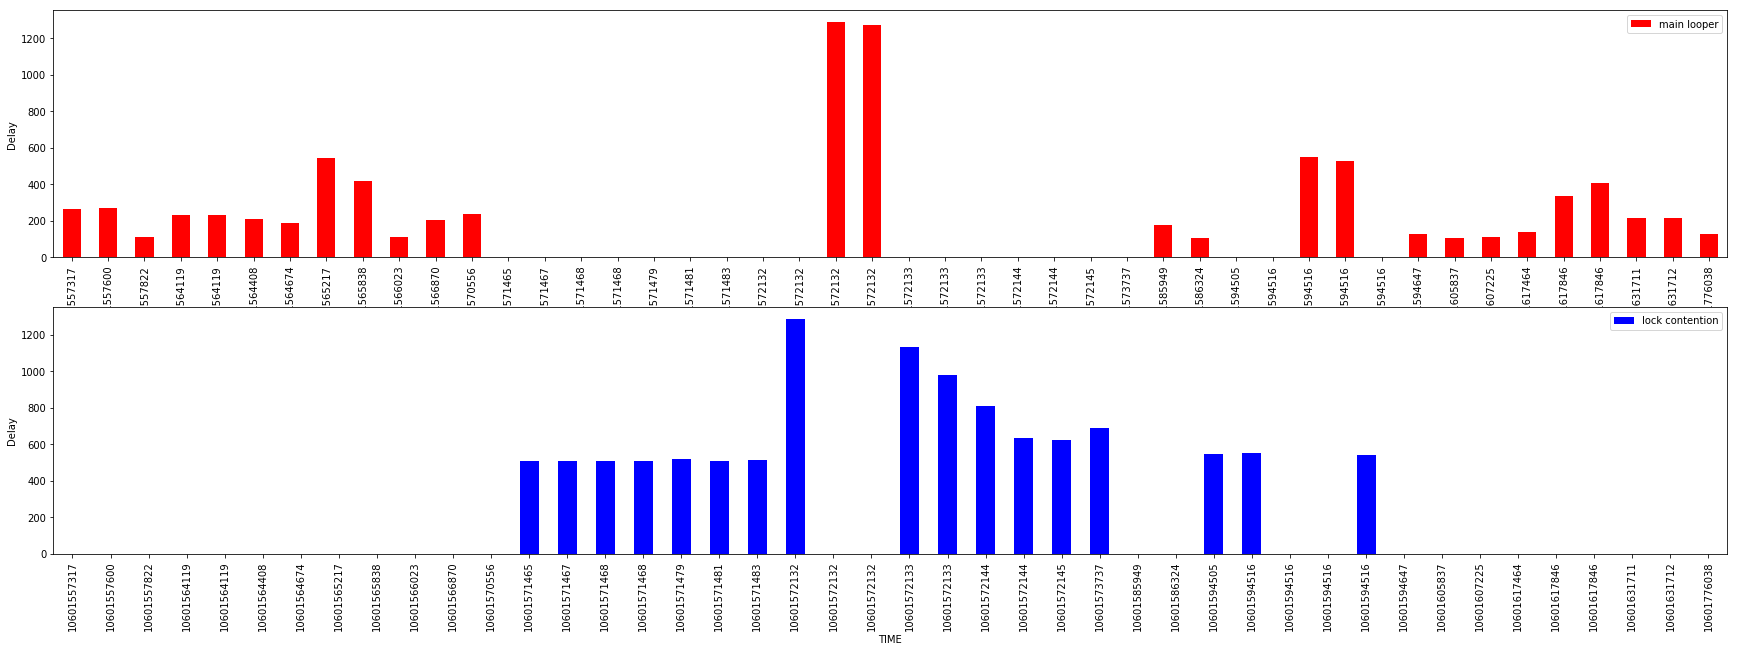

In [188]:
#df = pd.DataFrame(bottleneck_hints)
df_mainl = pd.DataFrame(mainl)
df_lockc = pd.DataFrame(lockc)
#df_inputd = pd.DataFrame(inputd)
df_pisio = pd.DataFrame(pisio)
df_bhint = pd.DataFrame(bottleneck_hints)
#df_bhint['AVG'] = df_bhint['AVG'] * (-1)
#print(df_bhint['AVG'])

fig, axs = plt.subplots(2)
#ax2 = ax1.twinx()

#ax2.text(1,1500, 'v')
#df_bhint.plot(x='TIME', y='AVG', kind='bar', ax=ax2, color='green', label='bottleneck hint', figsize=(30,5), legend=True)
df_mainl.plot(x='TIME', y='took', kind='bar', ax=axs[0], color='red', label='main looper', figsize=(30,10), legend=True)
df_lockc.plot(x='TIME', y='/', kind='bar', ax=axs[1], color='blue', label='lock contention', figsize=(30,10), legend=True)
#df_inputd.plot(x='TIME', y='TOTAL_DELAY', ax=ax2, color='purple', label='input delay', figsize=(30,5), legend=True)
axs[0].legend(loc=0)
axs[1].legend(loc=0)
axs[0].set_ylabel('Delay')
axs[1].set_ylabel('Delay')

#for bottleneck_hint in bottleneck_hints['TIME']:
#    plt.axvline(x=int(bottleneck_hint), color='lime', linestyle='--', alpha=0.3)

#count=0
#for bottleneck_hint in bottleneck_hints['AVG']:
#    if bottleneck_hint > 0 :
#        ax2.text(count,5000, 'o', color='green')
#    count += 1

#plt.axvline(x=29009117939, color='red', linestyle='--')
    
#plt.grid(True)
plt.show()

In [189]:
BOTTLENECK_INPUT = {'INPUTD':[], 'LOCKC':[], 'MAINL':[]}
BOTTLENECK = list()
BOTTLENECK_HINT = list()
EMPTY_INPUT = 'ID=EMPTY DELAY=0 WIN=0'
EMPTY = 'ID=EMPTY WIN=0 AVG=0'
EMPTY_HINT = 'ID=EMPTY WIN=0 AVG=10'

for olog_line in olog_lines:
    time = GetTime(olog_line)
    if 'INPUTD' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} {}'.format(time, olog_line))
    elif 'LOCKCONTENTION' in olog_line:
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} {}'.format(time, olog_line))
    elif 'MAINLOOPER' in olog_line:
        BOTTLENECK_INPUT['MAINL'].append('TIME={} {}'.format(time, olog_line))
        
    if '[BOTTLENECK_HINT]  HINT ON' in olog_line:
        BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))

inputd = DictFromPickedUp(BOTTLENECK_INPUT['INPUTD'], {'TIME':0, 'TOTAL_DELAY':0})
lockc = DictFromPickedUp(BOTTLENECK_INPUT['LOCKC'], {'TIME':0, '/':0})
mainl = DictFromPickedUp(BOTTLENECK_INPUT['MAINL'], {'TIME':0, 'took':0})
#bottleneck = DictFromPickedUp(BOTTLENECK, {'TIME':0, 'WIN':0, 'AVG':0})
bottleneck_hints = DictFromPickedUp(BOTTLENECK_HINT, {'TIME':0, 'WIN':0, 'AVG':0})

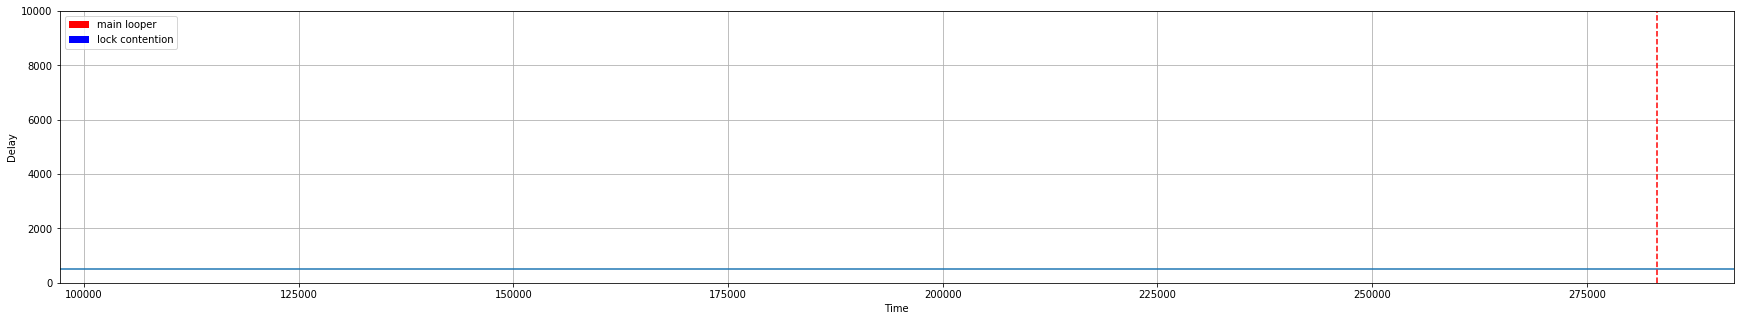

In [190]:
time_scale = 100000.0
#df = pd.DataFrame(bottleneck_hints)
df_mainl = pd.DataFrame(mainl)
df_lockc = pd.DataFrame(lockc)
df_inputd = pd.DataFrame(inputd)
df_pisio = pd.DataFrame(pisio)
df_bhint = pd.DataFrame(bottleneck_hints)

df_mainl['TIME'] = df_mainl['TIME'] / time_scale + 2
df_lockc['TIME'] = df_lockc['TIME'] / time_scale
df_inputd['TIME'] = df_inputd['TIME'] / time_scale + 2
df_pisio['TIME'] = df_pisio['TIME'] / time_scale
df_bhint['TIME'] = df_bhint['TIME'] / time_scale
df_bhint['AVG'] = df_bhint['AVG'] * (-20)

#display(df_inputd)

plt.figure(figsize=(30,5))
if len(df_mainl) > 0:
    plt.bar(df_mainl['TIME'], df_mainl['took'], color='red', label='main looper')
if len(df_lockc) > 0:
    plt.bar(df_lockc['TIME'], df_lockc['/'], color='blue', label='lock contention')
if len(df_inputd) > 0:
    plt.bar(df_inputd['TIME'], df_inputd['TOTAL_DELAY'], color='purple', label='input delay')
if len(df_pisio) > 0:
    plt.scatter(df_pisio['TIME'], df_pisio['avg10'], color='green', label='psi')
#if len(df_bhint) > 0:
#    plt.scatter(df_bhint['TIME'],df_bhint['AVG'], marker='^', label='bottleneck hint (> 500 ms)')
plt.axhline(500)
plt.axvline(int(28323279717 / time_scale) - 1, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Delay')
plt.ylim(0,10000)
plt.legend()
plt.grid()
plt.show()

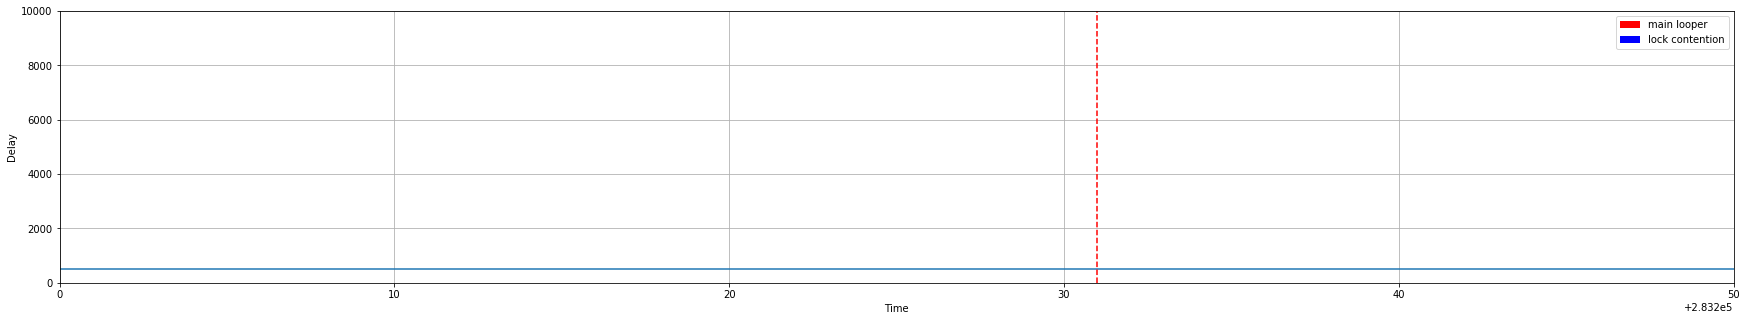

In [191]:
time_scale = 100000.0
#df = pd.DataFrame(bottleneck_hints)
df_mainl = pd.DataFrame(mainl)
df_lockc = pd.DataFrame(lockc)
df_inputd = pd.DataFrame(inputd)
df_pisio = pd.DataFrame(pisio)
df_bhint = pd.DataFrame(bottleneck_hints)

df_mainl['TIME'] = df_mainl['TIME'] / time_scale + 2
df_lockc['TIME'] = df_lockc['TIME'] / time_scale
df_inputd['TIME'] = df_inputd['TIME'] / time_scale + 2
df_pisio['TIME'] = df_pisio['TIME'] / time_scale
df_pisio['avg10'] = df_pisio['avg10'] * 100.0
df_bhint['TIME'] = df_bhint['TIME'] / time_scale
df_bhint['AVG'] = df_bhint['AVG'] * (-20)

#display(df_inputd)

plt.figure(figsize=(30,5))
if len(df_mainl) > 0:
    plt.bar(df_mainl['TIME'], df_mainl['took'], color='red', label='main looper')
if len(df_lockc) > 0:
    plt.bar(df_lockc['TIME'], df_lockc['/'], color='blue', label='lock contention')
if len(df_inputd) > 0:
    plt.bar(df_inputd['TIME'], df_inputd['TOTAL_DELAY'], color='purple', label='input delay')
if len(df_pisio) > 0:
    plt.plot(df_pisio['TIME'], df_pisio['avg10'], color='green', label='psi')
#if len(df_bhint) > 0:
#    plt.scatter(df_bhint['TIME'],df_bhint['AVG'], marker='^', label='bottleneck hint (> 500 ms)')
plt.axhline(500)
plt.axvline(int(28323279717 / time_scale) - 1, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Delay')
plt.ylim(0,10000)
plt.xlim(283200,283250)
plt.legend()
plt.grid()
plt.show()

In [192]:
lines = lp.log_sections['beginning of main']
display(lines)
olog_lines = grep(lines,['Looper  : Slow', 'Long monitor contention', 'BOTTLENECK_HINT'], 1)

[]

--- Nothing ---


In [193]:
BOTTLENECK_INPUT = {'INPUTD':[], 'LOCKC':[], 'MAINL':[]}
BOTTLENECK = list()
BOTTLENECK_HINT = list()
EMPTY_INPUT = 'ID=EMPTY DELAY=0 WIN=0'
EMPTY = 'ID=EMPTY WIN=0 AVG=0'
EMPTY_HINT = 'ID=EMPTY WIN=0 AVG=10'

for olog_line in olog_lines:
    time = GetTime(olog_line)
    if 'INPUTD' in olog_line:
        BOTTLENECK_INPUT['INPUTD'].append('TIME={} {}'.format(time, olog_line))
    elif 'LOCKCONTENTION' in olog_line:
        BOTTLENECK_INPUT['LOCKC'].append('TIME={} {}'.format(time, olog_line))
    elif 'MAINLOOPER' in olog_line:
        BOTTLENECK_INPUT['MAINL'].append('TIME={} {}'.format(time, olog_line))
        
    if '[BOTTLENECK_HINT]  HINT ON' in olog_line:
        BOTTLENECK_HINT.append('TIME={} {}'.format(time, EMPTY_HINT))

inputd = DictFromPickedUp(BOTTLENECK_INPUT['INPUTD'], {'TIME':0, 'TOTAL_DELAY':0})
lockc = DictFromPickedUp(BOTTLENECK_INPUT['LOCKC'], {'TIME':0, '/':0})
mainl = DictFromPickedUp(BOTTLENECK_INPUT['MAINL'], {'TIME':0, 'took':0})
#bottleneck = DictFromPickedUp(BOTTLENECK, {'TIME':0, 'WIN':0, 'AVG':0})
bottleneck_hints = DictFromPickedUp(BOTTLENECK_HINT, {'TIME':0, 'WIN':0, 'AVG':0})